# Satellite image classification



### Setup

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../data/cloud-classif/'
IMG_DIR = os.path.join(DATA_DIR, 'jpg/')
CHECKPOINTS_DIR = 'checkpoints'

In [3]:
import time
import mxnet as mx
from mxnet import gluon
from mxnet.gluon.model_zoo import vision
from mxnet.image import color_normalize
from mxnet.gluon.data.vision import ImageRecordDataset

We'll run in the GPU

In [4]:
ctx = mx.gpu(0)

Use data augmentation to generate some more samples. Using horizontal flip, saturation and contrast because they shouldn't alter the nature of our cloud/not cloud data.  


In [5]:
train_augs = [
     mx.image.HorizontalFlipAug(0.5),
     mx.image.SaturationJitterAug(.1),
     mx.image.ContrastJitterAug(.1),
     mx.image.RandomCropAug((224, 224))
]

test_augs = [
    mx.image.CenterCropAug((224, 224))
]

def transform(data, label, augs):
    data = data.astype('float32')
    for aug in augs:
        data = aug(data)
    data = mx.nd.transpose(data, (2,0,1))
    return data, mx.nd.array([label]).asscalar().astype('float32')

Train and validation sets come from the 'Planet: Understanding the Amazon from Space' Kaggle competition, test dataset is made of Sentinel-2 images.

https://www.kaggle.com/c/planet-understanding-the-amazon-from-space

In [6]:
train_rec = os.path.join(DATA_DIR, 'train/clouds.rec')
valid_rec = os.path.join(DATA_DIR, 'valid/clouds.rec')
test_rec  = os.path.join(DATA_DIR, 'test/s2test.rec')

trainIterator = ImageRecordDataset(
    filename=train_rec, 
    transform=lambda X, y: transform(X, y, train_augs)
)
validIterator = ImageRecordDataset(
    filename=valid_rec, 
    transform=lambda X, y: transform(X, y, train_augs)
)
testIterator = ImageRecordDataset(
    filename=test_rec,
    transform=lambda X, y: transform(X, y, test_augs)
)

When using pretrained networks from Gluon's model zoo, we'll need to normalize input images using this mean and std.

In [7]:
mean = mx.nd.array([0.485, 0.456, 0.406], ctx=ctx).reshape((1,3,1,1))
std =  mx.nd.array([0.229, 0.224, 0.225], ctx=ctx).reshape((1,3,1,1))

### Training

First of all, define functions for training

In [23]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        data = color_normalize(data/255, mean, std)
        output = net(data)
        prediction = mx.nd.argmax(output, axis=1)
        acc.update(preds=prediction, labels=label)
    return acc.get()[1]


def metric_str(names, accs):
    return ', '.join(['%s=%f'%(name, acc) for name, acc in zip(names, accs)])


def train_util(net, train_iter, validation_iter, loss_fn,
               trainer, ctx, epochs, batch_size, checkpoint_dir, init_epoch=0):
    '''
    Function to train the neural network.
    
    PARAMS:
    - net: network to train
    - train_iter: gluon.data.DataLoader with the training data
    - validation_iter: "                      "  validation data
    - loss_fn: loss function to use for training
    - trainer: gluon.Trainer to use for training
    - ctx: context where we will operate (GPU or CPU)
    - epochs: number of epochs to train for
    - batch_size
    - checkpoint_dir: directory where checkpoints are saved every 100 batches
    - init_epoch: set to the initial epoch in case training is resumed from a previous execution'''
    
    res = {'train':[],'valid':[]}
    for epoch in range(1+init_epoch, epochs+init_epoch+1):
        metric = mx.metric.create(['acc'])
        for i, (data, label) in enumerate(train_iter):
            st = time.time()
            # ensure context            
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            # normalize images
            data = color_normalize(data/255, mean, std)
            
            with mx.autograd.record():
                output = net(data)
                loss = loss_fn(output, label)

            loss.backward()
            trainer.step(data.shape[0], ignore_stale_grad=True)
            
            #  Keep a moving average of the losses
            metric.update([label], [output])
            names, accs = metric.get()
            if i%5 == 0:
                print('[Epoch %d Batch %d] speed: %f samples/s, training: %s'%(epoch, i, batch_size/(time.time()-st), metric_str(names, accs)))
            if i%100 == 0:
                net.save_params('%s/%d-%d.params'%(checkpoint_dir, epoch, i))
                # Store accuracy and reset the metric
                metric.reset()
                if i != 0:
                    res['train'].append(accs)

        names, train_acc = metric.get()
        validation_acc = evaluate_accuracy(validation_iter, net)
        res['train'].append(train_acc)
        res['valid'].append(validation_acc)
        print("Epoch %s | training_acc %s | val_acc %s " % (epoch, train_acc, validation_acc))
        
    return res

In [24]:
def train(net, ctx, batch_size=32, epochs=10, learning_rate=0.01, wd=0.001, momentum=0,
          checkpoint_dir='checkpoints', params=None, init_epoch=0):
    train_data = gluon.data.DataLoader(
        trainIterator, batch_size, shuffle=True)
    
    valid_data = gluon.data.DataLoader(
        validIterator, batch_size)
    
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params() if not params else params, 'adam', 
            {'learning_rate': learning_rate})
    
    return train_util(net, train_data, valid_data, 
               loss, trainer, ctx, epochs, batch_size,
               checkpoint_dir, init_epoch=init_epoch)
    

We will train two different networks to compare their performances. The first of them, and also the simplest, is a MobileNet. The second one is a ResNet.

#### MobileNet

In [11]:
checkpoints = os.path.join(CHECKPOINTS_DIR, 'mobilenet')
os.makedirs(checkpoints, exist_ok=True)

# Load the pretrained network
pretrained_mobilenet = vision.mobilenet1_0(pretrained=True) 

# Load the network to train, using the same prefix to avoid problems when saving and loading params,
# as we will assign the features part of the pretrained network to this one
mobilenet = vision.mobilenet1_0(classes=4, prefix=pretrained_mobilenet.prefix)
mobilenet.features = pretrained_mobilenet.features
mobilenet.output.initialize(mx.init.Xavier())

In [12]:
# Train and save the accuracy scores
mobilenet_acc = train(mobilenet, ctx, batch_size=32, epochs=10, learning_rate=0.003, checkpoint_dir=checkpoints)
np.save(checkpoints + '/accuracy-results.npy', mobilenet_acc) 

[Epoch 1 Batch 0] speed: 43.226433 samples/s, training: accuracy=0.156250
[Epoch 1 Batch 5] speed: 1342.418915 samples/s, training: accuracy=0.593750
[Epoch 1 Batch 10] speed: 1376.436792 samples/s, training: accuracy=0.675000
[Epoch 1 Batch 15] speed: 1256.449716 samples/s, training: accuracy=0.681250
[Epoch 1 Batch 20] speed: 1306.649481 samples/s, training: accuracy=0.695312
[Epoch 1 Batch 25] speed: 1200.903046 samples/s, training: accuracy=0.720000
[Epoch 1 Batch 30] speed: 1235.390155 samples/s, training: accuracy=0.728125
[Epoch 1 Batch 35] speed: 1266.443933 samples/s, training: accuracy=0.733929
[Epoch 1 Batch 40] speed: 1255.556441 samples/s, training: accuracy=0.744531
[Epoch 1 Batch 45] speed: 1283.397667 samples/s, training: accuracy=0.754861
[Epoch 1 Batch 50] speed: 1279.531422 samples/s, training: accuracy=0.766250
[Epoch 1 Batch 55] speed: 1303.312501 samples/s, training: accuracy=0.775568
[Epoch 1 Batch 60] speed: 1289.278196 samples/s, training: accuracy=0.779687
[Ep

[Epoch 1 Batch 530] speed: 1297.416414 samples/s, training: accuracy=0.870833
[Epoch 1 Batch 535] speed: 1226.774594 samples/s, training: accuracy=0.878571
[Epoch 1 Batch 540] speed: 1131.741302 samples/s, training: accuracy=0.881250
[Epoch 1 Batch 545] speed: 1278.324949 samples/s, training: accuracy=0.879167
[Epoch 1 Batch 550] speed: 1302.503037 samples/s, training: accuracy=0.878750
[Epoch 1 Batch 555] speed: 1254.277512 samples/s, training: accuracy=0.875568
[Epoch 1 Batch 560] speed: 1228.144100 samples/s, training: accuracy=0.874479
[Epoch 1 Batch 565] speed: 1281.669656 samples/s, training: accuracy=0.873077
[Epoch 1 Batch 570] speed: 1291.486437 samples/s, training: accuracy=0.874107
[Epoch 1 Batch 575] speed: 1245.177920 samples/s, training: accuracy=0.875000
[Epoch 1 Batch 580] speed: 1286.657988 samples/s, training: accuracy=0.875781
[Epoch 1 Batch 585] speed: 1182.212154 samples/s, training: accuracy=0.878309
[Epoch 1 Batch 590] speed: 1263.297014 samples/s, training: accu

[Epoch 2 Batch 105] speed: 1167.039641 samples/s, training: accuracy=0.875000
[Epoch 2 Batch 110] speed: 1293.465374 samples/s, training: accuracy=0.884375
[Epoch 2 Batch 115] speed: 1330.930914 samples/s, training: accuracy=0.887500
[Epoch 2 Batch 120] speed: 1330.390024 samples/s, training: accuracy=0.893750
[Epoch 2 Batch 125] speed: 1258.310861 samples/s, training: accuracy=0.896250
[Epoch 2 Batch 130] speed: 1255.298099 samples/s, training: accuracy=0.890625
[Epoch 2 Batch 135] speed: 1257.108732 samples/s, training: accuracy=0.891071
[Epoch 2 Batch 140] speed: 1239.829366 samples/s, training: accuracy=0.891406
[Epoch 2 Batch 145] speed: 1248.269933 samples/s, training: accuracy=0.888889
[Epoch 2 Batch 150] speed: 1254.453357 samples/s, training: accuracy=0.888125
[Epoch 2 Batch 155] speed: 1276.416312 samples/s, training: accuracy=0.890909
[Epoch 2 Batch 160] speed: 1055.901315 samples/s, training: accuracy=0.888542
[Epoch 2 Batch 165] speed: 1312.347619 samples/s, training: accu

[Epoch 2 Batch 635] speed: 1307.718887 samples/s, training: accuracy=0.897321
[Epoch 2 Batch 640] speed: 1281.045776 samples/s, training: accuracy=0.901563
[Epoch 2 Batch 645] speed: 1269.210376 samples/s, training: accuracy=0.903472
[Epoch 2 Batch 650] speed: 1245.039313 samples/s, training: accuracy=0.900625
[Epoch 2 Batch 655] speed: 1258.747496 samples/s, training: accuracy=0.898295
[Epoch 2 Batch 660] speed: 1233.641501 samples/s, training: accuracy=0.897917
[Epoch 2 Batch 665] speed: 1261.243298 samples/s, training: accuracy=0.899519
[Epoch 2 Batch 670] speed: 1253.668298 samples/s, training: accuracy=0.896429
[Epoch 2 Batch 675] speed: 1296.489007 samples/s, training: accuracy=0.899167
[Epoch 2 Batch 680] speed: 1256.426192 samples/s, training: accuracy=0.898438
[Epoch 2 Batch 685] speed: 1275.445948 samples/s, training: accuracy=0.899265
[Epoch 2 Batch 690] speed: 1271.844291 samples/s, training: accuracy=0.897569
[Epoch 2 Batch 695] speed: 1211.187366 samples/s, training: accu

[Epoch 3 Batch 210] speed: 1326.039381 samples/s, training: accuracy=0.896875
[Epoch 3 Batch 215] speed: 1313.066594 samples/s, training: accuracy=0.912500
[Epoch 3 Batch 220] speed: 1303.236571 samples/s, training: accuracy=0.909375
[Epoch 3 Batch 225] speed: 1245.316558 samples/s, training: accuracy=0.916250
[Epoch 3 Batch 230] speed: 1254.125153 samples/s, training: accuracy=0.913542
[Epoch 3 Batch 235] speed: 1132.992816 samples/s, training: accuracy=0.908036
[Epoch 3 Batch 240] speed: 1287.287348 samples/s, training: accuracy=0.914844
[Epoch 3 Batch 245] speed: 1285.955314 samples/s, training: accuracy=0.918056
[Epoch 3 Batch 250] speed: 1314.365310 samples/s, training: accuracy=0.915625
[Epoch 3 Batch 255] speed: 1275.385349 samples/s, training: accuracy=0.915909
[Epoch 3 Batch 260] speed: 1261.527807 samples/s, training: accuracy=0.915104
[Epoch 3 Batch 265] speed: 1222.227840 samples/s, training: accuracy=0.914423
[Epoch 3 Batch 270] speed: 1313.940694 samples/s, training: accu

[Epoch 3 Batch 740] speed: 1278.897435 samples/s, training: accuracy=0.895312
[Epoch 3 Batch 745] speed: 1256.355627 samples/s, training: accuracy=0.896528
[Epoch 3 Batch 750] speed: 1283.078676 samples/s, training: accuracy=0.899375
[Epoch 3 Batch 755] speed: 1258.063176 samples/s, training: accuracy=0.901705
[Epoch 3 Batch 760] speed: 1166.542623 samples/s, training: accuracy=0.900000
[Epoch 3 Batch 765] speed: 1271.506925 samples/s, training: accuracy=0.901923
[Epoch 3 Batch 770] speed: 1262.643374 samples/s, training: accuracy=0.901339
[Epoch 3 Batch 775] speed: 1252.404897 samples/s, training: accuracy=0.902083
[Epoch 3 Batch 780] speed: 1214.618088 samples/s, training: accuracy=0.903516
[Epoch 3 Batch 785] speed: 1255.756142 samples/s, training: accuracy=0.903309
[Epoch 3 Batch 790] speed: 1267.508362 samples/s, training: accuracy=0.903472
[Epoch 3 Batch 795] speed: 1169.826711 samples/s, training: accuracy=0.900658
[Epoch 3 Batch 800] speed: 1276.792725 samples/s, training: accu

[Epoch 4 Batch 315] speed: 1260.781243 samples/s, training: accuracy=0.904167
[Epoch 4 Batch 320] speed: 1292.021024 samples/s, training: accuracy=0.909375
[Epoch 4 Batch 325] speed: 1318.574791 samples/s, training: accuracy=0.910000
[Epoch 4 Batch 330] speed: 1272.410986 samples/s, training: accuracy=0.912500
[Epoch 4 Batch 335] speed: 1272.459238 samples/s, training: accuracy=0.913393
[Epoch 4 Batch 340] speed: 1359.125576 samples/s, training: accuracy=0.913281
[Epoch 4 Batch 345] speed: 1224.614307 samples/s, training: accuracy=0.912500
[Epoch 4 Batch 350] speed: 1222.272361 samples/s, training: accuracy=0.911875
[Epoch 4 Batch 355] speed: 1253.387322 samples/s, training: accuracy=0.910227
[Epoch 4 Batch 360] speed: 1312.873934 samples/s, training: accuracy=0.907813
[Epoch 4 Batch 365] speed: 1298.483316 samples/s, training: accuracy=0.903365
[Epoch 4 Batch 370] speed: 1271.591250 samples/s, training: accuracy=0.906250
[Epoch 4 Batch 375] speed: 1165.651080 samples/s, training: accu

[Epoch 4 Batch 845] speed: 1247.399840 samples/s, training: accuracy=0.906944
[Epoch 4 Batch 850] speed: 1233.573472 samples/s, training: accuracy=0.905625
[Epoch 4 Batch 855] speed: 1325.201449 samples/s, training: accuracy=0.905682
[Epoch 4 Batch 860] speed: 1284.367882 samples/s, training: accuracy=0.904687
[Epoch 4 Batch 865] speed: 1185.344367 samples/s, training: accuracy=0.905769
[Epoch 4 Batch 870] speed: 1302.680022 samples/s, training: accuracy=0.907143
[Epoch 4 Batch 875] speed: 1304.756853 samples/s, training: accuracy=0.908333
[Epoch 4 Batch 880] speed: 1267.807681 samples/s, training: accuracy=0.903516
[Epoch 4 Batch 885] speed: 1224.748403 samples/s, training: accuracy=0.903676
[Epoch 4 Batch 890] speed: 1318.976484 samples/s, training: accuracy=0.897222
[Epoch 4 Batch 895] speed: 1279.068062 samples/s, training: accuracy=0.897368
[Epoch 4 Batch 900] speed: 1239.886633 samples/s, training: accuracy=0.896875
[Epoch 4 Batch 905] speed: 1271.374438 samples/s, training: accu

[Epoch 5 Batch 420] speed: 1258.464239 samples/s, training: accuracy=0.882812
[Epoch 5 Batch 425] speed: 1267.113478 samples/s, training: accuracy=0.871250
[Epoch 5 Batch 430] speed: 1225.318641 samples/s, training: accuracy=0.867708
[Epoch 5 Batch 435] speed: 1234.833228 samples/s, training: accuracy=0.875893
[Epoch 5 Batch 440] speed: 1245.559249 samples/s, training: accuracy=0.877344
[Epoch 5 Batch 445] speed: 1271.651488 samples/s, training: accuracy=0.885417
[Epoch 5 Batch 450] speed: 1300.899732 samples/s, training: accuracy=0.885625
[Epoch 5 Batch 455] speed: 1205.032528 samples/s, training: accuracy=0.888068
[Epoch 5 Batch 460] speed: 1252.171213 samples/s, training: accuracy=0.889062
[Epoch 5 Batch 465] speed: 1202.689367 samples/s, training: accuracy=0.891827
[Epoch 5 Batch 470] speed: 1188.598471 samples/s, training: accuracy=0.894196
[Epoch 5 Batch 475] speed: 1294.226199 samples/s, training: accuracy=0.893333
[Epoch 5 Batch 480] speed: 1278.118006 samples/s, training: accu

Epoch 5 | training_acc [0.9134993446920052] | val_acc 0.9063241106719367 
[Epoch 6 Batch 0] speed: 1269.654609 samples/s, training: accuracy=0.843750
[Epoch 6 Batch 5] speed: 1246.924702 samples/s, training: accuracy=0.906250
[Epoch 6 Batch 10] speed: 1166.198002 samples/s, training: accuracy=0.903125
[Epoch 6 Batch 15] speed: 1304.807591 samples/s, training: accuracy=0.897917
[Epoch 6 Batch 20] speed: 1318.160398 samples/s, training: accuracy=0.901563
[Epoch 6 Batch 25] speed: 1306.522287 samples/s, training: accuracy=0.897500
[Epoch 6 Batch 30] speed: 1285.118039 samples/s, training: accuracy=0.892708
[Epoch 6 Batch 35] speed: 1305.645324 samples/s, training: accuracy=0.893750
[Epoch 6 Batch 40] speed: 1255.544696 samples/s, training: accuracy=0.892969
[Epoch 6 Batch 45] speed: 1264.880437 samples/s, training: accuracy=0.893750
[Epoch 6 Batch 50] speed: 1253.469260 samples/s, training: accuracy=0.897500
[Epoch 6 Batch 55] speed: 1225.016684 samples/s, training: accuracy=0.891477
[Epo

[Epoch 6 Batch 525] speed: 1259.078124 samples/s, training: accuracy=0.910000
[Epoch 6 Batch 530] speed: 1261.089242 samples/s, training: accuracy=0.908333
[Epoch 6 Batch 535] speed: 1249.222625 samples/s, training: accuracy=0.909821
[Epoch 6 Batch 540] speed: 1222.361414 samples/s, training: accuracy=0.905469
[Epoch 6 Batch 545] speed: 1154.690228 samples/s, training: accuracy=0.907639
[Epoch 6 Batch 550] speed: 1230.779433 samples/s, training: accuracy=0.907500
[Epoch 6 Batch 555] speed: 1253.516087 samples/s, training: accuracy=0.905682
[Epoch 6 Batch 560] speed: 1246.913118 samples/s, training: accuracy=0.906250
[Epoch 6 Batch 565] speed: 1231.344006 samples/s, training: accuracy=0.908173
[Epoch 6 Batch 570] speed: 1237.531607 samples/s, training: accuracy=0.908929
[Epoch 6 Batch 575] speed: 1271.796085 samples/s, training: accuracy=0.907917
[Epoch 6 Batch 580] speed: 1179.936070 samples/s, training: accuracy=0.908984
[Epoch 6 Batch 585] speed: 1332.252003 samples/s, training: accu

[Epoch 7 Batch 100] speed: 1256.602640 samples/s, training: accuracy=0.905625
[Epoch 7 Batch 105] speed: 1233.006853 samples/s, training: accuracy=0.918750
[Epoch 7 Batch 110] speed: 1329.243738 samples/s, training: accuracy=0.918750
[Epoch 7 Batch 115] speed: 1246.669899 samples/s, training: accuracy=0.912500
[Epoch 7 Batch 120] speed: 1128.990083 samples/s, training: accuracy=0.910937
[Epoch 7 Batch 125] speed: 1276.537711 samples/s, training: accuracy=0.907500
[Epoch 7 Batch 130] speed: 1247.921750 samples/s, training: accuracy=0.905208
[Epoch 7 Batch 135] speed: 1265.357430 samples/s, training: accuracy=0.909821
[Epoch 7 Batch 140] speed: 1261.859898 samples/s, training: accuracy=0.914844
[Epoch 7 Batch 145] speed: 1269.474477 samples/s, training: accuracy=0.911111
[Epoch 7 Batch 150] speed: 1164.275920 samples/s, training: accuracy=0.911875
[Epoch 7 Batch 155] speed: 1284.552265 samples/s, training: accuracy=0.911932
[Epoch 7 Batch 160] speed: 1209.212296 samples/s, training: accu

[Epoch 7 Batch 630] speed: 1231.490880 samples/s, training: accuracy=0.912500
[Epoch 7 Batch 635] speed: 1249.548267 samples/s, training: accuracy=0.912500
[Epoch 7 Batch 640] speed: 1254.945985 samples/s, training: accuracy=0.913281
[Epoch 7 Batch 645] speed: 1246.600425 samples/s, training: accuracy=0.909028
[Epoch 7 Batch 650] speed: 1080.605832 samples/s, training: accuracy=0.908125
[Epoch 7 Batch 655] speed: 1288.498435 samples/s, training: accuracy=0.909659
[Epoch 7 Batch 660] speed: 1248.467323 samples/s, training: accuracy=0.907813
[Epoch 7 Batch 665] speed: 1251.354006 samples/s, training: accuracy=0.910577
[Epoch 7 Batch 670] speed: 1242.756741 samples/s, training: accuracy=0.911161
[Epoch 7 Batch 675] speed: 1231.773428 samples/s, training: accuracy=0.910417
[Epoch 7 Batch 680] speed: 1265.930298 samples/s, training: accuracy=0.912109
[Epoch 7 Batch 685] speed: 1222.116550 samples/s, training: accuracy=0.912132
[Epoch 7 Batch 690] speed: 1256.414431 samples/s, training: accu

[Epoch 8 Batch 205] speed: 1186.245331 samples/s, training: accuracy=0.918750
[Epoch 8 Batch 210] speed: 1250.234998 samples/s, training: accuracy=0.906250
[Epoch 8 Batch 215] speed: 1229.021290 samples/s, training: accuracy=0.918750
[Epoch 8 Batch 220] speed: 1218.610205 samples/s, training: accuracy=0.915625
[Epoch 8 Batch 225] speed: 1257.391379 samples/s, training: accuracy=0.916250
[Epoch 8 Batch 230] speed: 1239.325645 samples/s, training: accuracy=0.911458
[Epoch 8 Batch 235] speed: 1310.157042 samples/s, training: accuracy=0.911607
[Epoch 8 Batch 240] speed: 1220.960338 samples/s, training: accuracy=0.915625
[Epoch 8 Batch 245] speed: 1318.924639 samples/s, training: accuracy=0.915972
[Epoch 8 Batch 250] speed: 1225.016684 samples/s, training: accuracy=0.912500
[Epoch 8 Batch 255] speed: 1298.407948 samples/s, training: accuracy=0.914205
[Epoch 8 Batch 260] speed: 1304.477870 samples/s, training: accuracy=0.915625
[Epoch 8 Batch 265] speed: 1271.037321 samples/s, training: accu

[Epoch 8 Batch 735] speed: 1314.391053 samples/s, training: accuracy=0.916964
[Epoch 8 Batch 740] speed: 1250.596126 samples/s, training: accuracy=0.910156
[Epoch 8 Batch 745] speed: 1305.632623 samples/s, training: accuracy=0.913194
[Epoch 8 Batch 750] speed: 1261.575238 samples/s, training: accuracy=0.911250
[Epoch 8 Batch 755] speed: 1313.002367 samples/s, training: accuracy=0.911364
[Epoch 8 Batch 760] speed: 1306.751254 samples/s, training: accuracy=0.907292
[Epoch 8 Batch 765] speed: 1303.818927 samples/s, training: accuracy=0.907212
[Epoch 8 Batch 770] speed: 1277.740811 samples/s, training: accuracy=0.908929
[Epoch 8 Batch 775] speed: 1223.029724 samples/s, training: accuracy=0.907917
[Epoch 8 Batch 780] speed: 1240.792153 samples/s, training: accuracy=0.907422
[Epoch 8 Batch 785] speed: 1314.300957 samples/s, training: accuracy=0.906618
[Epoch 8 Batch 790] speed: 1312.398948 samples/s, training: accuracy=0.906250
[Epoch 8 Batch 795] speed: 1244.127585 samples/s, training: accu

[Epoch 9 Batch 310] speed: 1274.876547 samples/s, training: accuracy=0.928125
[Epoch 9 Batch 315] speed: 1298.998568 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 320] speed: 1205.833667 samples/s, training: accuracy=0.920312
[Epoch 9 Batch 325] speed: 1152.439621 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 330] speed: 1301.215031 samples/s, training: accuracy=0.920833
[Epoch 9 Batch 335] speed: 1266.216927 samples/s, training: accuracy=0.923214
[Epoch 9 Batch 340] speed: 1200.698926 samples/s, training: accuracy=0.924219
[Epoch 9 Batch 345] speed: 1282.845668 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 350] speed: 1256.567347 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 355] speed: 1342.002820 samples/s, training: accuracy=0.921023
[Epoch 9 Batch 360] speed: 1278.081493 samples/s, training: accuracy=0.924479
[Epoch 9 Batch 365] speed: 1331.934702 samples/s, training: accuracy=0.917788
[Epoch 9 Batch 370] speed: 1278.860878 samples/s, training: accu

[Epoch 9 Batch 840] speed: 1241.342989 samples/s, training: accuracy=0.914844
[Epoch 9 Batch 845] speed: 1248.920394 samples/s, training: accuracy=0.913889
[Epoch 9 Batch 850] speed: 1258.263675 samples/s, training: accuracy=0.910000
[Epoch 9 Batch 855] speed: 1264.094182 samples/s, training: accuracy=0.913636
[Epoch 9 Batch 860] speed: 1296.238585 samples/s, training: accuracy=0.912500
[Epoch 9 Batch 865] speed: 1276.987089 samples/s, training: accuracy=0.912019
[Epoch 9 Batch 870] speed: 1230.531186 samples/s, training: accuracy=0.914286
[Epoch 9 Batch 875] speed: 1277.120749 samples/s, training: accuracy=0.911667
[Epoch 9 Batch 880] speed: 1340.314243 samples/s, training: accuracy=0.912500
[Epoch 9 Batch 885] speed: 1271.771983 samples/s, training: accuracy=0.915441
[Epoch 9 Batch 890] speed: 1339.966336 samples/s, training: accuracy=0.916667
[Epoch 9 Batch 895] speed: 1256.202763 samples/s, training: accuracy=0.916118
[Epoch 9 Batch 900] speed: 1303.034135 samples/s, training: accu

[Epoch 10 Batch 410] speed: 1271.711733 samples/s, training: accuracy=0.890625
[Epoch 10 Batch 415] speed: 1168.767279 samples/s, training: accuracy=0.908333
[Epoch 10 Batch 420] speed: 1252.638668 samples/s, training: accuracy=0.910937
[Epoch 10 Batch 425] speed: 1262.417728 samples/s, training: accuracy=0.910000
[Epoch 10 Batch 430] speed: 1277.874629 samples/s, training: accuracy=0.911458
[Epoch 10 Batch 435] speed: 1287.781394 samples/s, training: accuracy=0.916071
[Epoch 10 Batch 440] speed: 1280.532448 samples/s, training: accuracy=0.918750
[Epoch 10 Batch 445] speed: 1270.267440 samples/s, training: accuracy=0.918056
[Epoch 10 Batch 450] speed: 1242.538146 samples/s, training: accuracy=0.914375
[Epoch 10 Batch 455] speed: 1291.051635 samples/s, training: accuracy=0.910227
[Epoch 10 Batch 460] speed: 1275.118783 samples/s, training: accuracy=0.911458
[Epoch 10 Batch 465] speed: 1270.556036 samples/s, training: accuracy=0.912019
[Epoch 10 Batch 470] speed: 1256.873290 samples/s, t

[Epoch 10 Batch 930] speed: 1357.572148 samples/s, training: accuracy=0.913542
[Epoch 10 Batch 935] speed: 1263.546765 samples/s, training: accuracy=0.911607
[Epoch 10 Batch 940] speed: 1282.870191 samples/s, training: accuracy=0.915625
[Epoch 10 Batch 945] speed: 1354.079640 samples/s, training: accuracy=0.915972
Epoch 10 | training_acc [0.9148099606815203] | val_acc 0.8623517786561264 


#### Resnet50

In [6]:
checkpoints = os.path.join(CHECKPOINTS_DIR, 'resnet50')
os.makedirs(checkpoints, exist_ok=True)

# Load the pretrained network
pretrained_resnet = vision.resnet50_v2(pretrained=True) 

# Load the network to train, using the same prefix to avoid problems when saving and loading params,
# as we will assign the features part of the pretrained network to this one
rn50 = vision.resnet50_v2(classes=4, prefix=pretrained_resnet.prefix)
rn50.features = pretrained_resnet.features
rn50.output.initialize(mx.init.Xavier())

In [13]:
# Train and save accuracies over the process
resnet_acc = train(rn50, ctx, batch_size=32, epochs=15, learning_rate=0.003, checkpoint_dir=checkpoints)
np.save(checkpoints + '/accuracy-results.npy', resnet_accacc_acc)

[Epoch 1 Batch 0] speed: 16.685724 samples/s, training: accuracy=0.468750
[Epoch 1 Batch 5] speed: 622.932818 samples/s, training: accuracy=0.468750
[Epoch 1 Batch 10] speed: 613.502251 samples/s, training: accuracy=0.615625
[Epoch 1 Batch 15] speed: 598.006291 samples/s, training: accuracy=0.658333
[Epoch 1 Batch 20] speed: 594.665237 samples/s, training: accuracy=0.676562
[Epoch 1 Batch 25] speed: 585.548751 samples/s, training: accuracy=0.682500
[Epoch 1 Batch 30] speed: 600.771357 samples/s, training: accuracy=0.689583
[Epoch 1 Batch 35] speed: 612.936308 samples/s, training: accuracy=0.699107
[Epoch 1 Batch 40] speed: 588.222759 samples/s, training: accuracy=0.703125
[Epoch 1 Batch 45] speed: 621.067836 samples/s, training: accuracy=0.709722
[Epoch 1 Batch 50] speed: 607.223870 samples/s, training: accuracy=0.712500
[Epoch 1 Batch 55] speed: 619.071184 samples/s, training: accuracy=0.717614
[Epoch 1 Batch 60] speed: 604.290381 samples/s, training: accuracy=0.722917
[Epoch 1 Batch 

[Epoch 1 Batch 535] speed: 624.678175 samples/s, training: accuracy=0.752679
[Epoch 1 Batch 540] speed: 615.776515 samples/s, training: accuracy=0.748437
[Epoch 1 Batch 545] speed: 623.769487 samples/s, training: accuracy=0.745139
[Epoch 1 Batch 550] speed: 610.913646 samples/s, training: accuracy=0.741875
[Epoch 1 Batch 555] speed: 610.377447 samples/s, training: accuracy=0.739773
[Epoch 1 Batch 560] speed: 602.583890 samples/s, training: accuracy=0.740625
[Epoch 1 Batch 565] speed: 616.118544 samples/s, training: accuracy=0.741827
[Epoch 1 Batch 570] speed: 622.794074 samples/s, training: accuracy=0.736607
[Epoch 1 Batch 575] speed: 607.487714 samples/s, training: accuracy=0.740833
[Epoch 1 Batch 580] speed: 614.457193 samples/s, training: accuracy=0.742188
[Epoch 1 Batch 585] speed: 617.948186 samples/s, training: accuracy=0.742647
[Epoch 1 Batch 590] speed: 605.899873 samples/s, training: accuracy=0.742361
[Epoch 1 Batch 595] speed: 607.861886 samples/s, training: accuracy=0.744079

[Epoch 2 Batch 115] speed: 616.146827 samples/s, training: accuracy=0.816667
[Epoch 2 Batch 120] speed: 582.587737 samples/s, training: accuracy=0.826562
[Epoch 2 Batch 125] speed: 603.610970 samples/s, training: accuracy=0.828750
[Epoch 2 Batch 130] speed: 616.789570 samples/s, training: accuracy=0.823958
[Epoch 2 Batch 135] speed: 598.972367 samples/s, training: accuracy=0.824107
[Epoch 2 Batch 140] speed: 612.947504 samples/s, training: accuracy=0.824219
[Epoch 2 Batch 145] speed: 612.262463 samples/s, training: accuracy=0.820833
[Epoch 2 Batch 150] speed: 617.504672 samples/s, training: accuracy=0.826875
[Epoch 2 Batch 155] speed: 610.044534 samples/s, training: accuracy=0.826705
[Epoch 2 Batch 160] speed: 606.853226 samples/s, training: accuracy=0.820833
[Epoch 2 Batch 165] speed: 622.107042 samples/s, training: accuracy=0.817788
[Epoch 2 Batch 170] speed: 609.009279 samples/s, training: accuracy=0.822321
[Epoch 2 Batch 175] speed: 611.972132 samples/s, training: accuracy=0.823333

[Epoch 2 Batch 650] speed: 610.933111 samples/s, training: accuracy=0.854375
[Epoch 2 Batch 655] speed: 615.561881 samples/s, training: accuracy=0.855114
[Epoch 2 Batch 660] speed: 635.040562 samples/s, training: accuracy=0.858854
[Epoch 2 Batch 665] speed: 616.653548 samples/s, training: accuracy=0.858654
[Epoch 2 Batch 670] speed: 616.401499 samples/s, training: accuracy=0.861607
[Epoch 2 Batch 675] speed: 619.476920 samples/s, training: accuracy=0.863333
[Epoch 2 Batch 680] speed: 589.584481 samples/s, training: accuracy=0.862109
[Epoch 2 Batch 685] speed: 626.796094 samples/s, training: accuracy=0.860662
[Epoch 2 Batch 690] speed: 607.765548 samples/s, training: accuracy=0.861806
[Epoch 2 Batch 695] speed: 629.353090 samples/s, training: accuracy=0.861184
[Epoch 2 Batch 700] speed: 613.485426 samples/s, training: accuracy=0.860000
[Epoch 2 Batch 705] speed: 589.364422 samples/s, training: accuracy=0.875000
[Epoch 2 Batch 710] speed: 630.032568 samples/s, training: accuracy=0.865625

[Epoch 3 Batch 230] speed: 626.816585 samples/s, training: accuracy=0.871875
[Epoch 3 Batch 235] speed: 627.267717 samples/s, training: accuracy=0.868750
[Epoch 3 Batch 240] speed: 610.988733 samples/s, training: accuracy=0.865625
[Epoch 3 Batch 245] speed: 612.950304 samples/s, training: accuracy=0.867361
[Epoch 3 Batch 250] speed: 609.703674 samples/s, training: accuracy=0.864375
[Epoch 3 Batch 255] speed: 614.291269 samples/s, training: accuracy=0.864205
[Epoch 3 Batch 260] speed: 615.892366 samples/s, training: accuracy=0.863542
[Epoch 3 Batch 265] speed: 610.541263 samples/s, training: accuracy=0.862019
[Epoch 3 Batch 270] speed: 580.918474 samples/s, training: accuracy=0.865179
[Epoch 3 Batch 275] speed: 618.606099 samples/s, training: accuracy=0.864167
[Epoch 3 Batch 280] speed: 621.280576 samples/s, training: accuracy=0.864062
[Epoch 3 Batch 285] speed: 606.351520 samples/s, training: accuracy=0.867647
[Epoch 3 Batch 290] speed: 621.810183 samples/s, training: accuracy=0.864583

[Epoch 3 Batch 765] speed: 608.244788 samples/s, training: accuracy=0.869712
[Epoch 3 Batch 770] speed: 614.558478 samples/s, training: accuracy=0.869643
[Epoch 3 Batch 775] speed: 613.589196 samples/s, training: accuracy=0.868750
[Epoch 3 Batch 780] speed: 616.322245 samples/s, training: accuracy=0.868359
[Epoch 3 Batch 785] speed: 599.106048 samples/s, training: accuracy=0.868015
[Epoch 3 Batch 790] speed: 630.885464 samples/s, training: accuracy=0.866667
[Epoch 3 Batch 795] speed: 566.580106 samples/s, training: accuracy=0.864803
[Epoch 3 Batch 800] speed: 615.037223 samples/s, training: accuracy=0.864062
[Epoch 3 Batch 805] speed: 611.902382 samples/s, training: accuracy=0.856250
[Epoch 3 Batch 810] speed: 600.126663 samples/s, training: accuracy=0.868750
[Epoch 3 Batch 815] speed: 598.766614 samples/s, training: accuracy=0.870833
[Epoch 3 Batch 820] speed: 614.448754 samples/s, training: accuracy=0.870313
[Epoch 3 Batch 825] speed: 604.091835 samples/s, training: accuracy=0.867500

[Epoch 4 Batch 345] speed: 610.713503 samples/s, training: accuracy=0.895139
[Epoch 4 Batch 350] speed: 595.292963 samples/s, training: accuracy=0.893750
[Epoch 4 Batch 355] speed: 604.271337 samples/s, training: accuracy=0.888636
[Epoch 4 Batch 360] speed: 607.369505 samples/s, training: accuracy=0.890104
[Epoch 4 Batch 365] speed: 622.539868 samples/s, training: accuracy=0.888942
[Epoch 4 Batch 370] speed: 615.290978 samples/s, training: accuracy=0.887946
[Epoch 4 Batch 375] speed: 608.162107 samples/s, training: accuracy=0.885417
[Epoch 4 Batch 380] speed: 612.360232 samples/s, training: accuracy=0.887891
[Epoch 4 Batch 385] speed: 606.606382 samples/s, training: accuracy=0.890809
[Epoch 4 Batch 390] speed: 608.584018 samples/s, training: accuracy=0.888542
[Epoch 4 Batch 395] speed: 616.129857 samples/s, training: accuracy=0.889474
[Epoch 4 Batch 400] speed: 614.521899 samples/s, training: accuracy=0.887813
[Epoch 4 Batch 405] speed: 613.269584 samples/s, training: accuracy=0.912500

[Epoch 4 Batch 880] speed: 623.002214 samples/s, training: accuracy=0.894922
[Epoch 4 Batch 885] speed: 617.110026 samples/s, training: accuracy=0.890809
[Epoch 4 Batch 890] speed: 617.464901 samples/s, training: accuracy=0.887847
[Epoch 4 Batch 895] speed: 622.052260 samples/s, training: accuracy=0.888487
[Epoch 4 Batch 900] speed: 605.733070 samples/s, training: accuracy=0.889062
[Epoch 4 Batch 905] speed: 614.291269 samples/s, training: accuracy=0.943750
[Epoch 4 Batch 910] speed: 614.876619 samples/s, training: accuracy=0.912500
[Epoch 4 Batch 915] speed: 582.233921 samples/s, training: accuracy=0.910417
[Epoch 4 Batch 920] speed: 599.360207 samples/s, training: accuracy=0.890625
[Epoch 4 Batch 925] speed: 614.724546 samples/s, training: accuracy=0.892500
[Epoch 4 Batch 930] speed: 622.551419 samples/s, training: accuracy=0.893750
[Epoch 4 Batch 935] speed: 614.811838 samples/s, training: accuracy=0.894643
[Epoch 4 Batch 940] speed: 624.558995 samples/s, training: accuracy=0.894531

[Epoch 5 Batch 460] speed: 626.015522 samples/s, training: accuracy=0.881771
[Epoch 5 Batch 465] speed: 602.998095 samples/s, training: accuracy=0.884135
[Epoch 5 Batch 470] speed: 595.409159 samples/s, training: accuracy=0.882143
[Epoch 5 Batch 475] speed: 615.203550 samples/s, training: accuracy=0.883750
[Epoch 5 Batch 480] speed: 591.382153 samples/s, training: accuracy=0.882031
[Epoch 5 Batch 485] speed: 604.170694 samples/s, training: accuracy=0.884191
[Epoch 5 Batch 490] speed: 590.900489 samples/s, training: accuracy=0.884722
[Epoch 5 Batch 495] speed: 609.507091 samples/s, training: accuracy=0.882566
[Epoch 5 Batch 500] speed: 626.766824 samples/s, training: accuracy=0.881875
[Epoch 5 Batch 505] speed: 583.834564 samples/s, training: accuracy=0.912500
[Epoch 5 Batch 510] speed: 606.732521 samples/s, training: accuracy=0.900000
[Epoch 5 Batch 515] speed: 610.833017 samples/s, training: accuracy=0.891667
[Epoch 5 Batch 520] speed: 600.814385 samples/s, training: accuracy=0.893750

[Epoch 6 Batch 40] speed: 619.008371 samples/s, training: accuracy=0.878906
[Epoch 6 Batch 45] speed: 605.894402 samples/s, training: accuracy=0.881944
[Epoch 6 Batch 50] speed: 598.961675 samples/s, training: accuracy=0.886250
[Epoch 6 Batch 55] speed: 630.757975 samples/s, training: accuracy=0.888068
[Epoch 6 Batch 60] speed: 615.386895 samples/s, training: accuracy=0.884375
[Epoch 6 Batch 65] speed: 586.190648 samples/s, training: accuracy=0.886538
[Epoch 6 Batch 70] speed: 609.177891 samples/s, training: accuracy=0.887054
[Epoch 6 Batch 75] speed: 609.426833 samples/s, training: accuracy=0.883333
[Epoch 6 Batch 80] speed: 617.894134 samples/s, training: accuracy=0.883594
[Epoch 6 Batch 85] speed: 612.916715 samples/s, training: accuracy=0.883456
[Epoch 6 Batch 90] speed: 584.355652 samples/s, training: accuracy=0.885069
[Epoch 6 Batch 95] speed: 624.143674 samples/s, training: accuracy=0.885526
[Epoch 6 Batch 100] speed: 609.615058 samples/s, training: accuracy=0.885938
[Epoch 6 Ba

[Epoch 6 Batch 575] speed: 568.668585 samples/s, training: accuracy=0.889167
[Epoch 6 Batch 580] speed: 599.979115 samples/s, training: accuracy=0.891016
[Epoch 6 Batch 585] speed: 609.814481 samples/s, training: accuracy=0.893015
[Epoch 6 Batch 590] speed: 610.855257 samples/s, training: accuracy=0.891319
[Epoch 6 Batch 595] speed: 600.956962 samples/s, training: accuracy=0.891776
[Epoch 6 Batch 600] speed: 621.841873 samples/s, training: accuracy=0.893125
[Epoch 6 Batch 605] speed: 617.470582 samples/s, training: accuracy=0.906250
[Epoch 6 Batch 610] speed: 613.785615 samples/s, training: accuracy=0.896875
[Epoch 6 Batch 615] speed: 633.192093 samples/s, training: accuracy=0.891667
[Epoch 6 Batch 620] speed: 593.432114 samples/s, training: accuracy=0.878125
[Epoch 6 Batch 625] speed: 618.292632 samples/s, training: accuracy=0.885000
[Epoch 6 Batch 630] speed: 640.018921 samples/s, training: accuracy=0.886458
[Epoch 6 Batch 635] speed: 621.177063 samples/s, training: accuracy=0.887500

[Epoch 7 Batch 155] speed: 625.843299 samples/s, training: accuracy=0.879545
[Epoch 7 Batch 160] speed: 622.320494 samples/s, training: accuracy=0.876042
[Epoch 7 Batch 165] speed: 602.675887 samples/s, training: accuracy=0.875000
[Epoch 7 Batch 170] speed: 611.617967 samples/s, training: accuracy=0.878125
[Epoch 7 Batch 175] speed: 600.927365 samples/s, training: accuracy=0.878333
[Epoch 7 Batch 180] speed: 612.301567 samples/s, training: accuracy=0.880078
[Epoch 7 Batch 185] speed: 615.463086 samples/s, training: accuracy=0.881618
[Epoch 7 Batch 190] speed: 626.386563 samples/s, training: accuracy=0.882292
[Epoch 7 Batch 195] speed: 621.833230 samples/s, training: accuracy=0.883882
[Epoch 7 Batch 200] speed: 568.114962 samples/s, training: accuracy=0.885938
[Epoch 7 Batch 205] speed: 609.886527 samples/s, training: accuracy=0.931250
[Epoch 7 Batch 210] speed: 613.488230 samples/s, training: accuracy=0.896875
[Epoch 7 Batch 215] speed: 615.590113 samples/s, training: accuracy=0.891667

[Epoch 7 Batch 690] speed: 613.381691 samples/s, training: accuracy=0.895486
[Epoch 7 Batch 695] speed: 602.813934 samples/s, training: accuracy=0.897697
[Epoch 7 Batch 700] speed: 628.448415 samples/s, training: accuracy=0.897500
[Epoch 7 Batch 705] speed: 610.099994 samples/s, training: accuracy=0.906250
[Epoch 7 Batch 710] speed: 613.558342 samples/s, training: accuracy=0.900000
[Epoch 7 Batch 715] speed: 561.244644 samples/s, training: accuracy=0.906250
[Epoch 7 Batch 720] speed: 613.816492 samples/s, training: accuracy=0.898438
[Epoch 7 Batch 725] speed: 589.299730 samples/s, training: accuracy=0.896250
[Epoch 7 Batch 730] speed: 618.497774 samples/s, training: accuracy=0.903125
[Epoch 7 Batch 735] speed: 605.951846 samples/s, training: accuracy=0.902679
[Epoch 7 Batch 740] speed: 631.716885 samples/s, training: accuracy=0.896094
[Epoch 7 Batch 745] speed: 613.213546 samples/s, training: accuracy=0.895833
[Epoch 7 Batch 750] speed: 611.133398 samples/s, training: accuracy=0.896875

[Epoch 8 Batch 270] speed: 619.296845 samples/s, training: accuracy=0.902232
[Epoch 8 Batch 275] speed: 624.529933 samples/s, training: accuracy=0.900000
[Epoch 8 Batch 280] speed: 613.777194 samples/s, training: accuracy=0.900781
[Epoch 8 Batch 285] speed: 604.965870 samples/s, training: accuracy=0.901103
[Epoch 8 Batch 290] speed: 615.573173 samples/s, training: accuracy=0.899306
[Epoch 8 Batch 295] speed: 614.007438 samples/s, training: accuracy=0.899671
[Epoch 8 Batch 300] speed: 628.648575 samples/s, training: accuracy=0.899687
[Epoch 8 Batch 305] speed: 600.309185 samples/s, training: accuracy=0.900000
[Epoch 8 Batch 310] speed: 609.274678 samples/s, training: accuracy=0.912500
[Epoch 8 Batch 315] speed: 615.759564 samples/s, training: accuracy=0.912500
[Epoch 8 Batch 320] speed: 622.291641 samples/s, training: accuracy=0.909375
[Epoch 8 Batch 325] speed: 601.220774 samples/s, training: accuracy=0.903750
[Epoch 8 Batch 330] speed: 604.429169 samples/s, training: accuracy=0.905208

[Epoch 8 Batch 805] speed: 619.997727 samples/s, training: accuracy=0.887500
[Epoch 8 Batch 810] speed: 617.700763 samples/s, training: accuracy=0.887500
[Epoch 8 Batch 815] speed: 586.682613 samples/s, training: accuracy=0.891667
[Epoch 8 Batch 820] speed: 608.716503 samples/s, training: accuracy=0.890625
[Epoch 8 Batch 825] speed: 613.970925 samples/s, training: accuracy=0.895000
[Epoch 8 Batch 830] speed: 581.293350 samples/s, training: accuracy=0.892708
[Epoch 8 Batch 835] speed: 611.656989 samples/s, training: accuracy=0.893750
[Epoch 8 Batch 840] speed: 616.364700 samples/s, training: accuracy=0.899219
[Epoch 8 Batch 845] speed: 626.658549 samples/s, training: accuracy=0.900000
[Epoch 8 Batch 850] speed: 599.622618 samples/s, training: accuracy=0.901875
[Epoch 8 Batch 855] speed: 614.845635 samples/s, training: accuracy=0.901705
[Epoch 8 Batch 860] speed: 617.175292 samples/s, training: accuracy=0.902604
[Epoch 8 Batch 865] speed: 629.232119 samples/s, training: accuracy=0.904327

[Epoch 9 Batch 385] speed: 609.036914 samples/s, training: accuracy=0.906985
[Epoch 9 Batch 390] speed: 605.279614 samples/s, training: accuracy=0.905556
[Epoch 9 Batch 395] speed: 620.631314 samples/s, training: accuracy=0.905921
[Epoch 9 Batch 400] speed: 612.519523 samples/s, training: accuracy=0.905312
[Epoch 9 Batch 405] speed: 602.181061 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 410] speed: 615.858454 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 415] speed: 613.320027 samples/s, training: accuracy=0.922917
[Epoch 9 Batch 420] speed: 615.511068 samples/s, training: accuracy=0.929688
[Epoch 9 Batch 425] speed: 558.349501 samples/s, training: accuracy=0.916250
[Epoch 9 Batch 430] speed: 624.727604 samples/s, training: accuracy=0.916667
[Epoch 9 Batch 435] speed: 604.745081 samples/s, training: accuracy=0.916964
[Epoch 9 Batch 440] speed: 608.829713 samples/s, training: accuracy=0.914062
[Epoch 9 Batch 445] speed: 614.642908 samples/s, training: accuracy=0.913194

[Epoch 9 Batch 920] speed: 619.531249 samples/s, training: accuracy=0.889062
[Epoch 9 Batch 925] speed: 598.123548 samples/s, training: accuracy=0.890000
[Epoch 9 Batch 930] speed: 614.868169 samples/s, training: accuracy=0.895833
[Epoch 9 Batch 935] speed: 608.882191 samples/s, training: accuracy=0.892857
[Epoch 9 Batch 940] speed: 610.188752 samples/s, training: accuracy=0.896094
[Epoch 9 Batch 945] speed: 639.866361 samples/s, training: accuracy=0.895833
Epoch 9 | training_acc [0.8977719528178244] | val_acc 0.9092885375494071 
[Epoch 10 Batch 0] speed: 590.635258 samples/s, training: accuracy=0.843750
[Epoch 10 Batch 5] speed: 624.120455 samples/s, training: accuracy=0.950000
[Epoch 10 Batch 10] speed: 567.742477 samples/s, training: accuracy=0.921875
[Epoch 10 Batch 15] speed: 605.364244 samples/s, training: accuracy=0.922917
[Epoch 10 Batch 20] speed: 609.349363 samples/s, training: accuracy=0.907813
[Epoch 10 Batch 25] speed: 613.320027 samples/s, training: accuracy=0.907500
[Epo

[Epoch 10 Batch 495] speed: 612.083765 samples/s, training: accuracy=0.900329
[Epoch 10 Batch 500] speed: 614.673872 samples/s, training: accuracy=0.900625
[Epoch 10 Batch 505] speed: 610.974827 samples/s, training: accuracy=0.931250
[Epoch 10 Batch 510] speed: 634.698218 samples/s, training: accuracy=0.906250
[Epoch 10 Batch 515] speed: 615.234570 samples/s, training: accuracy=0.887500
[Epoch 10 Batch 520] speed: 600.352148 samples/s, training: accuracy=0.890625
[Epoch 10 Batch 525] speed: 617.027753 samples/s, training: accuracy=0.892500
[Epoch 10 Batch 530] speed: 599.346825 samples/s, training: accuracy=0.897917
[Epoch 10 Batch 535] speed: 633.138329 samples/s, training: accuracy=0.901786
[Epoch 10 Batch 540] speed: 576.417783 samples/s, training: accuracy=0.906250
[Epoch 10 Batch 545] speed: 582.034458 samples/s, training: accuracy=0.906944
[Epoch 10 Batch 550] speed: 609.429600 samples/s, training: accuracy=0.908125
[Epoch 10 Batch 555] speed: 608.727546 samples/s, training: accu

[Epoch 11 Batch 70] speed: 617.823028 samples/s, training: accuracy=0.904018
[Epoch 11 Batch 75] speed: 617.905513 samples/s, training: accuracy=0.903333
[Epoch 11 Batch 80] speed: 611.810336 samples/s, training: accuracy=0.902734
[Epoch 11 Batch 85] speed: 606.776408 samples/s, training: accuracy=0.903309
[Epoch 11 Batch 90] speed: 568.593903 samples/s, training: accuracy=0.901042
[Epoch 11 Batch 95] speed: 600.556305 samples/s, training: accuracy=0.900329
[Epoch 11 Batch 100] speed: 609.053496 samples/s, training: accuracy=0.900625
[Epoch 11 Batch 105] speed: 619.082606 samples/s, training: accuracy=0.893750
[Epoch 11 Batch 110] speed: 609.070079 samples/s, training: accuracy=0.918750
[Epoch 11 Batch 115] speed: 627.549272 samples/s, training: accuracy=0.904167
[Epoch 11 Batch 120] speed: 606.825789 samples/s, training: accuracy=0.910937
[Epoch 11 Batch 125] speed: 615.804767 samples/s, training: accuracy=0.915000
[Epoch 11 Batch 130] speed: 607.273323 samples/s, training: accuracy=0

[Epoch 11 Batch 600] speed: 628.107260 samples/s, training: accuracy=0.908750
[Epoch 11 Batch 605] speed: 609.950274 samples/s, training: accuracy=0.887500
[Epoch 11 Batch 610] speed: 589.587071 samples/s, training: accuracy=0.893750
[Epoch 11 Batch 615] speed: 606.335085 samples/s, training: accuracy=0.897917
[Epoch 11 Batch 620] speed: 602.399982 samples/s, training: accuracy=0.887500
[Epoch 11 Batch 625] speed: 607.652733 samples/s, training: accuracy=0.893750
[Epoch 11 Batch 630] speed: 603.700564 samples/s, training: accuracy=0.898958
[Epoch 11 Batch 635] speed: 608.178641 samples/s, training: accuracy=0.904464
[Epoch 11 Batch 640] speed: 626.339793 samples/s, training: accuracy=0.902344
[Epoch 11 Batch 645] speed: 622.964623 samples/s, training: accuracy=0.903472
[Epoch 11 Batch 650] speed: 616.548739 samples/s, training: accuracy=0.905625
[Epoch 11 Batch 655] speed: 602.770618 samples/s, training: accuracy=0.905114
[Epoch 11 Batch 660] speed: 595.369542 samples/s, training: accu

[Epoch 12 Batch 175] speed: 599.207686 samples/s, training: accuracy=0.927917
[Epoch 12 Batch 180] speed: 610.014035 samples/s, training: accuracy=0.925391
[Epoch 12 Batch 185] speed: 609.880984 samples/s, training: accuracy=0.921324
[Epoch 12 Batch 190] speed: 606.477554 samples/s, training: accuracy=0.922569
[Epoch 12 Batch 195] speed: 616.370361 samples/s, training: accuracy=0.921382
[Epoch 12 Batch 200] speed: 584.928650 samples/s, training: accuracy=0.922500
[Epoch 12 Batch 205] speed: 577.052212 samples/s, training: accuracy=0.931250
[Epoch 12 Batch 210] speed: 596.372155 samples/s, training: accuracy=0.896875
[Epoch 12 Batch 215] speed: 615.996953 samples/s, training: accuracy=0.889583
[Epoch 12 Batch 220] speed: 616.766896 samples/s, training: accuracy=0.903125
[Epoch 12 Batch 225] speed: 602.827471 samples/s, training: accuracy=0.907500
[Epoch 12 Batch 230] speed: 598.352866 samples/s, training: accuracy=0.905208
[Epoch 12 Batch 235] speed: 611.061057 samples/s, training: accu

[Epoch 12 Batch 705] speed: 603.242011 samples/s, training: accuracy=0.893750
[Epoch 12 Batch 710] speed: 605.077689 samples/s, training: accuracy=0.912500
[Epoch 12 Batch 715] speed: 601.336601 samples/s, training: accuracy=0.895833
[Epoch 12 Batch 720] speed: 610.047307 samples/s, training: accuracy=0.890625
[Epoch 12 Batch 725] speed: 624.631660 samples/s, training: accuracy=0.893750
[Epoch 12 Batch 730] speed: 573.212590 samples/s, training: accuracy=0.898958
[Epoch 12 Batch 735] speed: 597.662779 samples/s, training: accuracy=0.901786
[Epoch 12 Batch 740] speed: 581.729215 samples/s, training: accuracy=0.898438
[Epoch 12 Batch 745] speed: 620.691587 samples/s, training: accuracy=0.900000
[Epoch 12 Batch 750] speed: 609.576296 samples/s, training: accuracy=0.901875
[Epoch 12 Batch 755] speed: 609.570759 samples/s, training: accuracy=0.903409
[Epoch 12 Batch 760] speed: 620.631314 samples/s, training: accuracy=0.906250
[Epoch 12 Batch 765] speed: 619.256842 samples/s, training: accu

[Epoch 13 Batch 280] speed: 634.569183 samples/s, training: accuracy=0.907813
[Epoch 13 Batch 285] speed: 596.067575 samples/s, training: accuracy=0.905515
[Epoch 13 Batch 290] speed: 610.000173 samples/s, training: accuracy=0.907292
[Epoch 13 Batch 295] speed: 614.443128 samples/s, training: accuracy=0.906908
[Epoch 13 Batch 300] speed: 632.064950 samples/s, training: accuracy=0.907813
[Epoch 13 Batch 305] speed: 610.149917 samples/s, training: accuracy=0.856250
[Epoch 13 Batch 310] speed: 612.695678 samples/s, training: accuracy=0.893750
[Epoch 13 Batch 315] speed: 611.944230 samples/s, training: accuracy=0.897917
[Epoch 13 Batch 320] speed: 612.614578 samples/s, training: accuracy=0.907813
[Epoch 13 Batch 325] speed: 612.608986 samples/s, training: accuracy=0.912500
[Epoch 13 Batch 330] speed: 612.349057 samples/s, training: accuracy=0.911458
[Epoch 13 Batch 335] speed: 617.396733 samples/s, training: accuracy=0.912500
[Epoch 13 Batch 340] speed: 621.496340 samples/s, training: accu

[Epoch 13 Batch 810] speed: 621.087954 samples/s, training: accuracy=0.896875
[Epoch 13 Batch 815] speed: 593.597460 samples/s, training: accuracy=0.897917
[Epoch 13 Batch 820] speed: 574.621228 samples/s, training: accuracy=0.912500
[Epoch 13 Batch 825] speed: 603.201345 samples/s, training: accuracy=0.908750
[Epoch 13 Batch 830] speed: 619.428318 samples/s, training: accuracy=0.917708
[Epoch 13 Batch 835] speed: 614.448754 samples/s, training: accuracy=0.911607
[Epoch 13 Batch 840] speed: 613.188332 samples/s, training: accuracy=0.913281
[Epoch 13 Batch 845] speed: 608.162107 samples/s, training: accuracy=0.908333
[Epoch 13 Batch 850] speed: 602.135135 samples/s, training: accuracy=0.908125
[Epoch 13 Batch 855] speed: 604.157096 samples/s, training: accuracy=0.909659
[Epoch 13 Batch 860] speed: 594.307130 samples/s, training: accuracy=0.913021
[Epoch 13 Batch 865] speed: 603.073959 samples/s, training: accuracy=0.912019
[Epoch 13 Batch 870] speed: 615.192270 samples/s, training: accu

[Epoch 14 Batch 385] speed: 624.416620 samples/s, training: accuracy=0.914338
[Epoch 14 Batch 390] speed: 606.192682 samples/s, training: accuracy=0.914583
[Epoch 14 Batch 395] speed: 619.791589 samples/s, training: accuracy=0.913816
[Epoch 14 Batch 400] speed: 599.579760 samples/s, training: accuracy=0.913125
[Epoch 14 Batch 405] speed: 613.221951 samples/s, training: accuracy=0.937500
[Epoch 14 Batch 410] speed: 600.094464 samples/s, training: accuracy=0.915625
[Epoch 14 Batch 415] speed: 613.381691 samples/s, training: accuracy=0.904167
[Epoch 14 Batch 420] speed: 615.626820 samples/s, training: accuracy=0.893750
[Epoch 14 Batch 425] speed: 610.796880 samples/s, training: accuracy=0.901250
[Epoch 14 Batch 430] speed: 610.532931 samples/s, training: accuracy=0.907292
[Epoch 14 Batch 435] speed: 605.703001 samples/s, training: accuracy=0.908036
[Epoch 14 Batch 440] speed: 612.483186 samples/s, training: accuracy=0.909375
[Epoch 14 Batch 445] speed: 598.675808 samples/s, training: accu

[Epoch 14 Batch 915] speed: 602.408093 samples/s, training: accuracy=0.916667
[Epoch 14 Batch 920] speed: 608.537110 samples/s, training: accuracy=0.921875
[Epoch 14 Batch 925] speed: 604.930424 samples/s, training: accuracy=0.921250
[Epoch 14 Batch 930] speed: 614.260344 samples/s, training: accuracy=0.919792
[Epoch 14 Batch 935] speed: 615.801942 samples/s, training: accuracy=0.919643
[Epoch 14 Batch 940] speed: 611.949810 samples/s, training: accuracy=0.914844
[Epoch 14 Batch 945] speed: 605.858847 samples/s, training: accuracy=0.918056
Epoch 14 | training_acc [0.9187418086500655] | val_acc 0.9222332015810276 
[Epoch 15 Batch 0] speed: 586.287951 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 5] speed: 610.058398 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 10] speed: 625.003972 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 15] speed: 610.083355 samples/s, training: accuracy=0.920833
[Epoch 15 Batch 20] speed: 626.293031 samples/s, training: accuracy=0.925

[Epoch 15 Batch 490] speed: 603.801051 samples/s, training: accuracy=0.900694
[Epoch 15 Batch 495] speed: 606.570743 samples/s, training: accuracy=0.902961
[Epoch 15 Batch 500] speed: 599.320063 samples/s, training: accuracy=0.904062
[Epoch 15 Batch 505] speed: 576.868679 samples/s, training: accuracy=0.943750
[Epoch 15 Batch 510] speed: 585.479786 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 515] speed: 612.997895 samples/s, training: accuracy=0.927083
[Epoch 15 Batch 520] speed: 614.758334 samples/s, training: accuracy=0.928125
[Epoch 15 Batch 525] speed: 605.864317 samples/s, training: accuracy=0.928750
[Epoch 15 Batch 530] speed: 618.939862 samples/s, training: accuracy=0.923958
[Epoch 15 Batch 535] speed: 582.969835 samples/s, training: accuracy=0.925000
[Epoch 15 Batch 540] speed: 604.187012 samples/s, training: accuracy=0.923438
[Epoch 15 Batch 545] speed: 613.914759 samples/s, training: accuracy=0.925694
[Epoch 15 Batch 550] speed: 615.169713 samples/s, training: accu

### Results analysis

#### a) Accuracy

Load training results from saved file (in case the notebook had to be stopped after training)

In [ ]:
checkpoints = os.path.join(CHECKPOINTS_DIR, 'mobilenet')
mobilenet_acc = np.load(checkpoints + '/accuracy-results.npy').item()

checkpoints = os.path.join(CHECKPOINTS_DIR, 'resnet50')
resnet_acc = np.load(checkpoints + '/accuracy-results.npy').item()

Plot training and validation accuracy vs number of epochs for both networks.

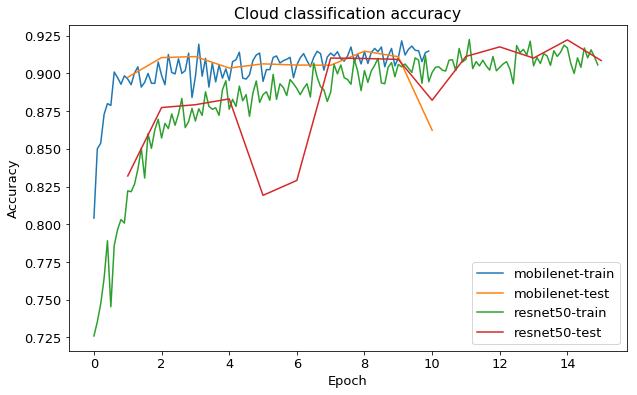

In [17]:
x = np.linspace(0, 20, 201)
plt.plot(x[:len(mobilenet_acc['train'])],          mobilenet_acc['train'], label='mobilenet-train')
plt.plot(x[::10][1:len(mobilenet_acc['valid'])+1], mobilenet_acc['valid'], label='mobilenet-validation')
plt.plot(x[:len(resnet_acc['train'])],          resnet_acc['train'], label='resnet50-train')
plt.plot(x[::10][1:len(resnet_acc['valid'])+1], resnet_acc['valid'], label='resnet50-validation')
plt.title('Cloud classification accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams.update({'font.size': 13})
plt.show()

Best test accuracy is obtained with ResNet50 after 14 epochs, so let us load the params of the network at that point.

In [7]:
rn50 = vision.resnet50_v2(classes=4)
rn50.load_params(os.path.join(checkpoints, '14-900.params'),ctx)

#### b) Confusion matrix

Utility functions to get predictions and generate the confusion matrix

In [29]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def get_predictions(data_iterator, net):
    preds = []
    labels= []

    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        data = color_normalize(data/255, mean, std)
        output = net(data)
        prediction = mx.nd.argmax(output, axis=1)
        preds.extend(prediction)
        labels.extend(label)
    
    preds = [j.asscalar() for i in preds for j in i]
    labels =[j.asscalar() for i in labels for j in i]
    
    return preds, labels

First, lets check the performance on the validation dataset

In [19]:
preds, labels = get_predictions(gluon.data.DataLoader(validIterator, 32), rn50)

Normalized confusion matrix
[[0.97621393 0.01674877 0.00548909 0.00154821]
 [0.24017467 0.65793304 0.04949054 0.05240175]
 [0.16141304 0.01576087 0.81847826 0.00434783]
 [0.10655738 0.08401639 0.1557377  0.65368852]]


array([[6936,  119,   39,   11],
       [ 165,  452,   34,   36],
       [ 297,   29, 1506,    8],
       [  52,   41,   76,  319]])

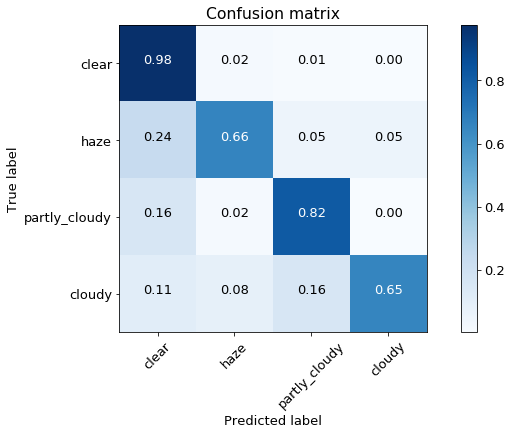

In [20]:
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, ['clear', 'haze', 'partly_cloudy', 'cloudy'], normalize=True)
cm

Our dataset is very imbalanced, and the network is too biased towards 'clear'. Lets try to find a solution to this problem.

##  Rebalancing classes

The main goal of this classifier is to identify those images which can safely be used for the segmentation system. This means distinguishing between clear and cloudy scenes, where *cloudy* can refer to any of the three non-clear classes in our dataset. Thus, let us try grouping those three classes into one to mitigate a bit the class imbalance.

First, load the new training and validation datasets, now with only two classes:

In [13]:
train_bin = os.path.join(DATA_DIR, 'train/clouds-binary.rec')
valid_bin = os.path.join(DATA_DIR, 'valid/clouds-binary.rec')

trainIterBin = ImageRecordDataset(
    filename=train_bin, 
    transform=lambda X, y: transform(X, y, train_augs)
)
validIterBin = ImageRecordDataset(
    filename=valid_bin, 
    transform=lambda X, y: transform(X, y, train_augs)
)

We'll need a slightly modified version of the train utility function to deal with the binary case

In [27]:
def train_binary(net, ctx, batch_size=32, epochs=10, learning_rate=0.01, wd=0.001, momentum=0,
          checkpoint_dir='checkpoints', params=None, init_epoch=0):
    train_data = gluon.data.DataLoader(
        trainIterBin, batch_size, shuffle=True)
    
    valid_data = gluon.data.DataLoader(
        validIterBin, batch_size)
    
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params() if not params else params, 'adam', 
            {'learning_rate': learning_rate})
    
    return train_util(net, train_data, valid_data, 
               loss, trainer, ctx, epochs, batch_size,
               checkpoint_dir, init_epoch=init_epoch)

Load a new ResNet, as it was the best performing network from the previous case.

In [26]:
checkpoints = os.path.join(CHECKPOINTS_DIR, 'resnet50-bin')
os.makedirs(checkpoints, exist_ok=True)

# Load a new pretrained network so the prefix gets updated
pretrained_resnet = vision.resnet50_v2(pretrained=True) 

# Load the network to train, using the same prefix to avoid problems when saving and loading params,
# as we will assign the features part of the pretrained network to this one
rn50bin = vision.resnet50_v2(classes=2, prefix=pretrained_resnet.prefix)
rn50bin.features = pretrained_resnet.features
rn50bin.output.initialize(mx.init.Xavier())

Train the network and save the results

In [28]:
rn50bin_acc = train_binary(rn50bin, ctx, batch_size=32, epochs=30, learning_rate=0.003,checkpoint_dir=checkpoints)

# Save
np.save(checkpoints + '/accuracy-results.npy', rn50bin_acc)

[Epoch 1 Batch 0] speed: 18.181882 samples/s, training: accuracy=0.250000
[Epoch 1 Batch 5] speed: 613.928799 samples/s, training: accuracy=0.637500
[Epoch 1 Batch 10] speed: 610.280310 samples/s, training: accuracy=0.700000
[Epoch 1 Batch 15] speed: 616.619552 samples/s, training: accuracy=0.685417
[Epoch 1 Batch 20] speed: 618.044934 samples/s, training: accuracy=0.695312
[Epoch 1 Batch 25] speed: 604.097273 samples/s, training: accuracy=0.698750
[Epoch 1 Batch 30] speed: 627.807585 samples/s, training: accuracy=0.714583
[Epoch 1 Batch 35] speed: 617.413774 samples/s, training: accuracy=0.729464
[Epoch 1 Batch 40] speed: 608.534351 samples/s, training: accuracy=0.742969
[Epoch 1 Batch 45] speed: 615.847151 samples/s, training: accuracy=0.753472
[Epoch 1 Batch 50] speed: 634.419210 samples/s, training: accuracy=0.757500
[Epoch 1 Batch 55] speed: 618.335359 samples/s, training: accuracy=0.760227
[Epoch 1 Batch 60] speed: 606.239230 samples/s, training: accuracy=0.760938
[Epoch 1 Batch 

[Epoch 1 Batch 535] speed: 608.705461 samples/s, training: accuracy=0.848214
[Epoch 1 Batch 540] speed: 608.934677 samples/s, training: accuracy=0.850781
[Epoch 1 Batch 545] speed: 614.479698 samples/s, training: accuracy=0.851389
[Epoch 1 Batch 550] speed: 615.175352 samples/s, training: accuracy=0.851250
[Epoch 1 Batch 555] speed: 619.282558 samples/s, training: accuracy=0.852841
[Epoch 1 Batch 560] speed: 610.560705 samples/s, training: accuracy=0.851562
[Epoch 1 Batch 565] speed: 614.986497 samples/s, training: accuracy=0.856250
[Epoch 1 Batch 570] speed: 625.196119 samples/s, training: accuracy=0.856250
[Epoch 1 Batch 575] speed: 527.981810 samples/s, training: accuracy=0.857083
[Epoch 1 Batch 580] speed: 625.522457 samples/s, training: accuracy=0.857812
[Epoch 1 Batch 585] speed: 606.652992 samples/s, training: accuracy=0.856985
[Epoch 1 Batch 590] speed: 583.157271 samples/s, training: accuracy=0.856250
[Epoch 1 Batch 595] speed: 620.637054 samples/s, training: accuracy=0.857237

[Epoch 2 Batch 115] speed: 586.774948 samples/s, training: accuracy=0.889583
[Epoch 2 Batch 120] speed: 610.766306 samples/s, training: accuracy=0.890625
[Epoch 2 Batch 125] speed: 609.772924 samples/s, training: accuracy=0.892500
[Epoch 2 Batch 130] speed: 618.569036 samples/s, training: accuracy=0.889583
[Epoch 2 Batch 135] speed: 613.942840 samples/s, training: accuracy=0.890179
[Epoch 2 Batch 140] speed: 614.038338 samples/s, training: accuracy=0.883594
[Epoch 2 Batch 145] speed: 607.768300 samples/s, training: accuracy=0.884028
[Epoch 2 Batch 150] speed: 620.528017 samples/s, training: accuracy=0.883125
[Epoch 2 Batch 155] speed: 620.559576 samples/s, training: accuracy=0.884659
[Epoch 2 Batch 160] speed: 611.537152 samples/s, training: accuracy=0.881771
[Epoch 2 Batch 165] speed: 571.044499 samples/s, training: accuracy=0.883173
[Epoch 2 Batch 170] speed: 610.122181 samples/s, training: accuracy=0.882143
[Epoch 2 Batch 175] speed: 630.544621 samples/s, training: accuracy=0.882917

[Epoch 2 Batch 650] speed: 618.059164 samples/s, training: accuracy=0.885000
[Epoch 2 Batch 655] speed: 617.572864 samples/s, training: accuracy=0.885795
[Epoch 2 Batch 660] speed: 617.587072 samples/s, training: accuracy=0.884896
[Epoch 2 Batch 665] speed: 614.561292 samples/s, training: accuracy=0.883654
[Epoch 2 Batch 670] speed: 625.647838 samples/s, training: accuracy=0.882589
[Epoch 2 Batch 675] speed: 635.961317 samples/s, training: accuracy=0.880833
[Epoch 2 Batch 680] speed: 629.864039 samples/s, training: accuracy=0.879297
[Epoch 2 Batch 685] speed: 636.377433 samples/s, training: accuracy=0.876838
[Epoch 2 Batch 690] speed: 613.535904 samples/s, training: accuracy=0.878125
[Epoch 2 Batch 695] speed: 613.634081 samples/s, training: accuracy=0.875987
[Epoch 2 Batch 700] speed: 607.457470 samples/s, training: accuracy=0.875625
[Epoch 2 Batch 705] speed: 612.692881 samples/s, training: accuracy=0.900000
[Epoch 2 Batch 710] speed: 593.531835 samples/s, training: accuracy=0.890625

[Epoch 3 Batch 230] speed: 614.763965 samples/s, training: accuracy=0.892708
[Epoch 3 Batch 235] speed: 616.517586 samples/s, training: accuracy=0.890179
[Epoch 3 Batch 240] speed: 616.888791 samples/s, training: accuracy=0.878906
[Epoch 3 Batch 245] speed: 603.828215 samples/s, training: accuracy=0.882639
[Epoch 3 Batch 250] speed: 606.973979 samples/s, training: accuracy=0.883125
[Epoch 3 Batch 255] speed: 604.676969 samples/s, training: accuracy=0.884659
[Epoch 3 Batch 260] speed: 608.418493 samples/s, training: accuracy=0.885417
[Epoch 3 Batch 265] speed: 595.456706 samples/s, training: accuracy=0.887981
[Epoch 3 Batch 270] speed: 615.003405 samples/s, training: accuracy=0.883482
[Epoch 3 Batch 275] speed: 605.506257 samples/s, training: accuracy=0.882500
[Epoch 3 Batch 280] speed: 607.092033 samples/s, training: accuracy=0.878906
[Epoch 3 Batch 285] speed: 616.251500 samples/s, training: accuracy=0.878309
[Epoch 3 Batch 290] speed: 595.395953 samples/s, training: accuracy=0.881597

[Epoch 3 Batch 765] speed: 613.566757 samples/s, training: accuracy=0.895673
[Epoch 3 Batch 770] speed: 595.906142 samples/s, training: accuracy=0.893304
[Epoch 3 Batch 775] speed: 591.674137 samples/s, training: accuracy=0.892917
[Epoch 3 Batch 780] speed: 621.954254 samples/s, training: accuracy=0.892969
[Epoch 3 Batch 785] speed: 599.419096 samples/s, training: accuracy=0.891544
[Epoch 3 Batch 790] speed: 613.121105 samples/s, training: accuracy=0.891319
[Epoch 3 Batch 795] speed: 604.301264 samples/s, training: accuracy=0.890461
[Epoch 3 Batch 800] speed: 623.688327 samples/s, training: accuracy=0.891875
[Epoch 3 Batch 805] speed: 616.531746 samples/s, training: accuracy=0.918750
[Epoch 3 Batch 810] speed: 610.424639 samples/s, training: accuracy=0.915625
[Epoch 3 Batch 815] speed: 610.616259 samples/s, training: accuracy=0.916667
[Epoch 3 Batch 820] speed: 608.694419 samples/s, training: accuracy=0.917188
[Epoch 3 Batch 825] speed: 600.389746 samples/s, training: accuracy=0.915000

[Epoch 4 Batch 345] speed: 588.883454 samples/s, training: accuracy=0.920833
[Epoch 4 Batch 350] speed: 590.705443 samples/s, training: accuracy=0.920000
[Epoch 4 Batch 355] speed: 600.852041 samples/s, training: accuracy=0.920455
[Epoch 4 Batch 360] speed: 605.440704 samples/s, training: accuracy=0.918229
[Epoch 4 Batch 365] speed: 607.424480 samples/s, training: accuracy=0.919712
[Epoch 4 Batch 370] speed: 612.150764 samples/s, training: accuracy=0.920536
[Epoch 4 Batch 375] speed: 624.974869 samples/s, training: accuracy=0.918333
[Epoch 4 Batch 380] speed: 612.170309 samples/s, training: accuracy=0.918359
[Epoch 4 Batch 385] speed: 596.669088 samples/s, training: accuracy=0.916544
[Epoch 4 Batch 390] speed: 595.617896 samples/s, training: accuracy=0.915278
[Epoch 4 Batch 395] speed: 599.009792 samples/s, training: accuracy=0.916118
[Epoch 4 Batch 400] speed: 601.770676 samples/s, training: accuracy=0.915312
[Epoch 4 Batch 405] speed: 538.866875 samples/s, training: accuracy=0.868750

[Epoch 4 Batch 880] speed: 612.217778 samples/s, training: accuracy=0.916797
[Epoch 4 Batch 885] speed: 613.763161 samples/s, training: accuracy=0.917279
[Epoch 4 Batch 890] speed: 619.894641 samples/s, training: accuracy=0.919444
[Epoch 4 Batch 895] speed: 630.369897 samples/s, training: accuracy=0.917434
[Epoch 4 Batch 900] speed: 620.212600 samples/s, training: accuracy=0.918125
[Epoch 4 Batch 905] speed: 604.532621 samples/s, training: accuracy=0.931250
[Epoch 4 Batch 910] speed: 604.208771 samples/s, training: accuracy=0.934375
[Epoch 4 Batch 915] speed: 612.036316 samples/s, training: accuracy=0.931250
[Epoch 4 Batch 920] speed: 603.616399 samples/s, training: accuracy=0.934375
[Epoch 4 Batch 925] speed: 612.936308 samples/s, training: accuracy=0.930000
[Epoch 4 Batch 930] speed: 371.406393 samples/s, training: accuracy=0.923958
[Epoch 4 Batch 935] speed: 605.203194 samples/s, training: accuracy=0.916964
[Epoch 4 Batch 940] speed: 598.536980 samples/s, training: accuracy=0.919531

[Epoch 5 Batch 460] speed: 613.827721 samples/s, training: accuracy=0.901042
[Epoch 5 Batch 465] speed: 608.382641 samples/s, training: accuracy=0.898077
[Epoch 5 Batch 470] speed: 613.979351 samples/s, training: accuracy=0.901339
[Epoch 5 Batch 475] speed: 617.433655 samples/s, training: accuracy=0.901250
[Epoch 5 Batch 480] speed: 617.268959 samples/s, training: accuracy=0.902734
[Epoch 5 Batch 485] speed: 617.763311 samples/s, training: accuracy=0.905147
[Epoch 5 Batch 490] speed: 610.771865 samples/s, training: accuracy=0.906250
[Epoch 5 Batch 495] speed: 601.228853 samples/s, training: accuracy=0.906579
[Epoch 5 Batch 500] speed: 609.991856 samples/s, training: accuracy=0.906875
[Epoch 5 Batch 505] speed: 629.979338 samples/s, training: accuracy=0.837500
[Epoch 5 Batch 510] speed: 537.918778 samples/s, training: accuracy=0.865625
[Epoch 5 Batch 515] speed: 609.194481 samples/s, training: accuracy=0.868750
[Epoch 5 Batch 520] speed: 611.308757 samples/s, training: accuracy=0.879687

[Epoch 6 Batch 40] speed: 601.954200 samples/s, training: accuracy=0.921875
[Epoch 6 Batch 45] speed: 605.053140 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 50] speed: 569.815357 samples/s, training: accuracy=0.918125
[Epoch 6 Batch 55] speed: 614.969590 samples/s, training: accuracy=0.919318
[Epoch 6 Batch 60] speed: 596.568310 samples/s, training: accuracy=0.919271
[Epoch 6 Batch 65] speed: 616.056328 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 70] speed: 610.127728 samples/s, training: accuracy=0.920089
[Epoch 6 Batch 75] speed: 626.319334 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 80] speed: 598.654445 samples/s, training: accuracy=0.917188
[Epoch 6 Batch 85] speed: 592.619846 samples/s, training: accuracy=0.917647
[Epoch 6 Batch 90] speed: 629.114144 samples/s, training: accuracy=0.914931
[Epoch 6 Batch 95] speed: 613.586391 samples/s, training: accuracy=0.915789
[Epoch 6 Batch 100] speed: 607.955501 samples/s, training: accuracy=0.915625
[Epoch 6 Ba

[Epoch 6 Batch 575] speed: 603.608255 samples/s, training: accuracy=0.919583
[Epoch 6 Batch 580] speed: 610.180430 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 585] speed: 604.562574 samples/s, training: accuracy=0.915074
[Epoch 6 Batch 590] speed: 615.581643 samples/s, training: accuracy=0.916667
[Epoch 6 Batch 595] speed: 610.230366 samples/s, training: accuracy=0.915789
[Epoch 6 Batch 600] speed: 604.546236 samples/s, training: accuracy=0.915000
[Epoch 6 Batch 605] speed: 620.347330 samples/s, training: accuracy=0.881250
[Epoch 6 Batch 610] speed: 621.617233 samples/s, training: accuracy=0.887500
[Epoch 6 Batch 615] speed: 604.352964 samples/s, training: accuracy=0.904167
[Epoch 6 Batch 620] speed: 611.425718 samples/s, training: accuracy=0.903125
[Epoch 6 Batch 625] speed: 626.436263 samples/s, training: accuracy=0.910000
[Epoch 6 Batch 630] speed: 605.664735 samples/s, training: accuracy=0.914583
[Epoch 6 Batch 635] speed: 612.446854 samples/s, training: accuracy=0.919643

[Epoch 7 Batch 155] speed: 595.277122 samples/s, training: accuracy=0.919318
[Epoch 7 Batch 160] speed: 608.007828 samples/s, training: accuracy=0.916146
[Epoch 7 Batch 165] speed: 613.869833 samples/s, training: accuracy=0.912019
[Epoch 7 Batch 170] speed: 594.520363 samples/s, training: accuracy=0.913393
[Epoch 7 Batch 175] speed: 611.222456 samples/s, training: accuracy=0.912083
[Epoch 7 Batch 180] speed: 620.307192 samples/s, training: accuracy=0.912500
[Epoch 7 Batch 185] speed: 587.599557 samples/s, training: accuracy=0.914338
[Epoch 7 Batch 190] speed: 616.118544 samples/s, training: accuracy=0.914583
[Epoch 7 Batch 195] speed: 611.283699 samples/s, training: accuracy=0.914803
[Epoch 7 Batch 200] speed: 601.118452 samples/s, training: accuracy=0.914687
[Epoch 7 Batch 205] speed: 591.064427 samples/s, training: accuracy=0.950000
[Epoch 7 Batch 210] speed: 595.884977 samples/s, training: accuracy=0.940625
[Epoch 7 Batch 215] speed: 577.479253 samples/s, training: accuracy=0.925000

[Epoch 7 Batch 690] speed: 611.041584 samples/s, training: accuracy=0.925347
[Epoch 7 Batch 695] speed: 514.161430 samples/s, training: accuracy=0.925329
[Epoch 7 Batch 700] speed: 470.137688 samples/s, training: accuracy=0.925937
[Epoch 7 Batch 705] speed: 621.743933 samples/s, training: accuracy=0.931250
[Epoch 7 Batch 710] speed: 602.602829 samples/s, training: accuracy=0.921875
[Epoch 7 Batch 715] speed: 611.528793 samples/s, training: accuracy=0.927083
[Epoch 7 Batch 720] speed: 590.333912 samples/s, training: accuracy=0.926562
[Epoch 7 Batch 725] speed: 605.375166 samples/s, training: accuracy=0.926250
[Epoch 7 Batch 730] speed: 560.562527 samples/s, training: accuracy=0.923958
[Epoch 7 Batch 735] speed: 609.067315 samples/s, training: accuracy=0.924107
[Epoch 7 Batch 740] speed: 601.274641 samples/s, training: accuracy=0.922656
[Epoch 7 Batch 745] speed: 616.376022 samples/s, training: accuracy=0.925000
[Epoch 7 Batch 750] speed: 602.308070 samples/s, training: accuracy=0.925625

[Epoch 8 Batch 270] speed: 606.022982 samples/s, training: accuracy=0.935714
[Epoch 8 Batch 275] speed: 629.255720 samples/s, training: accuracy=0.936667
[Epoch 8 Batch 280] speed: 610.977608 samples/s, training: accuracy=0.934375
[Epoch 8 Batch 285] speed: 608.912577 samples/s, training: accuracy=0.934191
[Epoch 8 Batch 290] speed: 606.318650 samples/s, training: accuracy=0.933681
[Epoch 8 Batch 295] speed: 594.804910 samples/s, training: accuracy=0.932237
[Epoch 8 Batch 300] speed: 610.424639 samples/s, training: accuracy=0.930000
[Epoch 8 Batch 305] speed: 604.113587 samples/s, training: accuracy=0.868750
[Epoch 8 Batch 310] speed: 611.676501 samples/s, training: accuracy=0.912500
[Epoch 8 Batch 315] speed: 629.766510 samples/s, training: accuracy=0.922917
[Epoch 8 Batch 320] speed: 606.814815 samples/s, training: accuracy=0.934375
[Epoch 8 Batch 325] speed: 600.357519 samples/s, training: accuracy=0.938750
[Epoch 8 Batch 330] speed: 610.707945 samples/s, training: accuracy=0.933333

[Epoch 8 Batch 805] speed: 614.817471 samples/s, training: accuracy=0.918750
[Epoch 8 Batch 810] speed: 620.703068 samples/s, training: accuracy=0.915625
[Epoch 8 Batch 815] speed: 614.409375 samples/s, training: accuracy=0.914583
[Epoch 8 Batch 820] speed: 610.571815 samples/s, training: accuracy=0.915625
[Epoch 8 Batch 825] speed: 630.109471 samples/s, training: accuracy=0.921250
[Epoch 8 Batch 830] speed: 619.019790 samples/s, training: accuracy=0.919792
[Epoch 8 Batch 835] speed: 600.271598 samples/s, training: accuracy=0.918750
[Epoch 8 Batch 840] speed: 611.782449 samples/s, training: accuracy=0.920312
[Epoch 8 Batch 845] speed: 632.410419 samples/s, training: accuracy=0.920139
[Epoch 8 Batch 850] speed: 606.510441 samples/s, training: accuracy=0.916250
[Epoch 8 Batch 855] speed: 598.056919 samples/s, training: accuracy=0.918750
[Epoch 8 Batch 860] speed: 609.747992 samples/s, training: accuracy=0.917188
[Epoch 8 Batch 865] speed: 601.943401 samples/s, training: accuracy=0.920192

[Epoch 9 Batch 385] speed: 614.583805 samples/s, training: accuracy=0.921691
[Epoch 9 Batch 390] speed: 623.792679 samples/s, training: accuracy=0.921181
[Epoch 9 Batch 395] speed: 613.527491 samples/s, training: accuracy=0.922368
[Epoch 9 Batch 400] speed: 623.172877 samples/s, training: accuracy=0.923125
[Epoch 9 Batch 405] speed: 596.836243 samples/s, training: accuracy=0.937500
[Epoch 9 Batch 410] speed: 608.490210 samples/s, training: accuracy=0.918750
[Epoch 9 Batch 415] speed: 615.530828 samples/s, training: accuracy=0.929167
[Epoch 9 Batch 420] speed: 605.943639 samples/s, training: accuracy=0.937500
[Epoch 9 Batch 425] speed: 616.059156 samples/s, training: accuracy=0.935000
[Epoch 9 Batch 430] speed: 608.465383 samples/s, training: accuracy=0.938542
[Epoch 9 Batch 435] speed: 593.820692 samples/s, training: accuracy=0.944643
[Epoch 9 Batch 440] speed: 619.677127 samples/s, training: accuracy=0.940625
[Epoch 9 Batch 445] speed: 612.891525 samples/s, training: accuracy=0.941667

[Epoch 9 Batch 920] speed: 609.847731 samples/s, training: accuracy=0.932813
[Epoch 9 Batch 925] speed: 612.418909 samples/s, training: accuracy=0.927500
[Epoch 9 Batch 930] speed: 606.562519 samples/s, training: accuracy=0.928125
[Epoch 9 Batch 935] speed: 624.053712 samples/s, training: accuracy=0.927679
[Epoch 9 Batch 940] speed: 607.490463 samples/s, training: accuracy=0.928125
[Epoch 9 Batch 945] speed: 600.556305 samples/s, training: accuracy=0.928472
Epoch 9 | training_acc [0.9259501965923984] | val_acc 0.9275691699604743 
[Epoch 10 Batch 0] speed: 572.642760 samples/s, training: accuracy=0.843750
[Epoch 10 Batch 5] speed: 615.725667 samples/s, training: accuracy=0.918750
[Epoch 10 Batch 10] speed: 605.547235 samples/s, training: accuracy=0.925000
[Epoch 10 Batch 15] speed: 612.223364 samples/s, training: accuracy=0.927083
[Epoch 10 Batch 20] speed: 606.795611 samples/s, training: accuracy=0.929688
[Epoch 10 Batch 25] speed: 611.913541 samples/s, training: accuracy=0.930000
[Epo

[Epoch 10 Batch 495] speed: 611.052711 samples/s, training: accuracy=0.922368
[Epoch 10 Batch 500] speed: 585.451694 samples/s, training: accuracy=0.923438
[Epoch 10 Batch 505] speed: 625.292237 samples/s, training: accuracy=0.925000
[Epoch 10 Batch 510] speed: 616.571397 samples/s, training: accuracy=0.906250
[Epoch 10 Batch 515] speed: 632.610129 samples/s, training: accuracy=0.906250
[Epoch 10 Batch 520] speed: 617.107189 samples/s, training: accuracy=0.917188
[Epoch 10 Batch 525] speed: 635.175800 samples/s, training: accuracy=0.921250
[Epoch 10 Batch 530] speed: 618.651720 samples/s, training: accuracy=0.921875
[Epoch 10 Batch 535] speed: 608.824190 samples/s, training: accuracy=0.925893
[Epoch 10 Batch 540] speed: 604.053773 samples/s, training: accuracy=0.928125
[Epoch 10 Batch 545] speed: 614.907607 samples/s, training: accuracy=0.925000
[Epoch 10 Batch 550] speed: 608.534351 samples/s, training: accuracy=0.925625
[Epoch 10 Batch 555] speed: 613.154717 samples/s, training: accu

[Epoch 11 Batch 70] speed: 623.294424 samples/s, training: accuracy=0.922321
[Epoch 11 Batch 75] speed: 605.730337 samples/s, training: accuracy=0.923333
[Epoch 11 Batch 80] speed: 613.157518 samples/s, training: accuracy=0.923828
[Epoch 11 Batch 85] speed: 604.810483 samples/s, training: accuracy=0.922794
[Epoch 11 Batch 90] speed: 615.784990 samples/s, training: accuracy=0.920139
[Epoch 11 Batch 95] speed: 611.442431 samples/s, training: accuracy=0.921053
[Epoch 11 Batch 100] speed: 610.805219 samples/s, training: accuracy=0.920625
[Epoch 11 Batch 105] speed: 610.333038 samples/s, training: accuracy=0.925000
[Epoch 11 Batch 110] speed: 612.606190 samples/s, training: accuracy=0.928125
[Epoch 11 Batch 115] speed: 614.797757 samples/s, training: accuracy=0.937500
[Epoch 11 Batch 120] speed: 592.860674 samples/s, training: accuracy=0.928125
[Epoch 11 Batch 125] speed: 609.263615 samples/s, training: accuracy=0.923750
[Epoch 11 Batch 130] speed: 630.846915 samples/s, training: accuracy=0

[Epoch 11 Batch 600] speed: 614.412188 samples/s, training: accuracy=0.926250
[Epoch 11 Batch 605] speed: 606.609123 samples/s, training: accuracy=0.900000
[Epoch 11 Batch 610] speed: 624.835213 samples/s, training: accuracy=0.928125
[Epoch 11 Batch 615] speed: 589.167803 samples/s, training: accuracy=0.927083
[Epoch 11 Batch 620] speed: 579.346263 samples/s, training: accuracy=0.925000
[Epoch 11 Batch 625] speed: 631.188085 samples/s, training: accuracy=0.925000
[Epoch 11 Batch 630] speed: 621.689215 samples/s, training: accuracy=0.922917
[Epoch 11 Batch 635] speed: 621.686335 samples/s, training: accuracy=0.921429
[Epoch 11 Batch 640] speed: 616.673381 samples/s, training: accuracy=0.923438
[Epoch 11 Batch 645] speed: 606.718808 samples/s, training: accuracy=0.924306
[Epoch 11 Batch 650] speed: 597.921042 samples/s, training: accuracy=0.921250
[Epoch 11 Batch 655] speed: 599.175586 samples/s, training: accuracy=0.923864
[Epoch 11 Batch 660] speed: 613.535904 samples/s, training: accu

[Epoch 12 Batch 175] speed: 627.165130 samples/s, training: accuracy=0.927500
[Epoch 12 Batch 180] speed: 609.844960 samples/s, training: accuracy=0.930078
[Epoch 12 Batch 185] speed: 616.030880 samples/s, training: accuracy=0.931250
[Epoch 12 Batch 190] speed: 610.632927 samples/s, training: accuracy=0.931250
[Epoch 12 Batch 195] speed: 603.765741 samples/s, training: accuracy=0.928947
[Epoch 12 Batch 200] speed: 617.305866 samples/s, training: accuracy=0.928438
[Epoch 12 Batch 205] speed: 604.440057 samples/s, training: accuracy=0.950000
[Epoch 12 Batch 210] speed: 604.764155 samples/s, training: accuracy=0.965625
[Epoch 12 Batch 215] speed: 563.528043 samples/s, training: accuracy=0.958333
[Epoch 12 Batch 220] speed: 611.158443 samples/s, training: accuracy=0.951562
[Epoch 12 Batch 225] speed: 616.160970 samples/s, training: accuracy=0.950000
[Epoch 12 Batch 230] speed: 604.750531 samples/s, training: accuracy=0.948958
[Epoch 12 Batch 235] speed: 614.015865 samples/s, training: accu

[Epoch 12 Batch 705] speed: 605.869787 samples/s, training: accuracy=0.900000
[Epoch 12 Batch 710] speed: 608.810382 samples/s, training: accuracy=0.928125
[Epoch 12 Batch 715] speed: 600.191070 samples/s, training: accuracy=0.929167
[Epoch 12 Batch 720] speed: 608.388157 samples/s, training: accuracy=0.920312
[Epoch 12 Batch 725] speed: 615.288157 samples/s, training: accuracy=0.925000
[Epoch 12 Batch 730] speed: 591.142525 samples/s, training: accuracy=0.927083
[Epoch 12 Batch 735] speed: 615.429221 samples/s, training: accuracy=0.930357
[Epoch 12 Batch 740] speed: 611.331032 samples/s, training: accuracy=0.935156
[Epoch 12 Batch 745] speed: 614.685132 samples/s, training: accuracy=0.934722
[Epoch 12 Batch 750] speed: 608.603336 samples/s, training: accuracy=0.936250
[Epoch 12 Batch 755] speed: 602.262124 samples/s, training: accuracy=0.932955
[Epoch 12 Batch 760] speed: 605.752207 samples/s, training: accuracy=0.930208
[Epoch 12 Batch 765] speed: 613.401313 samples/s, training: accu

[Epoch 13 Batch 280] speed: 569.832291 samples/s, training: accuracy=0.932031
[Epoch 13 Batch 285] speed: 603.342345 samples/s, training: accuracy=0.931250
[Epoch 13 Batch 290] speed: 603.757593 samples/s, training: accuracy=0.931250
[Epoch 13 Batch 295] speed: 611.626328 samples/s, training: accuracy=0.932895
[Epoch 13 Batch 300] speed: 622.092625 samples/s, training: accuracy=0.931875
[Epoch 13 Batch 305] speed: 570.903619 samples/s, training: accuracy=0.937500
[Epoch 13 Batch 310] speed: 628.598523 samples/s, training: accuracy=0.943750
[Epoch 13 Batch 315] speed: 613.292002 samples/s, training: accuracy=0.943750
[Epoch 13 Batch 320] speed: 607.952747 samples/s, training: accuracy=0.940625
[Epoch 13 Batch 325] speed: 617.510354 samples/s, training: accuracy=0.930000
[Epoch 13 Batch 330] speed: 615.152796 samples/s, training: accuracy=0.929167
[Epoch 13 Batch 335] speed: 606.688641 samples/s, training: accuracy=0.930357
[Epoch 13 Batch 340] speed: 623.769487 samples/s, training: accu

[Epoch 13 Batch 810] speed: 614.325009 samples/s, training: accuracy=0.934375
[Epoch 13 Batch 815] speed: 597.971656 samples/s, training: accuracy=0.933333
[Epoch 13 Batch 820] speed: 616.081778 samples/s, training: accuracy=0.923438
[Epoch 13 Batch 825] speed: 616.480773 samples/s, training: accuracy=0.917500
[Epoch 13 Batch 830] speed: 606.165305 samples/s, training: accuracy=0.922917
[Epoch 13 Batch 835] speed: 626.409950 samples/s, training: accuracy=0.920536
[Epoch 13 Batch 840] speed: 616.234524 samples/s, training: accuracy=0.921094
[Epoch 13 Batch 845] speed: 613.721064 samples/s, training: accuracy=0.923611
[Epoch 13 Batch 850] speed: 615.302261 samples/s, training: accuracy=0.925625
[Epoch 13 Batch 855] speed: 612.874733 samples/s, training: accuracy=0.925000
[Epoch 13 Batch 860] speed: 616.305265 samples/s, training: accuracy=0.925000
[Epoch 13 Batch 865] speed: 621.905262 samples/s, training: accuracy=0.926442
[Epoch 13 Batch 870] speed: 612.396554 samples/s, training: accu

[Epoch 14 Batch 385] speed: 610.274760 samples/s, training: accuracy=0.931985
[Epoch 14 Batch 390] speed: 604.813209 samples/s, training: accuracy=0.931597
[Epoch 14 Batch 395] speed: 613.608833 samples/s, training: accuracy=0.931908
[Epoch 14 Batch 400] speed: 612.497162 samples/s, training: accuracy=0.932187
[Epoch 14 Batch 405] speed: 622.999322 samples/s, training: accuracy=0.943750
[Epoch 14 Batch 410] speed: 608.954017 samples/s, training: accuracy=0.937500
[Epoch 14 Batch 415] speed: 612.748824 samples/s, training: accuracy=0.939583
[Epoch 14 Batch 420] speed: 601.894812 samples/s, training: accuracy=0.937500
[Epoch 14 Batch 425] speed: 606.877922 samples/s, training: accuracy=0.935000
[Epoch 14 Batch 430] speed: 623.028241 samples/s, training: accuracy=0.933333
[Epoch 14 Batch 435] speed: 616.455290 samples/s, training: accuracy=0.935714
[Epoch 14 Batch 440] speed: 609.964134 samples/s, training: accuracy=0.935937
[Epoch 14 Batch 445] speed: 610.016807 samples/s, training: accu

[Epoch 14 Batch 915] speed: 625.642005 samples/s, training: accuracy=0.929167
[Epoch 14 Batch 920] speed: 615.835848 samples/s, training: accuracy=0.931250
[Epoch 14 Batch 925] speed: 610.938673 samples/s, training: accuracy=0.933750
[Epoch 14 Batch 930] speed: 613.429348 samples/s, training: accuracy=0.933333
[Epoch 14 Batch 935] speed: 574.584329 samples/s, training: accuracy=0.933929
[Epoch 14 Batch 940] speed: 629.474107 samples/s, training: accuracy=0.932813
[Epoch 14 Batch 945] speed: 619.637075 samples/s, training: accuracy=0.931944
Epoch 14 | training_acc [0.9311926605504587] | val_acc 0.9357707509881423 
[Epoch 15 Batch 0] speed: 582.615555 samples/s, training: accuracy=0.968750
[Epoch 15 Batch 5] speed: 594.041462 samples/s, training: accuracy=0.956250
[Epoch 15 Batch 10] speed: 601.323130 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 15] speed: 610.424639 samples/s, training: accuracy=0.939583
[Epoch 15 Batch 20] speed: 616.305265 samples/s, training: accuracy=0.945

[Epoch 15 Batch 490] speed: 563.159183 samples/s, training: accuracy=0.938542
[Epoch 15 Batch 495] speed: 610.794100 samples/s, training: accuracy=0.937171
[Epoch 15 Batch 500] speed: 608.495727 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 505] speed: 607.108510 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 510] speed: 502.103273 samples/s, training: accuracy=0.940625
[Epoch 15 Batch 515] speed: 591.111283 samples/s, training: accuracy=0.945833
[Epoch 15 Batch 520] speed: 608.862856 samples/s, training: accuracy=0.934375
[Epoch 15 Batch 525] speed: 569.455135 samples/s, training: accuracy=0.933750
[Epoch 15 Batch 530] speed: 526.100581 samples/s, training: accuracy=0.932292
[Epoch 15 Batch 535] speed: 383.852108 samples/s, training: accuracy=0.928571
[Epoch 15 Batch 540] speed: 601.625016 samples/s, training: accuracy=0.928125
[Epoch 15 Batch 545] speed: 571.662278 samples/s, training: accuracy=0.927083
[Epoch 15 Batch 550] speed: 624.407905 samples/s, training: accu

[Epoch 16 Batch 65] speed: 597.953008 samples/s, training: accuracy=0.937500
[Epoch 16 Batch 70] speed: 605.733070 samples/s, training: accuracy=0.936607
[Epoch 16 Batch 75] speed: 615.324828 samples/s, training: accuracy=0.937083
[Epoch 16 Batch 80] speed: 625.236892 samples/s, training: accuracy=0.934766
[Epoch 16 Batch 85] speed: 622.652502 samples/s, training: accuracy=0.936029
[Epoch 16 Batch 90] speed: 612.354644 samples/s, training: accuracy=0.936806
[Epoch 16 Batch 95] speed: 627.696015 samples/s, training: accuracy=0.936513
[Epoch 16 Batch 100] speed: 625.478731 samples/s, training: accuracy=0.935000
[Epoch 16 Batch 105] speed: 593.920544 samples/s, training: accuracy=0.925000
[Epoch 16 Batch 110] speed: 627.162200 samples/s, training: accuracy=0.934375
[Epoch 16 Batch 115] speed: 615.866932 samples/s, training: accuracy=0.935417
[Epoch 16 Batch 120] speed: 620.347330 samples/s, training: accuracy=0.932813
[Epoch 16 Batch 125] speed: 617.982329 samples/s, training: accuracy=0.

[Epoch 16 Batch 595] speed: 604.105430 samples/s, training: accuracy=0.933882
[Epoch 16 Batch 600] speed: 609.839418 samples/s, training: accuracy=0.933750
[Epoch 16 Batch 605] speed: 585.737849 samples/s, training: accuracy=0.950000
[Epoch 16 Batch 610] speed: 612.597802 samples/s, training: accuracy=0.950000
[Epoch 16 Batch 615] speed: 612.390966 samples/s, training: accuracy=0.939583
[Epoch 16 Batch 620] speed: 595.234883 samples/s, training: accuracy=0.931250
[Epoch 16 Batch 625] speed: 613.048293 samples/s, training: accuracy=0.931250
[Epoch 16 Batch 630] speed: 621.240317 samples/s, training: accuracy=0.930208
[Epoch 16 Batch 635] speed: 599.424450 samples/s, training: accuracy=0.931250
[Epoch 16 Batch 640] speed: 620.075064 samples/s, training: accuracy=0.931250
[Epoch 16 Batch 645] speed: 599.255842 samples/s, training: accuracy=0.932639
[Epoch 16 Batch 650] speed: 609.169596 samples/s, training: accuracy=0.930625
[Epoch 16 Batch 655] speed: 619.051196 samples/s, training: accu

[Epoch 17 Batch 170] speed: 605.271425 samples/s, training: accuracy=0.930804
[Epoch 17 Batch 175] speed: 625.391298 samples/s, training: accuracy=0.932500
[Epoch 17 Batch 180] speed: 625.741177 samples/s, training: accuracy=0.933203
[Epoch 17 Batch 185] speed: 614.530340 samples/s, training: accuracy=0.933088
[Epoch 17 Batch 190] speed: 630.716478 samples/s, training: accuracy=0.933333
[Epoch 17 Batch 195] speed: 533.268152 samples/s, training: accuracy=0.932566
[Epoch 17 Batch 200] speed: 612.122846 samples/s, training: accuracy=0.933750
[Epoch 17 Batch 205] speed: 607.067320 samples/s, training: accuracy=0.912500
[Epoch 17 Batch 210] speed: 611.010985 samples/s, training: accuracy=0.918750
[Epoch 17 Batch 215] speed: 613.011893 samples/s, training: accuracy=0.910417
[Epoch 17 Batch 220] speed: 600.051539 samples/s, training: accuracy=0.921875
[Epoch 17 Batch 225] speed: 610.255337 samples/s, training: accuracy=0.927500
[Epoch 17 Batch 230] speed: 594.536164 samples/s, training: accu

[Epoch 17 Batch 700] speed: 609.299571 samples/s, training: accuracy=0.929063
[Epoch 17 Batch 705] speed: 626.395333 samples/s, training: accuracy=0.950000
[Epoch 17 Batch 710] speed: 607.388745 samples/s, training: accuracy=0.946875
[Epoch 17 Batch 715] speed: 608.104243 samples/s, training: accuracy=0.947917
[Epoch 17 Batch 720] speed: 589.791746 samples/s, training: accuracy=0.945312
[Epoch 17 Batch 725] speed: 621.602838 samples/s, training: accuracy=0.942500
[Epoch 17 Batch 730] speed: 612.508342 samples/s, training: accuracy=0.939583
[Epoch 17 Batch 735] speed: 614.285646 samples/s, training: accuracy=0.937500
[Epoch 17 Batch 740] speed: 596.070222 samples/s, training: accuracy=0.940625
[Epoch 17 Batch 745] speed: 614.814655 samples/s, training: accuracy=0.941667
[Epoch 17 Batch 750] speed: 617.413774 samples/s, training: accuracy=0.941875
[Epoch 17 Batch 755] speed: 596.793782 samples/s, training: accuracy=0.944318
[Epoch 17 Batch 760] speed: 608.440558 samples/s, training: accu

[Epoch 18 Batch 275] speed: 624.829396 samples/s, training: accuracy=0.937500
[Epoch 18 Batch 280] speed: 618.161640 samples/s, training: accuracy=0.939453
[Epoch 18 Batch 285] speed: 614.052384 samples/s, training: accuracy=0.938603
[Epoch 18 Batch 290] speed: 587.560972 samples/s, training: accuracy=0.938542
[Epoch 18 Batch 295] speed: 609.266380 samples/s, training: accuracy=0.939474
[Epoch 18 Batch 300] speed: 575.868743 samples/s, training: accuracy=0.939375
[Epoch 18 Batch 305] speed: 609.905927 samples/s, training: accuracy=0.918750
[Epoch 18 Batch 310] speed: 612.474801 samples/s, training: accuracy=0.925000
[Epoch 18 Batch 315] speed: 604.894982 samples/s, training: accuracy=0.933333
[Epoch 18 Batch 320] speed: 608.435042 samples/s, training: accuracy=0.940625
[Epoch 18 Batch 325] speed: 604.323031 samples/s, training: accuracy=0.940000
[Epoch 18 Batch 330] speed: 599.512806 samples/s, training: accuracy=0.937500
[Epoch 18 Batch 335] speed: 608.349551 samples/s, training: accu

[Epoch 18 Batch 805] speed: 617.172454 samples/s, training: accuracy=0.943750
[Epoch 18 Batch 810] speed: 620.596878 samples/s, training: accuracy=0.943750
[Epoch 18 Batch 815] speed: 614.634464 samples/s, training: accuracy=0.937500
[Epoch 18 Batch 820] speed: 598.956329 samples/s, training: accuracy=0.935937
[Epoch 18 Batch 825] speed: 601.029622 samples/s, training: accuracy=0.933750
[Epoch 18 Batch 830] speed: 612.427292 samples/s, training: accuracy=0.936458
[Epoch 18 Batch 835] speed: 606.184469 samples/s, training: accuracy=0.938393
[Epoch 18 Batch 840] speed: 622.127227 samples/s, training: accuracy=0.942187
[Epoch 18 Batch 845] speed: 613.583586 samples/s, training: accuracy=0.941667
[Epoch 18 Batch 850] speed: 619.817349 samples/s, training: accuracy=0.938750
[Epoch 18 Batch 855] speed: 609.850502 samples/s, training: accuracy=0.936932
[Epoch 18 Batch 860] speed: 601.487512 samples/s, training: accuracy=0.938542
[Epoch 18 Batch 865] speed: 615.920629 samples/s, training: accu

[Epoch 19 Batch 380] speed: 592.502121 samples/s, training: accuracy=0.935547
[Epoch 19 Batch 385] speed: 619.131154 samples/s, training: accuracy=0.935294
[Epoch 19 Batch 390] speed: 614.142296 samples/s, training: accuracy=0.936111
[Epoch 19 Batch 395] speed: 620.608356 samples/s, training: accuracy=0.934211
[Epoch 19 Batch 400] speed: 606.241968 samples/s, training: accuracy=0.935625
[Epoch 19 Batch 405] speed: 609.856044 samples/s, training: accuracy=0.968750
[Epoch 19 Batch 410] speed: 623.479728 samples/s, training: accuracy=0.953125
[Epoch 19 Batch 415] speed: 588.798203 samples/s, training: accuracy=0.947917
[Epoch 19 Batch 420] speed: 609.664901 samples/s, training: accuracy=0.945312
[Epoch 19 Batch 425] speed: 618.991242 samples/s, training: accuracy=0.946250
[Epoch 19 Batch 430] speed: 633.281721 samples/s, training: accuracy=0.942708
[Epoch 19 Batch 435] speed: 618.178723 samples/s, training: accuracy=0.941964
[Epoch 19 Batch 440] speed: 570.847771 samples/s, training: accu

[Epoch 19 Batch 910] speed: 609.280209 samples/s, training: accuracy=0.953125
[Epoch 19 Batch 915] speed: 615.401003 samples/s, training: accuracy=0.943750
[Epoch 19 Batch 920] speed: 598.555665 samples/s, training: accuracy=0.940625
[Epoch 19 Batch 925] speed: 617.178130 samples/s, training: accuracy=0.942500
[Epoch 19 Batch 930] speed: 624.085631 samples/s, training: accuracy=0.939583
[Epoch 19 Batch 935] speed: 606.831276 samples/s, training: accuracy=0.942857
[Epoch 19 Batch 940] speed: 618.634611 samples/s, training: accuracy=0.943750
[Epoch 19 Batch 945] speed: 605.919020 samples/s, training: accuracy=0.940278
Epoch 19 | training_acc [0.9390563564875491] | val_acc 0.9398221343873517 
[Epoch 20 Batch 0] speed: 582.800233 samples/s, training: accuracy=0.968750
[Epoch 20 Batch 5] speed: 593.046664 samples/s, training: accuracy=0.968750
[Epoch 20 Batch 10] speed: 608.338522 samples/s, training: accuracy=0.950000
[Epoch 20 Batch 15] speed: 611.038802 samples/s, training: accuracy=0.95

[Epoch 20 Batch 485] speed: 600.537495 samples/s, training: accuracy=0.933456
[Epoch 20 Batch 490] speed: 617.036263 samples/s, training: accuracy=0.934028
[Epoch 20 Batch 495] speed: 617.993710 samples/s, training: accuracy=0.933882
[Epoch 20 Batch 500] speed: 612.936308 samples/s, training: accuracy=0.934063
[Epoch 20 Batch 505] speed: 596.807050 samples/s, training: accuracy=0.956250
[Epoch 20 Batch 510] speed: 605.315101 samples/s, training: accuracy=0.950000
[Epoch 20 Batch 515] speed: 609.858815 samples/s, training: accuracy=0.939583
[Epoch 20 Batch 520] speed: 607.322784 samples/s, training: accuracy=0.937500
[Epoch 20 Batch 525] speed: 611.924700 samples/s, training: accuracy=0.936250
[Epoch 20 Batch 530] speed: 611.308757 samples/s, training: accuracy=0.933333
[Epoch 20 Batch 535] speed: 609.889298 samples/s, training: accuracy=0.934821
[Epoch 20 Batch 540] speed: 609.288507 samples/s, training: accuracy=0.933594
[Epoch 20 Batch 545] speed: 597.298396 samples/s, training: accu

[Epoch 21 Batch 60] speed: 611.771295 samples/s, training: accuracy=0.942708
[Epoch 21 Batch 65] speed: 610.102767 samples/s, training: accuracy=0.941346
[Epoch 21 Batch 70] speed: 583.646693 samples/s, training: accuracy=0.939732
[Epoch 21 Batch 75] speed: 611.539938 samples/s, training: accuracy=0.938333
[Epoch 21 Batch 80] speed: 618.064856 samples/s, training: accuracy=0.937500
[Epoch 21 Batch 85] speed: 605.798687 samples/s, training: accuracy=0.938971
[Epoch 21 Batch 90] speed: 603.537685 samples/s, training: accuracy=0.940278
[Epoch 21 Batch 95] speed: 623.824571 samples/s, training: accuracy=0.941118
[Epoch 21 Batch 100] speed: 597.410058 samples/s, training: accuracy=0.940312
[Epoch 21 Batch 105] speed: 617.462060 samples/s, training: accuracy=0.962500
[Epoch 21 Batch 110] speed: 611.857750 samples/s, training: accuracy=0.956250
[Epoch 21 Batch 115] speed: 620.175345 samples/s, training: accuracy=0.952083
[Epoch 21 Batch 120] speed: 615.688948 samples/s, training: accuracy=0.9

[Epoch 21 Batch 590] speed: 613.622859 samples/s, training: accuracy=0.944444
[Epoch 21 Batch 595] speed: 622.496559 samples/s, training: accuracy=0.943421
[Epoch 21 Batch 600] speed: 606.102346 samples/s, training: accuracy=0.944063
[Epoch 21 Batch 605] speed: 623.149731 samples/s, training: accuracy=0.931250
[Epoch 21 Batch 610] speed: 611.542725 samples/s, training: accuracy=0.928125
[Epoch 21 Batch 615] speed: 617.138401 samples/s, training: accuracy=0.927083
[Epoch 21 Batch 620] speed: 611.409007 samples/s, training: accuracy=0.932813
[Epoch 21 Batch 625] speed: 605.197736 samples/s, training: accuracy=0.933750
[Epoch 21 Batch 630] speed: 596.393354 samples/s, training: accuracy=0.935417
[Epoch 21 Batch 635] speed: 607.355763 samples/s, training: accuracy=0.935714
[Epoch 21 Batch 640] speed: 606.724293 samples/s, training: accuracy=0.935937
[Epoch 21 Batch 645] speed: 629.544968 samples/s, training: accuracy=0.933333
[Epoch 21 Batch 650] speed: 629.418020 samples/s, training: accu

[Epoch 22 Batch 165] speed: 622.308953 samples/s, training: accuracy=0.940385
[Epoch 22 Batch 170] speed: 605.768611 samples/s, training: accuracy=0.940625
[Epoch 22 Batch 175] speed: 633.966719 samples/s, training: accuracy=0.941667
[Epoch 22 Batch 180] speed: 592.177965 samples/s, training: accuracy=0.941797
[Epoch 22 Batch 185] speed: 613.681778 samples/s, training: accuracy=0.941176
[Epoch 22 Batch 190] speed: 607.506961 samples/s, training: accuracy=0.941319
[Epoch 22 Batch 195] speed: 614.535968 samples/s, training: accuracy=0.941447
[Epoch 22 Batch 200] speed: 611.197406 samples/s, training: accuracy=0.940937
[Epoch 22 Batch 205] speed: 600.655747 samples/s, training: accuracy=0.956250
[Epoch 22 Batch 210] speed: 589.191080 samples/s, training: accuracy=0.928125
[Epoch 22 Batch 215] speed: 610.491276 samples/s, training: accuracy=0.939583
[Epoch 22 Batch 220] speed: 615.124604 samples/s, training: accuracy=0.934375
[Epoch 22 Batch 225] speed: 604.712385 samples/s, training: accu

[Epoch 22 Batch 695] speed: 606.176256 samples/s, training: accuracy=0.931579
[Epoch 22 Batch 700] speed: 582.357708 samples/s, training: accuracy=0.931562
[Epoch 22 Batch 705] speed: 607.559211 samples/s, training: accuracy=0.937500
[Epoch 22 Batch 710] speed: 610.388551 samples/s, training: accuracy=0.937500
[Epoch 22 Batch 715] speed: 602.372946 samples/s, training: accuracy=0.947917
[Epoch 22 Batch 720] speed: 613.777194 samples/s, training: accuracy=0.951562
[Epoch 22 Batch 725] speed: 623.850667 samples/s, training: accuracy=0.948750
[Epoch 22 Batch 730] speed: 605.596416 samples/s, training: accuracy=0.945833
[Epoch 22 Batch 735] speed: 612.849548 samples/s, training: accuracy=0.948214
[Epoch 22 Batch 740] speed: 614.595062 samples/s, training: accuracy=0.951562
[Epoch 22 Batch 745] speed: 610.972046 samples/s, training: accuracy=0.949306
[Epoch 22 Batch 750] speed: 605.489868 samples/s, training: accuracy=0.950000
[Epoch 22 Batch 755] speed: 610.499607 samples/s, training: accu

[Epoch 23 Batch 270] speed: 603.828215 samples/s, training: accuracy=0.948214
[Epoch 23 Batch 275] speed: 610.821897 samples/s, training: accuracy=0.945417
[Epoch 23 Batch 280] speed: 605.170449 samples/s, training: accuracy=0.943750
[Epoch 23 Batch 285] speed: 615.912150 samples/s, training: accuracy=0.943750
[Epoch 23 Batch 290] speed: 609.864357 samples/s, training: accuracy=0.945139
[Epoch 23 Batch 295] speed: 576.407881 samples/s, training: accuracy=0.944737
[Epoch 23 Batch 300] speed: 611.609606 samples/s, training: accuracy=0.944375
[Epoch 23 Batch 305] speed: 608.821428 samples/s, training: accuracy=0.937500
[Epoch 23 Batch 310] speed: 609.515395 samples/s, training: accuracy=0.937500
[Epoch 23 Batch 315] speed: 617.073142 samples/s, training: accuracy=0.937500
[Epoch 23 Batch 320] speed: 560.272368 samples/s, training: accuracy=0.937500
[Epoch 23 Batch 325] speed: 606.168043 samples/s, training: accuracy=0.940000
[Epoch 23 Batch 330] speed: 626.576636 samples/s, training: accu

[Epoch 23 Batch 800] speed: 595.023776 samples/s, training: accuracy=0.940000
[Epoch 23 Batch 805] speed: 595.533327 samples/s, training: accuracy=0.918750
[Epoch 23 Batch 810] speed: 615.530828 samples/s, training: accuracy=0.915625
[Epoch 23 Batch 815] speed: 598.187526 samples/s, training: accuracy=0.916667
[Epoch 23 Batch 820] speed: 606.283045 samples/s, training: accuracy=0.920312
[Epoch 23 Batch 825] speed: 604.957690 samples/s, training: accuracy=0.922500
[Epoch 23 Batch 830] speed: 610.591258 samples/s, training: accuracy=0.921875
[Epoch 23 Batch 835] speed: 610.141596 samples/s, training: accuracy=0.925893
[Epoch 23 Batch 840] speed: 613.824914 samples/s, training: accuracy=0.926562
[Epoch 23 Batch 845] speed: 614.662612 samples/s, training: accuracy=0.924306
[Epoch 23 Batch 850] speed: 627.094804 samples/s, training: accuracy=0.927500
[Epoch 23 Batch 855] speed: 606.485775 samples/s, training: accuracy=0.929545
[Epoch 23 Batch 860] speed: 619.783003 samples/s, training: accu

[Epoch 24 Batch 375] speed: 611.578950 samples/s, training: accuracy=0.937917
[Epoch 24 Batch 380] speed: 620.639924 samples/s, training: accuracy=0.938672
[Epoch 24 Batch 385] speed: 619.162571 samples/s, training: accuracy=0.939338
[Epoch 24 Batch 390] speed: 612.463622 samples/s, training: accuracy=0.940278
[Epoch 24 Batch 395] speed: 595.750084 samples/s, training: accuracy=0.940132
[Epoch 24 Batch 400] speed: 520.728334 samples/s, training: accuracy=0.940625
[Epoch 24 Batch 405] speed: 385.509204 samples/s, training: accuracy=0.931250
[Epoch 24 Batch 410] speed: 411.052634 samples/s, training: accuracy=0.928125
[Epoch 24 Batch 415] speed: 617.732035 samples/s, training: accuracy=0.922917
[Epoch 24 Batch 420] speed: 379.925293 samples/s, training: accuracy=0.932813
[Epoch 24 Batch 425] speed: 584.365829 samples/s, training: accuracy=0.936250
[Epoch 24 Batch 430] speed: 534.106377 samples/s, training: accuracy=0.934375
[Epoch 24 Batch 435] speed: 544.816516 samples/s, training: accu

[Epoch 24 Batch 905] speed: 606.652992 samples/s, training: accuracy=0.956250
[Epoch 24 Batch 910] speed: 607.361260 samples/s, training: accuracy=0.950000
[Epoch 24 Batch 915] speed: 606.617348 samples/s, training: accuracy=0.956250
[Epoch 24 Batch 920] speed: 605.328751 samples/s, training: accuracy=0.948438
[Epoch 24 Batch 925] speed: 613.390100 samples/s, training: accuracy=0.948750
[Epoch 24 Batch 930] speed: 613.639692 samples/s, training: accuracy=0.938542
[Epoch 24 Batch 935] speed: 598.630415 samples/s, training: accuracy=0.939286
[Epoch 24 Batch 940] speed: 601.616926 samples/s, training: accuracy=0.941406
[Epoch 24 Batch 945] speed: 612.265256 samples/s, training: accuracy=0.935417
Epoch 24 | training_acc [0.9344692005242464] | val_acc 0.9437747035573123 
[Epoch 25 Batch 0] speed: 578.966401 samples/s, training: accuracy=0.968750
[Epoch 25 Batch 5] speed: 610.571815 samples/s, training: accuracy=0.912500
[Epoch 25 Batch 10] speed: 633.353442 samples/s, training: accuracy=0.9

[Epoch 25 Batch 480] speed: 591.189393 samples/s, training: accuracy=0.937500
[Epoch 25 Batch 485] speed: 615.590113 samples/s, training: accuracy=0.937132
[Epoch 25 Batch 490] speed: 609.717523 samples/s, training: accuracy=0.937847
[Epoch 25 Batch 495] speed: 609.075607 samples/s, training: accuracy=0.936842
[Epoch 25 Batch 500] speed: 613.031493 samples/s, training: accuracy=0.935937
[Epoch 25 Batch 505] speed: 604.282219 samples/s, training: accuracy=0.918750
[Epoch 25 Batch 510] speed: 611.537152 samples/s, training: accuracy=0.925000
[Epoch 25 Batch 515] speed: 606.628315 samples/s, training: accuracy=0.937500
[Epoch 25 Batch 520] speed: 605.577289 samples/s, training: accuracy=0.937500
[Epoch 25 Batch 525] speed: 618.680237 samples/s, training: accuracy=0.941250
[Epoch 25 Batch 530] speed: 606.691383 samples/s, training: accuracy=0.943750
[Epoch 25 Batch 535] speed: 604.924971 samples/s, training: accuracy=0.939286
[Epoch 25 Batch 540] speed: 628.036723 samples/s, training: accu

[Epoch 26 Batch 55] speed: 608.735829 samples/s, training: accuracy=0.938068
[Epoch 26 Batch 60] speed: 608.170374 samples/s, training: accuracy=0.938542
[Epoch 26 Batch 65] speed: 610.955359 samples/s, training: accuracy=0.937500
[Epoch 26 Batch 70] speed: 628.825292 samples/s, training: accuracy=0.935268
[Epoch 26 Batch 75] speed: 616.061984 samples/s, training: accuracy=0.935417
[Epoch 26 Batch 80] speed: 622.692944 samples/s, training: accuracy=0.935937
[Epoch 26 Batch 85] speed: 609.941959 samples/s, training: accuracy=0.936765
[Epoch 26 Batch 90] speed: 617.996556 samples/s, training: accuracy=0.937500
[Epoch 26 Batch 95] speed: 605.798687 samples/s, training: accuracy=0.938158
[Epoch 26 Batch 100] speed: 603.312512 samples/s, training: accuracy=0.939063
[Epoch 26 Batch 105] speed: 602.656944 samples/s, training: accuracy=0.968750
[Epoch 26 Batch 110] speed: 612.894324 samples/s, training: accuracy=0.968750
[Epoch 26 Batch 115] speed: 622.040729 samples/s, training: accuracy=0.95

[Epoch 26 Batch 585] speed: 605.919020 samples/s, training: accuracy=0.941176
[Epoch 26 Batch 590] speed: 580.293083 samples/s, training: accuracy=0.941667
[Epoch 26 Batch 595] speed: 606.077714 samples/s, training: accuracy=0.941118
[Epoch 26 Batch 600] speed: 618.942716 samples/s, training: accuracy=0.941562
[Epoch 26 Batch 605] speed: 612.530705 samples/s, training: accuracy=0.925000
[Epoch 26 Batch 610] speed: 611.986084 samples/s, training: accuracy=0.915625
[Epoch 26 Batch 615] speed: 617.899823 samples/s, training: accuracy=0.912500
[Epoch 26 Batch 620] speed: 577.593569 samples/s, training: accuracy=0.921875
[Epoch 26 Batch 625] speed: 595.652260 samples/s, training: accuracy=0.926250
[Epoch 26 Batch 630] speed: 613.589196 samples/s, training: accuracy=0.929167
[Epoch 26 Batch 635] speed: 611.083314 samples/s, training: accuracy=0.930357
[Epoch 26 Batch 640] speed: 605.897137 samples/s, training: accuracy=0.930469
[Epoch 26 Batch 645] speed: 616.472278 samples/s, training: accu

[Epoch 27 Batch 160] speed: 614.060812 samples/s, training: accuracy=0.933333
[Epoch 27 Batch 165] speed: 615.395360 samples/s, training: accuracy=0.933654
[Epoch 27 Batch 170] speed: 614.809022 samples/s, training: accuracy=0.933036
[Epoch 27 Batch 175] speed: 611.055493 samples/s, training: accuracy=0.935417
[Epoch 27 Batch 180] speed: 606.521404 samples/s, training: accuracy=0.935156
[Epoch 27 Batch 185] speed: 608.528833 samples/s, training: accuracy=0.933456
[Epoch 27 Batch 190] speed: 616.098746 samples/s, training: accuracy=0.931944
[Epoch 27 Batch 195] speed: 605.443436 samples/s, training: accuracy=0.931908
[Epoch 27 Batch 200] speed: 621.939844 samples/s, training: accuracy=0.930625
[Epoch 27 Batch 205] speed: 614.814655 samples/s, training: accuracy=0.918750
[Epoch 27 Batch 210] speed: 609.211071 samples/s, training: accuracy=0.921875
[Epoch 27 Batch 215] speed: 563.007995 samples/s, training: accuracy=0.920833
[Epoch 27 Batch 220] speed: 574.763950 samples/s, training: accu

[Epoch 27 Batch 690] speed: 612.961501 samples/s, training: accuracy=0.938542
[Epoch 27 Batch 695] speed: 620.502198 samples/s, training: accuracy=0.938816
[Epoch 27 Batch 700] speed: 604.557128 samples/s, training: accuracy=0.939375
[Epoch 27 Batch 705] speed: 614.170398 samples/s, training: accuracy=0.937500
[Epoch 27 Batch 710] speed: 608.865618 samples/s, training: accuracy=0.937500
[Epoch 27 Batch 715] speed: 606.710580 samples/s, training: accuracy=0.931250
[Epoch 27 Batch 720] speed: 614.893521 samples/s, training: accuracy=0.931250
[Epoch 27 Batch 725] speed: 566.690148 samples/s, training: accuracy=0.936250
[Epoch 27 Batch 730] speed: 606.173518 samples/s, training: accuracy=0.943750
[Epoch 27 Batch 735] speed: 606.897131 samples/s, training: accuracy=0.936607
[Epoch 27 Batch 740] speed: 569.271573 samples/s, training: accuracy=0.934375
[Epoch 27 Batch 745] speed: 627.220816 samples/s, training: accuracy=0.936806
[Epoch 27 Batch 750] speed: 609.576296 samples/s, training: accu

[Epoch 28 Batch 265] speed: 622.918363 samples/s, training: accuracy=0.942788
[Epoch 28 Batch 270] speed: 608.746873 samples/s, training: accuracy=0.940625
[Epoch 28 Batch 275] speed: 610.877499 samples/s, training: accuracy=0.940000
[Epoch 28 Batch 280] speed: 606.318650 samples/s, training: accuracy=0.939063
[Epoch 28 Batch 285] speed: 616.243012 samples/s, training: accuracy=0.938971
[Epoch 28 Batch 290] speed: 614.611948 samples/s, training: accuracy=0.939583
[Epoch 28 Batch 295] speed: 595.063347 samples/s, training: accuracy=0.940132
[Epoch 28 Batch 300] speed: 610.063944 samples/s, training: accuracy=0.940625
[Epoch 28 Batch 305] speed: 616.373192 samples/s, training: accuracy=0.950000
[Epoch 28 Batch 310] speed: 619.771555 samples/s, training: accuracy=0.943750
[Epoch 28 Batch 315] speed: 583.905683 samples/s, training: accuracy=0.933333
[Epoch 28 Batch 320] speed: 591.496827 samples/s, training: accuracy=0.943750
[Epoch 28 Batch 325] speed: 602.132434 samples/s, training: accu

[Epoch 28 Batch 795] speed: 601.584567 samples/s, training: accuracy=0.945066
[Epoch 28 Batch 800] speed: 627.247197 samples/s, training: accuracy=0.943750
[Epoch 28 Batch 805] speed: 609.219367 samples/s, training: accuracy=0.943750
[Epoch 28 Batch 810] speed: 628.071989 samples/s, training: accuracy=0.943750
[Epoch 28 Batch 815] speed: 608.710982 samples/s, training: accuracy=0.956250
[Epoch 28 Batch 820] speed: 622.513882 samples/s, training: accuracy=0.950000
[Epoch 28 Batch 825] speed: 609.327232 samples/s, training: accuracy=0.951250
[Epoch 28 Batch 830] speed: 609.939187 samples/s, training: accuracy=0.943750
[Epoch 28 Batch 835] speed: 604.982232 samples/s, training: accuracy=0.949107
[Epoch 28 Batch 840] speed: 614.552851 samples/s, training: accuracy=0.944531
[Epoch 28 Batch 845] speed: 611.648626 samples/s, training: accuracy=0.942361
[Epoch 28 Batch 850] speed: 633.478992 samples/s, training: accuracy=0.941875
[Epoch 28 Batch 855] speed: 610.122181 samples/s, training: accu

[Epoch 29 Batch 370] speed: 629.858127 samples/s, training: accuracy=0.943750
[Epoch 29 Batch 375] speed: 615.059770 samples/s, training: accuracy=0.942500
[Epoch 29 Batch 380] speed: 582.466380 samples/s, training: accuracy=0.942969
[Epoch 29 Batch 385] speed: 613.297607 samples/s, training: accuracy=0.941912
[Epoch 29 Batch 390] speed: 594.362398 samples/s, training: accuracy=0.940972
[Epoch 29 Batch 395] speed: 618.212891 samples/s, training: accuracy=0.940461
[Epoch 29 Batch 400] speed: 605.970997 samples/s, training: accuracy=0.940937
[Epoch 29 Batch 405] speed: 562.465335 samples/s, training: accuracy=0.943750
[Epoch 29 Batch 410] speed: 614.631650 samples/s, training: accuracy=0.931250
[Epoch 29 Batch 415] speed: 615.071045 samples/s, training: accuracy=0.939583
[Epoch 29 Batch 420] speed: 611.027675 samples/s, training: accuracy=0.932813
[Epoch 29 Batch 425] speed: 607.396991 samples/s, training: accuracy=0.940000
[Epoch 29 Batch 430] speed: 611.537152 samples/s, training: accu

[Epoch 29 Batch 900] speed: 606.343302 samples/s, training: accuracy=0.940937
[Epoch 29 Batch 905] speed: 585.530869 samples/s, training: accuracy=0.962500
[Epoch 29 Batch 910] speed: 627.405530 samples/s, training: accuracy=0.959375
[Epoch 29 Batch 915] speed: 615.130242 samples/s, training: accuracy=0.950000
[Epoch 29 Batch 920] speed: 608.984410 samples/s, training: accuracy=0.954688
[Epoch 29 Batch 925] speed: 599.874535 samples/s, training: accuracy=0.957500
[Epoch 29 Batch 930] speed: 624.855576 samples/s, training: accuracy=0.952083
[Epoch 29 Batch 935] speed: 610.757968 samples/s, training: accuracy=0.953571
[Epoch 29 Batch 940] speed: 612.360232 samples/s, training: accuracy=0.953906
[Epoch 29 Batch 945] speed: 623.711513 samples/s, training: accuracy=0.953472
Epoch 29 | training_acc [0.9508519003931848] | val_acc 0.9476284584980237 
[Epoch 30 Batch 0] speed: 580.032274 samples/s, training: accuracy=0.875000
[Epoch 30 Batch 5] speed: 629.152481 samples/s, training: accuracy=0.

[Epoch 30 Batch 475] speed: 604.941330 samples/s, training: accuracy=0.937500
[Epoch 30 Batch 480] speed: 613.331237 samples/s, training: accuracy=0.937109
[Epoch 30 Batch 485] speed: 607.026137 samples/s, training: accuracy=0.938235
[Epoch 30 Batch 490] speed: 606.069504 samples/s, training: accuracy=0.938889
[Epoch 30 Batch 495] speed: 605.610078 samples/s, training: accuracy=0.937171
[Epoch 30 Batch 500] speed: 603.166105 samples/s, training: accuracy=0.936562
[Epoch 30 Batch 505] speed: 613.754741 samples/s, training: accuracy=0.937500
[Epoch 30 Batch 510] speed: 607.658235 samples/s, training: accuracy=0.937500
[Epoch 30 Batch 515] speed: 612.502752 samples/s, training: accuracy=0.939583
[Epoch 30 Batch 520] speed: 594.573036 samples/s, training: accuracy=0.950000
[Epoch 30 Batch 525] speed: 617.896979 samples/s, training: accuracy=0.950000
[Epoch 30 Batch 530] speed: 607.727021 samples/s, training: accuracy=0.948958
[Epoch 30 Batch 535] speed: 611.024893 samples/s, training: accu

Try also ResNet100 

In [32]:
checkpoints = os.path.join(CHECKPOINTS_DIR, 'resnet100-bin')
os.makedirs(checkpoints, exist_ok=True)

# Load a new pretrained network so the prefix gets updated
pretrained_resnet = vision.resnet101_v2(pretrained=True) 

# Load the network to train, using the same prefix to avoid problems when saving and loading params,
# as we will assign the features part of the pretrained network to this one
rn100bin = vision.resnet101_v2(classes=2, prefix=pretrained_resnet.prefix)
rn100bin.features = pretrained_resnet.features
rn100bin.output.initialize(mx.init.Xavier())

rn100bin_acc = train_binary(rn100bin, ctx, batch_size=32, epochs=50, learning_rate=0.003,checkpoint_dir=checkpoints)

# Save
np.save(checkpoints + '/accuracy-results.npy', rn50bin_acc)

[Epoch 1 Batch 0] speed: 88.107127 samples/s, training: accuracy=0.218750
[Epoch 1 Batch 5] speed: 417.230811 samples/s, training: accuracy=0.643750
[Epoch 1 Batch 10] speed: 397.019869 samples/s, training: accuracy=0.712500
[Epoch 1 Batch 15] speed: 413.192485 samples/s, training: accuracy=0.725000
[Epoch 1 Batch 20] speed: 398.509877 samples/s, training: accuracy=0.743750
[Epoch 1 Batch 25] speed: 383.156277 samples/s, training: accuracy=0.748750
[Epoch 1 Batch 30] speed: 418.268398 samples/s, training: accuracy=0.763542
[Epoch 1 Batch 35] speed: 405.709802 samples/s, training: accuracy=0.761607
[Epoch 1 Batch 40] speed: 408.794089 samples/s, training: accuracy=0.761719
[Epoch 1 Batch 45] speed: 414.413408 samples/s, training: accuracy=0.759028
[Epoch 1 Batch 50] speed: 405.055976 samples/s, training: accuracy=0.756250
[Epoch 1 Batch 55] speed: 408.741802 samples/s, training: accuracy=0.761932
[Epoch 1 Batch 60] speed: 411.304564 samples/s, training: accuracy=0.768229
[Epoch 1 Batch 

[Epoch 1 Batch 535] speed: 399.578825 samples/s, training: accuracy=0.846429
[Epoch 1 Batch 540] speed: 403.258475 samples/s, training: accuracy=0.846875
[Epoch 1 Batch 545] speed: 401.986690 samples/s, training: accuracy=0.845833
[Epoch 1 Batch 550] speed: 398.655467 samples/s, training: accuracy=0.841875
[Epoch 1 Batch 555] speed: 393.398485 samples/s, training: accuracy=0.832955
[Epoch 1 Batch 560] speed: 384.275222 samples/s, training: accuracy=0.834375
[Epoch 1 Batch 565] speed: 407.911985 samples/s, training: accuracy=0.832692
[Epoch 1 Batch 570] speed: 403.084081 samples/s, training: accuracy=0.837500
[Epoch 1 Batch 575] speed: 408.317777 samples/s, training: accuracy=0.837083
[Epoch 1 Batch 580] speed: 408.135257 samples/s, training: accuracy=0.838281
[Epoch 1 Batch 585] speed: 401.676307 samples/s, training: accuracy=0.837132
[Epoch 1 Batch 590] speed: 403.131298 samples/s, training: accuracy=0.838889
[Epoch 1 Batch 595] speed: 389.526906 samples/s, training: accuracy=0.836842

[Epoch 2 Batch 115] speed: 407.408043 samples/s, training: accuracy=0.866667
[Epoch 2 Batch 120] speed: 402.590782 samples/s, training: accuracy=0.871875
[Epoch 2 Batch 125] speed: 398.240283 samples/s, training: accuracy=0.862500
[Epoch 2 Batch 130] speed: 416.043546 samples/s, training: accuracy=0.868750
[Epoch 2 Batch 135] speed: 399.718054 samples/s, training: accuracy=0.873214
[Epoch 2 Batch 140] speed: 414.080991 samples/s, training: accuracy=0.875781
[Epoch 2 Batch 145] speed: 417.198389 samples/s, training: accuracy=0.875000
[Epoch 2 Batch 150] speed: 407.531747 samples/s, training: accuracy=0.875000
[Epoch 2 Batch 155] speed: 405.955224 samples/s, training: accuracy=0.875000
[Epoch 2 Batch 160] speed: 399.115425 samples/s, training: accuracy=0.873437
[Epoch 2 Batch 165] speed: 393.230209 samples/s, training: accuracy=0.873077
[Epoch 2 Batch 170] speed: 410.021684 samples/s, training: accuracy=0.870982
[Epoch 2 Batch 175] speed: 405.675466 samples/s, training: accuracy=0.872500

[Epoch 2 Batch 650] speed: 402.447131 samples/s, training: accuracy=0.883125
[Epoch 2 Batch 655] speed: 393.180675 samples/s, training: accuracy=0.884659
[Epoch 2 Batch 660] speed: 417.048013 samples/s, training: accuracy=0.883854
[Epoch 2 Batch 665] speed: 401.457643 samples/s, training: accuracy=0.886538
[Epoch 2 Batch 670] speed: 402.978791 samples/s, training: accuracy=0.883929
[Epoch 2 Batch 675] speed: 403.701192 samples/s, training: accuracy=0.884583
[Epoch 2 Batch 680] speed: 396.413633 samples/s, training: accuracy=0.883984
[Epoch 2 Batch 685] speed: 399.267396 samples/s, training: accuracy=0.882353
[Epoch 2 Batch 690] speed: 409.980353 samples/s, training: accuracy=0.882292
[Epoch 2 Batch 695] speed: 411.931951 samples/s, training: accuracy=0.885197
[Epoch 2 Batch 700] speed: 408.873790 samples/s, training: accuracy=0.883750
[Epoch 2 Batch 705] speed: 389.898059 samples/s, training: accuracy=0.881250
[Epoch 2 Batch 710] speed: 391.542766 samples/s, training: accuracy=0.903125

[Epoch 3 Batch 230] speed: 415.648003 samples/s, training: accuracy=0.907292
[Epoch 3 Batch 235] speed: 405.341000 samples/s, training: accuracy=0.908929
[Epoch 3 Batch 240] speed: 408.442033 samples/s, training: accuracy=0.907031
[Epoch 3 Batch 245] speed: 410.984665 samples/s, training: accuracy=0.906250
[Epoch 3 Batch 250] speed: 410.441726 samples/s, training: accuracy=0.908125
[Epoch 3 Batch 255] speed: 417.311241 samples/s, training: accuracy=0.906818
[Epoch 3 Batch 260] speed: 410.498215 samples/s, training: accuracy=0.904687
[Epoch 3 Batch 265] speed: 413.512009 samples/s, training: accuracy=0.904808
[Epoch 3 Batch 270] speed: 401.628229 samples/s, training: accuracy=0.904018
[Epoch 3 Batch 275] speed: 404.426188 samples/s, training: accuracy=0.906250
[Epoch 3 Batch 280] speed: 415.465303 samples/s, training: accuracy=0.905859
[Epoch 3 Batch 285] speed: 415.797370 samples/s, training: accuracy=0.905882
[Epoch 3 Batch 290] speed: 407.091705 samples/s, training: accuracy=0.907639

[Epoch 3 Batch 765] speed: 401.274005 samples/s, training: accuracy=0.906250
[Epoch 3 Batch 770] speed: 410.019179 samples/s, training: accuracy=0.907143
[Epoch 3 Batch 775] speed: 403.963642 samples/s, training: accuracy=0.904583
[Epoch 3 Batch 780] speed: 404.130280 samples/s, training: accuracy=0.905859
[Epoch 3 Batch 785] speed: 408.563878 samples/s, training: accuracy=0.907721
[Epoch 3 Batch 790] speed: 404.667619 samples/s, training: accuracy=0.905556
[Epoch 3 Batch 795] speed: 407.780617 samples/s, training: accuracy=0.904276
[Epoch 3 Batch 800] speed: 415.404867 samples/s, training: accuracy=0.905625
[Epoch 3 Batch 805] speed: 404.678600 samples/s, training: accuracy=0.937500
[Epoch 3 Batch 810] speed: 410.865146 samples/s, training: accuracy=0.928125
[Epoch 3 Batch 815] speed: 406.455576 samples/s, training: accuracy=0.922917
[Epoch 3 Batch 820] speed: 412.386326 samples/s, training: accuracy=0.910937
[Epoch 3 Batch 825] speed: 382.411748 samples/s, training: accuracy=0.908750

[Epoch 4 Batch 345] speed: 407.158392 samples/s, training: accuracy=0.904861
[Epoch 4 Batch 350] speed: 408.214701 samples/s, training: accuracy=0.905000
[Epoch 4 Batch 355] speed: 408.850125 samples/s, training: accuracy=0.906250
[Epoch 4 Batch 360] speed: 414.640012 samples/s, training: accuracy=0.905208
[Epoch 4 Batch 365] speed: 410.873950 samples/s, training: accuracy=0.907212
[Epoch 4 Batch 370] speed: 398.097358 samples/s, training: accuracy=0.904464
[Epoch 4 Batch 375] speed: 400.235362 samples/s, training: accuracy=0.906667
[Epoch 4 Batch 380] speed: 396.321161 samples/s, training: accuracy=0.903906
[Epoch 4 Batch 385] speed: 411.043822 samples/s, training: accuracy=0.902574
[Epoch 4 Batch 390] speed: 405.654623 samples/s, training: accuracy=0.903819
[Epoch 4 Batch 395] speed: 406.616885 samples/s, training: accuracy=0.903947
[Epoch 4 Batch 400] speed: 399.547898 samples/s, training: accuracy=0.905000
[Epoch 4 Batch 405] speed: 400.154221 samples/s, training: accuracy=0.893750

[Epoch 4 Batch 880] speed: 406.599640 samples/s, training: accuracy=0.916797
[Epoch 4 Batch 885] speed: 404.269047 samples/s, training: accuracy=0.915074
[Epoch 4 Batch 890] speed: 407.453805 samples/s, training: accuracy=0.913889
[Epoch 4 Batch 895] speed: 401.176853 samples/s, training: accuracy=0.913816
[Epoch 4 Batch 900] speed: 411.527781 samples/s, training: accuracy=0.914687
[Epoch 4 Batch 905] speed: 408.573827 samples/s, training: accuracy=0.875000
[Epoch 4 Batch 910] speed: 403.505792 samples/s, training: accuracy=0.893750
[Epoch 4 Batch 915] speed: 408.229600 samples/s, training: accuracy=0.893750
[Epoch 4 Batch 920] speed: 391.674165 samples/s, training: accuracy=0.898438
[Epoch 4 Batch 925] speed: 393.760882 samples/s, training: accuracy=0.906250
[Epoch 4 Batch 930] speed: 418.387047 samples/s, training: accuracy=0.902083
[Epoch 4 Batch 935] speed: 395.224156 samples/s, training: accuracy=0.899107
[Epoch 4 Batch 940] speed: 405.081648 samples/s, training: accuracy=0.898438

[Epoch 5 Batch 460] speed: 407.108992 samples/s, training: accuracy=0.919792
[Epoch 5 Batch 465] speed: 410.348867 samples/s, training: accuracy=0.921635
[Epoch 5 Batch 470] speed: 410.650186 samples/s, training: accuracy=0.918750
[Epoch 5 Batch 475] speed: 403.492448 samples/s, training: accuracy=0.915833
[Epoch 5 Batch 480] speed: 408.224634 samples/s, training: accuracy=0.914844
[Epoch 5 Batch 485] speed: 401.304000 samples/s, training: accuracy=0.915441
[Epoch 5 Batch 490] speed: 408.901194 samples/s, training: accuracy=0.912847
[Epoch 5 Batch 495] speed: 399.989653 samples/s, training: accuracy=0.912829
[Epoch 5 Batch 500] speed: 405.609264 samples/s, training: accuracy=0.911875
[Epoch 5 Batch 505] speed: 394.860223 samples/s, training: accuracy=0.900000
[Epoch 5 Batch 510] speed: 415.257066 samples/s, training: accuracy=0.896875
[Epoch 5 Batch 515] speed: 409.290234 samples/s, training: accuracy=0.897917
[Epoch 5 Batch 520] speed: 406.059618 samples/s, training: accuracy=0.907813

[Epoch 6 Batch 40] speed: 404.096212 samples/s, training: accuracy=0.910156
[Epoch 6 Batch 45] speed: 415.403582 samples/s, training: accuracy=0.909722
[Epoch 6 Batch 50] speed: 406.991716 samples/s, training: accuracy=0.910625
[Epoch 6 Batch 55] speed: 410.032957 samples/s, training: accuracy=0.914205
[Epoch 6 Batch 60] speed: 414.027343 samples/s, training: accuracy=0.917188
[Epoch 6 Batch 65] speed: 403.622281 samples/s, training: accuracy=0.916827
[Epoch 6 Batch 70] speed: 398.946967 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 75] speed: 404.281224 samples/s, training: accuracy=0.920833
[Epoch 6 Batch 80] speed: 410.769580 samples/s, training: accuracy=0.921484
[Epoch 6 Batch 85] speed: 406.703134 samples/s, training: accuracy=0.920221
[Epoch 6 Batch 90] speed: 407.038618 samples/s, training: accuracy=0.921875
[Epoch 6 Batch 95] speed: 408.744291 samples/s, training: accuracy=0.923026
[Epoch 6 Batch 100] speed: 409.027053 samples/s, training: accuracy=0.921875
[Epoch 6 Ba

[Epoch 6 Batch 575] speed: 403.970937 samples/s, training: accuracy=0.919583
[Epoch 6 Batch 580] speed: 411.795455 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 585] speed: 398.615212 samples/s, training: accuracy=0.916176
[Epoch 6 Batch 590] speed: 412.533358 samples/s, training: accuracy=0.916319
[Epoch 6 Batch 595] speed: 404.771352 samples/s, training: accuracy=0.916447
[Epoch 6 Batch 600] speed: 409.763815 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 605] speed: 399.001522 samples/s, training: accuracy=0.906250
[Epoch 6 Batch 610] speed: 403.374822 samples/s, training: accuracy=0.918750
[Epoch 6 Batch 615] speed: 404.337249 samples/s, training: accuracy=0.914583
[Epoch 6 Batch 620] speed: 414.057997 samples/s, training: accuracy=0.907813
[Epoch 6 Batch 625] speed: 411.565638 samples/s, training: accuracy=0.913750
[Epoch 6 Batch 630] speed: 392.836590 samples/s, training: accuracy=0.913542
[Epoch 6 Batch 635] speed: 398.421154 samples/s, training: accuracy=0.917857

[Epoch 7 Batch 155] speed: 407.504525 samples/s, training: accuracy=0.909659
[Epoch 7 Batch 160] speed: 421.938296 samples/s, training: accuracy=0.913542
[Epoch 7 Batch 165] speed: 407.442673 samples/s, training: accuracy=0.911058
[Epoch 7 Batch 170] speed: 412.225472 samples/s, training: accuracy=0.910268
[Epoch 7 Batch 175] speed: 407.945460 samples/s, training: accuracy=0.910000
[Epoch 7 Batch 180] speed: 407.202862 samples/s, training: accuracy=0.908594
[Epoch 7 Batch 185] speed: 401.645055 samples/s, training: accuracy=0.909191
[Epoch 7 Batch 190] speed: 404.478596 samples/s, training: accuracy=0.909028
[Epoch 7 Batch 195] speed: 405.535732 samples/s, training: accuracy=0.909539
[Epoch 7 Batch 200] speed: 407.567635 samples/s, training: accuracy=0.909375
[Epoch 7 Batch 205] speed: 388.888101 samples/s, training: accuracy=0.931250
[Epoch 7 Batch 210] speed: 409.130539 samples/s, training: accuracy=0.925000
[Epoch 7 Batch 215] speed: 393.397332 samples/s, training: accuracy=0.935417

[Epoch 7 Batch 690] speed: 418.089899 samples/s, training: accuracy=0.921181
[Epoch 7 Batch 695] speed: 404.777456 samples/s, training: accuracy=0.921711
[Epoch 7 Batch 700] speed: 412.651313 samples/s, training: accuracy=0.921562
[Epoch 7 Batch 705] speed: 403.342092 samples/s, training: accuracy=0.918750
[Epoch 7 Batch 710] speed: 410.380233 samples/s, training: accuracy=0.915625
[Epoch 7 Batch 715] speed: 400.469424 samples/s, training: accuracy=0.910417
[Epoch 7 Batch 720] speed: 403.504579 samples/s, training: accuracy=0.912500
[Epoch 7 Batch 725] speed: 410.318759 samples/s, training: accuracy=0.908750
[Epoch 7 Batch 730] speed: 404.079179 samples/s, training: accuracy=0.916667
[Epoch 7 Batch 735] speed: 391.178738 samples/s, training: accuracy=0.921429
[Epoch 7 Batch 740] speed: 390.126987 samples/s, training: accuracy=0.918750
[Epoch 7 Batch 745] speed: 408.809030 samples/s, training: accuracy=0.919444
[Epoch 7 Batch 750] speed: 410.288656 samples/s, training: accuracy=0.919375

[Epoch 8 Batch 270] speed: 410.577326 samples/s, training: accuracy=0.925446
[Epoch 8 Batch 275] speed: 402.163751 samples/s, training: accuracy=0.926250
[Epoch 8 Batch 280] speed: 403.197904 samples/s, training: accuracy=0.925000
[Epoch 8 Batch 285] speed: 389.805204 samples/s, training: accuracy=0.926103
[Epoch 8 Batch 290] speed: 402.295141 samples/s, training: accuracy=0.926736
[Epoch 8 Batch 295] speed: 407.638191 samples/s, training: accuracy=0.925987
[Epoch 8 Batch 300] speed: 406.796816 samples/s, training: accuracy=0.922500
[Epoch 8 Batch 305] speed: 401.315999 samples/s, training: accuracy=0.937500
[Epoch 8 Batch 310] speed: 414.060552 samples/s, training: accuracy=0.937500
[Epoch 8 Batch 315] speed: 405.314071 samples/s, training: accuracy=0.927083
[Epoch 8 Batch 320] speed: 406.669862 samples/s, training: accuracy=0.925000
[Epoch 8 Batch 325] speed: 402.873556 samples/s, training: accuracy=0.931250
[Epoch 8 Batch 330] speed: 415.958447 samples/s, training: accuracy=0.931250

[Epoch 8 Batch 805] speed: 405.449978 samples/s, training: accuracy=0.931250
[Epoch 8 Batch 810] speed: 402.500234 samples/s, training: accuracy=0.925000
[Epoch 8 Batch 815] speed: 403.910152 samples/s, training: accuracy=0.925000
[Epoch 8 Batch 820] speed: 409.297723 samples/s, training: accuracy=0.925000
[Epoch 8 Batch 825] speed: 403.946621 samples/s, training: accuracy=0.921250
[Epoch 8 Batch 830] speed: 401.569348 samples/s, training: accuracy=0.928125
[Epoch 8 Batch 835] speed: 405.260223 samples/s, training: accuracy=0.928571
[Epoch 8 Batch 840] speed: 404.270265 samples/s, training: accuracy=0.927344
[Epoch 8 Batch 845] speed: 409.202885 samples/s, training: accuracy=0.925000
[Epoch 8 Batch 850] speed: 403.584657 samples/s, training: accuracy=0.924375
[Epoch 8 Batch 855] speed: 413.490353 samples/s, training: accuracy=0.921591
[Epoch 8 Batch 860] speed: 410.731869 samples/s, training: accuracy=0.920833
[Epoch 8 Batch 865] speed: 406.406347 samples/s, training: accuracy=0.922596

[Epoch 9 Batch 385] speed: 402.808265 samples/s, training: accuracy=0.927941
[Epoch 9 Batch 390] speed: 403.160360 samples/s, training: accuracy=0.929167
[Epoch 9 Batch 395] speed: 412.646238 samples/s, training: accuracy=0.928618
[Epoch 9 Batch 400] speed: 411.593404 samples/s, training: accuracy=0.930625
[Epoch 9 Batch 405] speed: 392.796352 samples/s, training: accuracy=0.925000
[Epoch 9 Batch 410] speed: 399.437314 samples/s, training: accuracy=0.934375
[Epoch 9 Batch 415] speed: 401.254811 samples/s, training: accuracy=0.931250
[Epoch 9 Batch 420] speed: 407.778140 samples/s, training: accuracy=0.928125
[Epoch 9 Batch 425] speed: 405.929441 samples/s, training: accuracy=0.930000
[Epoch 9 Batch 430] speed: 400.591340 samples/s, training: accuracy=0.928125
[Epoch 9 Batch 435] speed: 407.110227 samples/s, training: accuracy=0.927679
[Epoch 9 Batch 440] speed: 409.450055 samples/s, training: accuracy=0.928125
[Epoch 9 Batch 445] speed: 407.478545 samples/s, training: accuracy=0.927778

[Epoch 9 Batch 920] speed: 414.861735 samples/s, training: accuracy=0.931250
[Epoch 9 Batch 925] speed: 398.920880 samples/s, training: accuracy=0.931250
[Epoch 9 Batch 930] speed: 402.494199 samples/s, training: accuracy=0.930208
[Epoch 9 Batch 935] speed: 411.471008 samples/s, training: accuracy=0.931250
[Epoch 9 Batch 940] speed: 409.078166 samples/s, training: accuracy=0.929688
[Epoch 9 Batch 945] speed: 402.530412 samples/s, training: accuracy=0.932639
Epoch 9 | training_acc [0.9285714285714286] | val_acc 0.9306324110671936 
[Epoch 10 Batch 0] speed: 155.381640 samples/s, training: accuracy=0.937500
[Epoch 10 Batch 5] speed: 402.792550 samples/s, training: accuracy=0.900000
[Epoch 10 Batch 10] speed: 410.953206 samples/s, training: accuracy=0.931250
[Epoch 10 Batch 15] speed: 415.584941 samples/s, training: accuracy=0.925000
[Epoch 10 Batch 20] speed: 414.014572 samples/s, training: accuracy=0.929688
[Epoch 10 Batch 25] speed: 407.079358 samples/s, training: accuracy=0.928750
[Epo

[Epoch 10 Batch 495] speed: 409.836386 samples/s, training: accuracy=0.933882
[Epoch 10 Batch 500] speed: 406.027680 samples/s, training: accuracy=0.934063
[Epoch 10 Batch 505] speed: 410.504493 samples/s, training: accuracy=0.968750
[Epoch 10 Batch 510] speed: 398.916138 samples/s, training: accuracy=0.937500
[Epoch 10 Batch 515] speed: 404.056067 samples/s, training: accuracy=0.939583
[Epoch 10 Batch 520] speed: 409.059464 samples/s, training: accuracy=0.940625
[Epoch 10 Batch 525] speed: 403.532481 samples/s, training: accuracy=0.938750
[Epoch 10 Batch 530] speed: 402.898952 samples/s, training: accuracy=0.933333
[Epoch 10 Batch 535] speed: 397.935657 samples/s, training: accuracy=0.933929
[Epoch 10 Batch 540] speed: 401.264408 samples/s, training: accuracy=0.939063
[Epoch 10 Batch 545] speed: 406.694507 samples/s, training: accuracy=0.938889
[Epoch 10 Batch 550] speed: 406.891776 samples/s, training: accuracy=0.936250
[Epoch 10 Batch 555] speed: 397.083297 samples/s, training: accu

[Epoch 11 Batch 70] speed: 404.646879 samples/s, training: accuracy=0.924107
[Epoch 11 Batch 75] speed: 401.211631 samples/s, training: accuracy=0.926250
[Epoch 11 Batch 80] speed: 387.936054 samples/s, training: accuracy=0.926172
[Epoch 11 Batch 85] speed: 410.607472 samples/s, training: accuracy=0.926103
[Epoch 11 Batch 90] speed: 409.441312 samples/s, training: accuracy=0.926389
[Epoch 11 Batch 95] speed: 401.259609 samples/s, training: accuracy=0.926974
[Epoch 11 Batch 100] speed: 414.308511 samples/s, training: accuracy=0.925312
[Epoch 11 Batch 105] speed: 399.007453 samples/s, training: accuracy=0.893750
[Epoch 11 Batch 110] speed: 408.183664 samples/s, training: accuracy=0.909375
[Epoch 11 Batch 115] speed: 410.705476 samples/s, training: accuracy=0.914583
[Epoch 11 Batch 120] speed: 400.435970 samples/s, training: accuracy=0.915625
[Epoch 11 Batch 125] speed: 409.070685 samples/s, training: accuracy=0.912500
[Epoch 11 Batch 130] speed: 401.783323 samples/s, training: accuracy=0

[Epoch 11 Batch 600] speed: 406.867107 samples/s, training: accuracy=0.928750
[Epoch 11 Batch 605] speed: 392.057440 samples/s, training: accuracy=0.968750
[Epoch 11 Batch 610] speed: 415.153026 samples/s, training: accuracy=0.956250
[Epoch 11 Batch 615] speed: 389.574392 samples/s, training: accuracy=0.947917
[Epoch 11 Batch 620] speed: 404.328722 samples/s, training: accuracy=0.945312
[Epoch 11 Batch 625] speed: 399.772821 samples/s, training: accuracy=0.948750
[Epoch 11 Batch 630] speed: 390.161009 samples/s, training: accuracy=0.945833
[Epoch 11 Batch 635] speed: 411.684303 samples/s, training: accuracy=0.945536
[Epoch 11 Batch 640] speed: 402.107123 samples/s, training: accuracy=0.939844
[Epoch 11 Batch 645] speed: 399.909803 samples/s, training: accuracy=0.938194
[Epoch 11 Batch 650] speed: 409.568752 samples/s, training: accuracy=0.938125
[Epoch 11 Batch 655] speed: 401.766485 samples/s, training: accuracy=0.938636
[Epoch 11 Batch 660] speed: 410.047989 samples/s, training: accu

[Epoch 12 Batch 175] speed: 402.701911 samples/s, training: accuracy=0.930833
[Epoch 12 Batch 180] speed: 404.588330 samples/s, training: accuracy=0.928906
[Epoch 12 Batch 185] speed: 401.755662 samples/s, training: accuracy=0.926838
[Epoch 12 Batch 190] speed: 408.693262 samples/s, training: accuracy=0.927083
[Epoch 12 Batch 195] speed: 400.825819 samples/s, training: accuracy=0.928289
[Epoch 12 Batch 200] speed: 399.022874 samples/s, training: accuracy=0.930000
[Epoch 12 Batch 205] speed: 398.885313 samples/s, training: accuracy=0.937500
[Epoch 12 Batch 210] speed: 396.964680 samples/s, training: accuracy=0.956250
[Epoch 12 Batch 215] speed: 387.836287 samples/s, training: accuracy=0.954167
[Epoch 12 Batch 220] speed: 411.534090 samples/s, training: accuracy=0.945312
[Epoch 12 Batch 225] speed: 397.685692 samples/s, training: accuracy=0.935000
[Epoch 12 Batch 230] speed: 394.288357 samples/s, training: accuracy=0.930208
[Epoch 12 Batch 235] speed: 405.454877 samples/s, training: accu

[Epoch 12 Batch 705] speed: 406.881908 samples/s, training: accuracy=0.937500
[Epoch 12 Batch 710] speed: 407.955380 samples/s, training: accuracy=0.953125
[Epoch 12 Batch 715] speed: 402.476095 samples/s, training: accuracy=0.941667
[Epoch 12 Batch 720] speed: 410.368941 samples/s, training: accuracy=0.940625
[Epoch 12 Batch 725] speed: 411.782821 samples/s, training: accuracy=0.941250
[Epoch 12 Batch 730] speed: 407.618384 samples/s, training: accuracy=0.942708
[Epoch 12 Batch 735] speed: 414.291886 samples/s, training: accuracy=0.937500
[Epoch 12 Batch 740] speed: 417.509855 samples/s, training: accuracy=0.935156
[Epoch 12 Batch 745] speed: 402.868719 samples/s, training: accuracy=0.936806
[Epoch 12 Batch 750] speed: 410.557232 samples/s, training: accuracy=0.935625
[Epoch 12 Batch 755] speed: 406.262419 samples/s, training: accuracy=0.932955
[Epoch 12 Batch 760] speed: 407.325204 samples/s, training: accuracy=0.935417
[Epoch 12 Batch 765] speed: 405.367933 samples/s, training: accu

[Epoch 13 Batch 280] speed: 404.445687 samples/s, training: accuracy=0.940625
[Epoch 13 Batch 285] speed: 397.731653 samples/s, training: accuracy=0.938603
[Epoch 13 Batch 290] speed: 411.063964 samples/s, training: accuracy=0.939236
[Epoch 13 Batch 295] speed: 410.392781 samples/s, training: accuracy=0.938816
[Epoch 13 Batch 300] speed: 407.096644 samples/s, training: accuracy=0.939063
[Epoch 13 Batch 305] speed: 403.692693 samples/s, training: accuracy=0.925000
[Epoch 13 Batch 310] speed: 402.995730 samples/s, training: accuracy=0.943750
[Epoch 13 Batch 315] speed: 411.027457 samples/s, training: accuracy=0.937500
[Epoch 13 Batch 320] speed: 414.660508 samples/s, training: accuracy=0.925000
[Epoch 13 Batch 325] speed: 399.310159 samples/s, training: accuracy=0.922500
[Epoch 13 Batch 330] speed: 408.450734 samples/s, training: accuracy=0.926042
[Epoch 13 Batch 335] speed: 402.889277 samples/s, training: accuracy=0.928571
[Epoch 13 Batch 340] speed: 401.478058 samples/s, training: accu

[Epoch 13 Batch 810] speed: 403.193060 samples/s, training: accuracy=0.937500
[Epoch 13 Batch 815] speed: 406.567617 samples/s, training: accuracy=0.945833
[Epoch 13 Batch 820] speed: 404.959428 samples/s, training: accuracy=0.934375
[Epoch 13 Batch 825] speed: 401.528503 samples/s, training: accuracy=0.935000
[Epoch 13 Batch 830] speed: 393.885683 samples/s, training: accuracy=0.932292
[Epoch 13 Batch 835] speed: 403.391794 samples/s, training: accuracy=0.925893
[Epoch 13 Batch 840] speed: 396.277866 samples/s, training: accuracy=0.926562
[Epoch 13 Batch 845] speed: 405.438955 samples/s, training: accuracy=0.927083
[Epoch 13 Batch 850] speed: 409.891457 samples/s, training: accuracy=0.927500
[Epoch 13 Batch 855] speed: 401.695542 samples/s, training: accuracy=0.928409
[Epoch 13 Batch 860] speed: 412.537162 samples/s, training: accuracy=0.928646
[Epoch 13 Batch 865] speed: 409.622501 samples/s, training: accuracy=0.925962
[Epoch 13 Batch 870] speed: 413.835857 samples/s, training: accu

[Epoch 14 Batch 385] speed: 385.546856 samples/s, training: accuracy=0.933088
[Epoch 14 Batch 390] speed: 402.105918 samples/s, training: accuracy=0.932986
[Epoch 14 Batch 395] speed: 407.557734 samples/s, training: accuracy=0.933882
[Epoch 14 Batch 400] speed: 406.219384 samples/s, training: accuracy=0.932500
[Epoch 14 Batch 405] speed: 409.617501 samples/s, training: accuracy=0.943750
[Epoch 14 Batch 410] speed: 402.400074 samples/s, training: accuracy=0.950000
[Epoch 14 Batch 415] speed: 400.647542 samples/s, training: accuracy=0.945833
[Epoch 14 Batch 420] speed: 407.364765 samples/s, training: accuracy=0.942187
[Epoch 14 Batch 425] speed: 409.492528 samples/s, training: accuracy=0.947500
[Epoch 14 Batch 430] speed: 406.645220 samples/s, training: accuracy=0.945833
[Epoch 14 Batch 435] speed: 409.192905 samples/s, training: accuracy=0.946429
[Epoch 14 Batch 440] speed: 413.560427 samples/s, training: accuracy=0.940625
[Epoch 14 Batch 445] speed: 400.846169 samples/s, training: accu

[Epoch 14 Batch 915] speed: 400.653522 samples/s, training: accuracy=0.931250
[Epoch 14 Batch 920] speed: 403.431807 samples/s, training: accuracy=0.935937
[Epoch 14 Batch 925] speed: 402.591990 samples/s, training: accuracy=0.940000
[Epoch 14 Batch 930] speed: 407.162097 samples/s, training: accuracy=0.941667
[Epoch 14 Batch 935] speed: 407.686481 samples/s, training: accuracy=0.941071
[Epoch 14 Batch 940] speed: 409.416332 samples/s, training: accuracy=0.939844
[Epoch 14 Batch 945] speed: 401.478058 samples/s, training: accuracy=0.936806
Epoch 14 | training_acc [0.935124508519004] | val_acc 0.9144268774703558 
[Epoch 15 Batch 0] speed: 157.104748 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 5] speed: 408.601192 samples/s, training: accuracy=0.962500
[Epoch 15 Batch 10] speed: 401.724397 samples/s, training: accuracy=0.943750
[Epoch 15 Batch 15] speed: 406.997886 samples/s, training: accuracy=0.941667
[Epoch 15 Batch 20] speed: 404.266612 samples/s, training: accuracy=0.9390

[Epoch 15 Batch 490] speed: 400.933580 samples/s, training: accuracy=0.935417
[Epoch 15 Batch 495] speed: 404.645659 samples/s, training: accuracy=0.932895
[Epoch 15 Batch 500] speed: 413.116177 samples/s, training: accuracy=0.931250
[Epoch 15 Batch 505] speed: 411.076554 samples/s, training: accuracy=0.906250
[Epoch 15 Batch 510] speed: 404.793326 samples/s, training: accuracy=0.931250
[Epoch 15 Batch 515] speed: 410.232224 samples/s, training: accuracy=0.939583
[Epoch 15 Batch 520] speed: 418.302291 samples/s, training: accuracy=0.937500
[Epoch 15 Batch 525] speed: 396.142191 samples/s, training: accuracy=0.945000
[Epoch 15 Batch 530] speed: 414.718165 samples/s, training: accuracy=0.944792
[Epoch 15 Batch 535] speed: 409.136774 samples/s, training: accuracy=0.942857
[Epoch 15 Batch 540] speed: 403.336032 samples/s, training: accuracy=0.940625
[Epoch 15 Batch 545] speed: 396.323501 samples/s, training: accuracy=0.940278
[Epoch 15 Batch 550] speed: 415.018237 samples/s, training: accu

[Epoch 16 Batch 65] speed: 400.384605 samples/s, training: accuracy=0.939423
[Epoch 16 Batch 70] speed: 406.525748 samples/s, training: accuracy=0.939732
[Epoch 16 Batch 75] speed: 406.912747 samples/s, training: accuracy=0.939583
[Epoch 16 Batch 80] speed: 410.109383 samples/s, training: accuracy=0.937500
[Epoch 16 Batch 85] speed: 407.520610 samples/s, training: accuracy=0.937500
[Epoch 16 Batch 90] speed: 412.240665 samples/s, training: accuracy=0.937847
[Epoch 16 Batch 95] speed: 408.613631 samples/s, training: accuracy=0.939474
[Epoch 16 Batch 100] speed: 407.919424 samples/s, training: accuracy=0.940625
[Epoch 16 Batch 105] speed: 415.347020 samples/s, training: accuracy=0.893750
[Epoch 16 Batch 110] speed: 409.136774 samples/s, training: accuracy=0.893750
[Epoch 16 Batch 115] speed: 404.018362 samples/s, training: accuracy=0.906250
[Epoch 16 Batch 120] speed: 394.063776 samples/s, training: accuracy=0.910937
[Epoch 16 Batch 125] speed: 394.780085 samples/s, training: accuracy=0.

[Epoch 16 Batch 595] speed: 405.708575 samples/s, training: accuracy=0.925987
[Epoch 16 Batch 600] speed: 405.941718 samples/s, training: accuracy=0.926250
[Epoch 16 Batch 605] speed: 401.484062 samples/s, training: accuracy=0.931250
[Epoch 16 Batch 610] speed: 407.436488 samples/s, training: accuracy=0.940625
[Epoch 16 Batch 615] speed: 400.321312 samples/s, training: accuracy=0.939583
[Epoch 16 Batch 620] speed: 406.079275 samples/s, training: accuracy=0.939063
[Epoch 16 Batch 625] speed: 403.453636 samples/s, training: accuracy=0.938750
[Epoch 16 Batch 630] speed: 405.800573 samples/s, training: accuracy=0.936458
[Epoch 16 Batch 635] speed: 408.357530 samples/s, training: accuracy=0.935714
[Epoch 16 Batch 640] speed: 408.131534 samples/s, training: accuracy=0.932813
[Epoch 16 Batch 645] speed: 408.280514 samples/s, training: accuracy=0.931944
[Epoch 16 Batch 650] speed: 405.157462 samples/s, training: accuracy=0.931250
[Epoch 16 Batch 655] speed: 403.986744 samples/s, training: accu

[Epoch 17 Batch 170] speed: 409.252795 samples/s, training: accuracy=0.937500
[Epoch 17 Batch 175] speed: 411.399118 samples/s, training: accuracy=0.937500
[Epoch 17 Batch 180] speed: 415.100384 samples/s, training: accuracy=0.934375
[Epoch 17 Batch 185] speed: 393.606147 samples/s, training: accuracy=0.934559
[Epoch 17 Batch 190] speed: 413.750383 samples/s, training: accuracy=0.933333
[Epoch 17 Batch 195] speed: 408.739312 samples/s, training: accuracy=0.932237
[Epoch 17 Batch 200] speed: 409.675014 samples/s, training: accuracy=0.933125
[Epoch 17 Batch 205] speed: 409.732543 samples/s, training: accuracy=0.900000
[Epoch 17 Batch 210] speed: 409.656258 samples/s, training: accuracy=0.928125
[Epoch 17 Batch 215] speed: 390.977046 samples/s, training: accuracy=0.945833
[Epoch 17 Batch 220] speed: 409.838889 samples/s, training: accuracy=0.940625
[Epoch 17 Batch 225] speed: 411.477315 samples/s, training: accuracy=0.937500
[Epoch 17 Batch 230] speed: 404.679821 samples/s, training: accu

[Epoch 17 Batch 700] speed: 404.485910 samples/s, training: accuracy=0.935625
[Epoch 17 Batch 705] speed: 410.158260 samples/s, training: accuracy=0.931250
[Epoch 17 Batch 710] speed: 396.500292 samples/s, training: accuracy=0.934375
[Epoch 17 Batch 715] speed: 398.082008 samples/s, training: accuracy=0.927083
[Epoch 17 Batch 720] speed: 398.565496 samples/s, training: accuracy=0.931250
[Epoch 17 Batch 725] speed: 404.952097 samples/s, training: accuracy=0.931250
[Epoch 17 Batch 730] speed: 413.254823 samples/s, training: accuracy=0.926042
[Epoch 17 Batch 735] speed: 401.590976 samples/s, training: accuracy=0.920536
[Epoch 17 Batch 740] speed: 408.962245 samples/s, training: accuracy=0.917969
[Epoch 17 Batch 745] speed: 408.469379 samples/s, training: accuracy=0.918750
[Epoch 17 Batch 750] speed: 413.226832 samples/s, training: accuracy=0.921875
[Epoch 17 Batch 755] speed: 398.828419 samples/s, training: accuracy=0.918182
[Epoch 17 Batch 760] speed: 404.727412 samples/s, training: accu

[Epoch 18 Batch 275] speed: 404.481034 samples/s, training: accuracy=0.936250
[Epoch 18 Batch 280] speed: 407.296775 samples/s, training: accuracy=0.935547
[Epoch 18 Batch 285] speed: 408.776658 samples/s, training: accuracy=0.936029
[Epoch 18 Batch 290] speed: 407.101583 samples/s, training: accuracy=0.936111
[Epoch 18 Batch 295] speed: 406.016626 samples/s, training: accuracy=0.936513
[Epoch 18 Batch 300] speed: 408.987168 samples/s, training: accuracy=0.937187
[Epoch 18 Batch 305] speed: 407.705057 samples/s, training: accuracy=0.887500
[Epoch 18 Batch 310] speed: 374.273172 samples/s, training: accuracy=0.909375
[Epoch 18 Batch 315] speed: 397.572604 samples/s, training: accuracy=0.918750
[Epoch 18 Batch 320] speed: 410.227209 samples/s, training: accuracy=0.926562
[Epoch 18 Batch 325] speed: 404.270265 samples/s, training: accuracy=0.930000
[Epoch 18 Batch 330] speed: 407.089235 samples/s, training: accuracy=0.929167
[Epoch 18 Batch 335] speed: 400.001574 samples/s, training: accu

[Epoch 18 Batch 805] speed: 404.980200 samples/s, training: accuracy=0.950000
[Epoch 18 Batch 810] speed: 404.822628 samples/s, training: accuracy=0.940625
[Epoch 18 Batch 815] speed: 403.538548 samples/s, training: accuracy=0.941667
[Epoch 18 Batch 820] speed: 411.136996 samples/s, training: accuracy=0.942187
[Epoch 18 Batch 825] speed: 407.593626 samples/s, training: accuracy=0.945000
[Epoch 18 Batch 830] speed: 417.169861 samples/s, training: accuracy=0.940625
[Epoch 18 Batch 835] speed: 409.725038 samples/s, training: accuracy=0.941071
[Epoch 18 Batch 840] speed: 403.884628 samples/s, training: accuracy=0.939844
[Epoch 18 Batch 845] speed: 400.365496 samples/s, training: accuracy=0.936806
[Epoch 18 Batch 850] speed: 405.364260 samples/s, training: accuracy=0.936875
[Epoch 18 Batch 855] speed: 402.048102 samples/s, training: accuracy=0.936364
[Epoch 18 Batch 860] speed: 416.635039 samples/s, training: accuracy=0.936979
[Epoch 18 Batch 865] speed: 403.092555 samples/s, training: accu

[Epoch 19 Batch 380] speed: 404.936214 samples/s, training: accuracy=0.942187
[Epoch 19 Batch 385] speed: 407.799202 samples/s, training: accuracy=0.941912
[Epoch 19 Batch 390] speed: 400.461060 samples/s, training: accuracy=0.942361
[Epoch 19 Batch 395] speed: 405.257776 samples/s, training: accuracy=0.942434
[Epoch 19 Batch 400] speed: 395.232302 samples/s, training: accuracy=0.941562
[Epoch 19 Batch 405] speed: 399.307783 samples/s, training: accuracy=0.912500
[Epoch 19 Batch 410] speed: 409.995381 samples/s, training: accuracy=0.921875
[Epoch 19 Batch 415] speed: 411.236512 samples/s, training: accuracy=0.925000
[Epoch 19 Batch 420] speed: 408.381138 samples/s, training: accuracy=0.928125
[Epoch 19 Batch 425] speed: 398.725341 samples/s, training: accuracy=0.930000
[Epoch 19 Batch 430] speed: 406.289475 samples/s, training: accuracy=0.934375
[Epoch 19 Batch 435] speed: 382.871005 samples/s, training: accuracy=0.935714
[Epoch 19 Batch 440] speed: 392.276299 samples/s, training: accu

[Epoch 19 Batch 910] speed: 375.245270 samples/s, training: accuracy=0.903125
[Epoch 19 Batch 915] speed: 393.875280 samples/s, training: accuracy=0.908333
[Epoch 19 Batch 920] speed: 412.077394 samples/s, training: accuracy=0.920312
[Epoch 19 Batch 925] speed: 398.492129 samples/s, training: accuracy=0.925000
[Epoch 19 Batch 930] speed: 405.336104 samples/s, training: accuracy=0.929167
[Epoch 19 Batch 935] speed: 399.645452 samples/s, training: accuracy=0.926786
[Epoch 19 Batch 940] speed: 405.877884 samples/s, training: accuracy=0.928125
[Epoch 19 Batch 945] speed: 407.420410 samples/s, training: accuracy=0.932639
Epoch 19 | training_acc [0.9325032765399738] | val_acc 0.9412055335968379 
[Epoch 20 Batch 0] speed: 158.583252 samples/s, training: accuracy=0.937500
[Epoch 20 Batch 5] speed: 411.092922 samples/s, training: accuracy=0.893750
[Epoch 20 Batch 10] speed: 416.028070 samples/s, training: accuracy=0.909375
[Epoch 20 Batch 15] speed: 396.563554 samples/s, training: accuracy=0.91

[Epoch 20 Batch 485] speed: 382.338761 samples/s, training: accuracy=0.940809
[Epoch 20 Batch 490] speed: 412.164709 samples/s, training: accuracy=0.940972
[Epoch 20 Batch 495] speed: 408.484297 samples/s, training: accuracy=0.940789
[Epoch 20 Batch 500] speed: 409.897716 samples/s, training: accuracy=0.939688
[Epoch 20 Batch 505] speed: 408.659664 samples/s, training: accuracy=0.918750
[Epoch 20 Batch 510] speed: 404.666399 samples/s, training: accuracy=0.928125
[Epoch 20 Batch 515] speed: 407.400623 samples/s, training: accuracy=0.933333
[Epoch 20 Batch 520] speed: 408.753005 samples/s, training: accuracy=0.928125
[Epoch 20 Batch 525] speed: 396.747596 samples/s, training: accuracy=0.930000
[Epoch 20 Batch 530] speed: 407.633239 samples/s, training: accuracy=0.927083
[Epoch 20 Batch 535] speed: 409.540009 samples/s, training: accuracy=0.921429
[Epoch 20 Batch 540] speed: 402.332525 samples/s, training: accuracy=0.925781
[Epoch 20 Batch 545] speed: 395.455887 samples/s, training: accu

[Epoch 21 Batch 60] speed: 406.905345 samples/s, training: accuracy=0.943750
[Epoch 21 Batch 65] speed: 405.620296 samples/s, training: accuracy=0.944231
[Epoch 21 Batch 70] speed: 406.085418 samples/s, training: accuracy=0.943750
[Epoch 21 Batch 75] speed: 411.440735 samples/s, training: accuracy=0.944167
[Epoch 21 Batch 80] speed: 405.252881 samples/s, training: accuracy=0.944922
[Epoch 21 Batch 85] speed: 406.413730 samples/s, training: accuracy=0.944118
[Epoch 21 Batch 90] speed: 394.341645 samples/s, training: accuracy=0.944792
[Epoch 21 Batch 95] speed: 402.620974 samples/s, training: accuracy=0.944408
[Epoch 21 Batch 100] speed: 404.941101 samples/s, training: accuracy=0.944688
[Epoch 21 Batch 105] speed: 411.851054 samples/s, training: accuracy=0.950000
[Epoch 21 Batch 110] speed: 400.213880 samples/s, training: accuracy=0.950000
[Epoch 21 Batch 115] speed: 412.480110 samples/s, training: accuracy=0.943750
[Epoch 21 Batch 120] speed: 406.440806 samples/s, training: accuracy=0.9

[Epoch 21 Batch 590] speed: 406.005572 samples/s, training: accuracy=0.936806
[Epoch 21 Batch 595] speed: 411.966089 samples/s, training: accuracy=0.938487
[Epoch 21 Batch 600] speed: 408.588753 samples/s, training: accuracy=0.937813
[Epoch 21 Batch 605] speed: 415.900445 samples/s, training: accuracy=0.962500
[Epoch 21 Batch 610] speed: 415.074710 samples/s, training: accuracy=0.959375
[Epoch 21 Batch 615] speed: 406.100162 samples/s, training: accuracy=0.954167
[Epoch 21 Batch 620] speed: 415.502602 samples/s, training: accuracy=0.959375
[Epoch 21 Batch 625] speed: 410.345103 samples/s, training: accuracy=0.956250
[Epoch 21 Batch 630] speed: 408.156356 samples/s, training: accuracy=0.956250
[Epoch 21 Batch 635] speed: 391.711888 samples/s, training: accuracy=0.954464
[Epoch 21 Batch 640] speed: 412.233068 samples/s, training: accuracy=0.952344
[Epoch 21 Batch 645] speed: 408.631048 samples/s, training: accuracy=0.952778
[Epoch 21 Batch 650] speed: 412.131803 samples/s, training: accu

[Epoch 22 Batch 165] speed: 402.136037 samples/s, training: accuracy=0.940865
[Epoch 22 Batch 170] speed: 403.441509 samples/s, training: accuracy=0.941071
[Epoch 22 Batch 175] speed: 409.671262 samples/s, training: accuracy=0.942083
[Epoch 22 Batch 180] speed: 412.262191 samples/s, training: accuracy=0.941406
[Epoch 22 Batch 185] speed: 407.242399 samples/s, training: accuracy=0.941912
[Epoch 22 Batch 190] speed: 410.552208 samples/s, training: accuracy=0.943403
[Epoch 22 Batch 195] speed: 401.211631 samples/s, training: accuracy=0.944737
[Epoch 22 Batch 200] speed: 406.698204 samples/s, training: accuracy=0.945000
[Epoch 22 Batch 205] speed: 407.322732 samples/s, training: accuracy=0.900000
[Epoch 22 Batch 210] speed: 408.049640 samples/s, training: accuracy=0.909375
[Epoch 22 Batch 215] speed: 411.288179 samples/s, training: accuracy=0.931250
[Epoch 22 Batch 220] speed: 410.941882 samples/s, training: accuracy=0.932813
[Epoch 22 Batch 225] speed: 407.878516 samples/s, training: accu

[Epoch 22 Batch 695] speed: 408.069490 samples/s, training: accuracy=0.937829
[Epoch 22 Batch 700] speed: 408.520353 samples/s, training: accuracy=0.938750
[Epoch 22 Batch 705] speed: 398.076105 samples/s, training: accuracy=0.956250
[Epoch 22 Batch 710] speed: 407.524322 samples/s, training: accuracy=0.946875
[Epoch 22 Batch 715] speed: 407.739737 samples/s, training: accuracy=0.945833
[Epoch 22 Batch 720] speed: 398.739555 samples/s, training: accuracy=0.950000
[Epoch 22 Batch 725] speed: 392.982667 samples/s, training: accuracy=0.950000
[Epoch 22 Batch 730] speed: 412.897586 samples/s, training: accuracy=0.943750
[Epoch 22 Batch 735] speed: 411.496238 samples/s, training: accuracy=0.935714
[Epoch 22 Batch 740] speed: 419.095124 samples/s, training: accuracy=0.936719
[Epoch 22 Batch 745] speed: 405.576171 samples/s, training: accuracy=0.939583
[Epoch 22 Batch 750] speed: 398.707574 samples/s, training: accuracy=0.936250
[Epoch 22 Batch 755] speed: 402.728494 samples/s, training: accu

[Epoch 23 Batch 270] speed: 412.695722 samples/s, training: accuracy=0.931696
[Epoch 23 Batch 275] speed: 413.969879 samples/s, training: accuracy=0.928750
[Epoch 23 Batch 280] speed: 405.241869 samples/s, training: accuracy=0.930078
[Epoch 23 Batch 285] speed: 403.850601 samples/s, training: accuracy=0.930147
[Epoch 23 Batch 290] speed: 405.323863 samples/s, training: accuracy=0.930903
[Epoch 23 Batch 295] speed: 400.507664 samples/s, training: accuracy=0.931250
[Epoch 23 Batch 300] speed: 413.509461 samples/s, training: accuracy=0.930625
[Epoch 23 Batch 305] speed: 409.473789 samples/s, training: accuracy=0.937500
[Epoch 23 Batch 310] speed: 414.773274 samples/s, training: accuracy=0.946875
[Epoch 23 Batch 315] speed: 396.496779 samples/s, training: accuracy=0.939583
[Epoch 23 Batch 320] speed: 415.212105 samples/s, training: accuracy=0.943750
[Epoch 23 Batch 325] speed: 408.598704 samples/s, training: accuracy=0.945000
[Epoch 23 Batch 330] speed: 403.780134 samples/s, training: accu

[Epoch 23 Batch 800] speed: 408.468136 samples/s, training: accuracy=0.937813
[Epoch 23 Batch 805] speed: 398.636522 samples/s, training: accuracy=0.931250
[Epoch 23 Batch 810] speed: 410.249779 samples/s, training: accuracy=0.940625
[Epoch 23 Batch 815] speed: 402.245709 samples/s, training: accuracy=0.939583
[Epoch 23 Batch 820] speed: 405.155016 samples/s, training: accuracy=0.937500
[Epoch 23 Batch 825] speed: 406.478964 samples/s, training: accuracy=0.940000
[Epoch 23 Batch 830] speed: 410.086828 samples/s, training: accuracy=0.944792
[Epoch 23 Batch 835] speed: 398.910210 samples/s, training: accuracy=0.948214
[Epoch 23 Batch 840] speed: 414.592622 samples/s, training: accuracy=0.948438
[Epoch 23 Batch 845] speed: 398.349023 samples/s, training: accuracy=0.943750
[Epoch 23 Batch 850] speed: 405.577397 samples/s, training: accuracy=0.945000
[Epoch 23 Batch 855] speed: 401.980670 samples/s, training: accuracy=0.947159
[Epoch 23 Batch 860] speed: 405.512452 samples/s, training: accu

[Epoch 24 Batch 375] speed: 407.737260 samples/s, training: accuracy=0.938750
[Epoch 24 Batch 380] speed: 412.411669 samples/s, training: accuracy=0.939453
[Epoch 24 Batch 385] speed: 408.667129 samples/s, training: accuracy=0.938603
[Epoch 24 Batch 390] speed: 407.840094 samples/s, training: accuracy=0.938889
[Epoch 24 Batch 395] speed: 407.510712 samples/s, training: accuracy=0.937500
[Epoch 24 Batch 400] speed: 399.162904 samples/s, training: accuracy=0.938438
[Epoch 24 Batch 405] speed: 407.810354 samples/s, training: accuracy=0.931250
[Epoch 24 Batch 410] speed: 410.889044 samples/s, training: accuracy=0.940625
[Epoch 24 Batch 415] speed: 405.933124 samples/s, training: accuracy=0.933333
[Epoch 24 Batch 420] speed: 405.404665 samples/s, training: accuracy=0.929688
[Epoch 24 Batch 425] speed: 411.036269 samples/s, training: accuracy=0.930000
[Epoch 24 Batch 430] speed: 405.129334 samples/s, training: accuracy=0.935417
[Epoch 24 Batch 435] speed: 411.542923 samples/s, training: accu

[Epoch 24 Batch 905] speed: 409.427573 samples/s, training: accuracy=0.937500
[Epoch 24 Batch 910] speed: 396.389048 samples/s, training: accuracy=0.921875
[Epoch 24 Batch 915] speed: 403.361487 samples/s, training: accuracy=0.925000
[Epoch 24 Batch 920] speed: 404.448125 samples/s, training: accuracy=0.923438
[Epoch 24 Batch 925] speed: 413.324817 samples/s, training: accuracy=0.927500
[Epoch 24 Batch 930] speed: 385.544641 samples/s, training: accuracy=0.925000
[Epoch 24 Batch 935] speed: 404.900788 samples/s, training: accuracy=0.925000
[Epoch 24 Batch 940] speed: 408.333926 samples/s, training: accuracy=0.928125
[Epoch 24 Batch 945] speed: 414.898926 samples/s, training: accuracy=0.929167
Epoch 24 | training_acc [0.9305373525557011] | val_acc 0.9408102766798419 
[Epoch 25 Batch 0] speed: 158.724656 samples/s, training: accuracy=1.000000
[Epoch 25 Batch 5] speed: 392.207521 samples/s, training: accuracy=0.937500
[Epoch 25 Batch 10] speed: 411.457132 samples/s, training: accuracy=0.9

[Epoch 25 Batch 480] speed: 408.883755 samples/s, training: accuracy=0.941406
[Epoch 25 Batch 485] speed: 405.327535 samples/s, training: accuracy=0.942279
[Epoch 25 Batch 490] speed: 401.347200 samples/s, training: accuracy=0.942014
[Epoch 25 Batch 495] speed: 398.974243 samples/s, training: accuracy=0.940461
[Epoch 25 Batch 500] speed: 402.761124 samples/s, training: accuracy=0.941250
[Epoch 25 Batch 505] speed: 399.883590 samples/s, training: accuracy=0.912500
[Epoch 25 Batch 510] speed: 400.884482 samples/s, training: accuracy=0.937500
[Epoch 25 Batch 515] speed: 410.068034 samples/s, training: accuracy=0.941667
[Epoch 25 Batch 520] speed: 407.601053 samples/s, training: accuracy=0.946875
[Epoch 25 Batch 525] speed: 399.931252 samples/s, training: accuracy=0.950000
[Epoch 25 Batch 530] speed: 409.620001 samples/s, training: accuracy=0.947917
[Epoch 25 Batch 535] speed: 401.478058 samples/s, training: accuracy=0.949107
[Epoch 25 Batch 540] speed: 412.674150 samples/s, training: accu

[Epoch 26 Batch 55] speed: 400.537545 samples/s, training: accuracy=0.943182
[Epoch 26 Batch 60] speed: 404.509072 samples/s, training: accuracy=0.942187
[Epoch 26 Batch 65] speed: 402.509890 samples/s, training: accuracy=0.941827
[Epoch 26 Batch 70] speed: 408.616119 samples/s, training: accuracy=0.942857
[Epoch 26 Batch 75] speed: 396.697173 samples/s, training: accuracy=0.940417
[Epoch 26 Batch 80] speed: 389.291907 samples/s, training: accuracy=0.941406
[Epoch 26 Batch 85] speed: 408.868808 samples/s, training: accuracy=0.941912
[Epoch 26 Batch 90] speed: 417.470896 samples/s, training: accuracy=0.940278
[Epoch 26 Batch 95] speed: 408.654687 samples/s, training: accuracy=0.939803
[Epoch 26 Batch 100] speed: 406.770926 samples/s, training: accuracy=0.938438
[Epoch 26 Batch 105] speed: 405.928213 samples/s, training: accuracy=0.950000
[Epoch 26 Batch 110] speed: 400.104121 samples/s, training: accuracy=0.943750
[Epoch 26 Batch 115] speed: 406.492506 samples/s, training: accuracy=0.93

[Epoch 26 Batch 585] speed: 345.483892 samples/s, training: accuracy=0.938971
[Epoch 26 Batch 590] speed: 402.678955 samples/s, training: accuracy=0.938542
[Epoch 26 Batch 595] speed: 408.268095 samples/s, training: accuracy=0.937171
[Epoch 26 Batch 600] speed: 408.812766 samples/s, training: accuracy=0.937187
[Epoch 26 Batch 605] speed: 408.979691 samples/s, training: accuracy=0.906250
[Epoch 26 Batch 610] speed: 407.337566 samples/s, training: accuracy=0.906250
[Epoch 26 Batch 615] speed: 410.396546 samples/s, training: accuracy=0.927083
[Epoch 26 Batch 620] speed: 400.353553 samples/s, training: accuracy=0.926562
[Epoch 26 Batch 625] speed: 397.440749 samples/s, training: accuracy=0.927500
[Epoch 26 Batch 630] speed: 409.069438 samples/s, training: accuracy=0.929167
[Epoch 26 Batch 635] speed: 399.209206 samples/s, training: accuracy=0.925893
[Epoch 26 Batch 640] speed: 409.572502 samples/s, training: accuracy=0.924219
[Epoch 26 Batch 645] speed: 403.913799 samples/s, training: accu

[Epoch 27 Batch 160] speed: 408.603679 samples/s, training: accuracy=0.940104
[Epoch 27 Batch 165] speed: 405.307951 samples/s, training: accuracy=0.941346
[Epoch 27 Batch 170] speed: 406.362050 samples/s, training: accuracy=0.941964
[Epoch 27 Batch 175] speed: 399.644262 samples/s, training: accuracy=0.941250
[Epoch 27 Batch 180] speed: 405.863156 samples/s, training: accuracy=0.940625
[Epoch 27 Batch 185] speed: 405.621522 samples/s, training: accuracy=0.939338
[Epoch 27 Batch 190] speed: 410.848796 samples/s, training: accuracy=0.938542
[Epoch 27 Batch 195] speed: 394.037167 samples/s, training: accuracy=0.937829
[Epoch 27 Batch 200] speed: 402.409726 samples/s, training: accuracy=0.938125
[Epoch 27 Batch 205] speed: 408.576315 samples/s, training: accuracy=0.956250
[Epoch 27 Batch 210] speed: 396.047508 samples/s, training: accuracy=0.950000
[Epoch 27 Batch 215] speed: 405.016862 samples/s, training: accuracy=0.941667
[Epoch 27 Batch 220] speed: 402.845744 samples/s, training: accu

[Epoch 27 Batch 690] speed: 400.520811 samples/s, training: accuracy=0.938889
[Epoch 27 Batch 695] speed: 410.424155 samples/s, training: accuracy=0.938816
[Epoch 27 Batch 700] speed: 414.504276 samples/s, training: accuracy=0.937187
[Epoch 27 Batch 705] speed: 378.656224 samples/s, training: accuracy=0.950000
[Epoch 27 Batch 710] speed: 404.051201 samples/s, training: accuracy=0.931250
[Epoch 27 Batch 715] speed: 409.727540 samples/s, training: accuracy=0.927083
[Epoch 27 Batch 720] speed: 412.816309 samples/s, training: accuracy=0.928125
[Epoch 27 Batch 725] speed: 406.970737 samples/s, training: accuracy=0.925000
[Epoch 27 Batch 730] speed: 413.263730 samples/s, training: accuracy=0.927083
[Epoch 27 Batch 735] speed: 410.194612 samples/s, training: accuracy=0.928571
[Epoch 27 Batch 740] speed: 405.037641 samples/s, training: accuracy=0.930469
[Epoch 27 Batch 745] speed: 402.902581 samples/s, training: accuracy=0.934028
[Epoch 27 Batch 750] speed: 414.584939 samples/s, training: accu

[Epoch 28 Batch 265] speed: 405.196603 samples/s, training: accuracy=0.943750
[Epoch 28 Batch 270] speed: 407.342511 samples/s, training: accuracy=0.945536
[Epoch 28 Batch 275] speed: 403.691478 samples/s, training: accuracy=0.944167
[Epoch 28 Batch 280] speed: 402.677747 samples/s, training: accuracy=0.944141
[Epoch 28 Batch 285] speed: 410.313742 samples/s, training: accuracy=0.943750
[Epoch 28 Batch 290] speed: 406.770926 samples/s, training: accuracy=0.943750
[Epoch 28 Batch 295] speed: 403.942974 samples/s, training: accuracy=0.944079
[Epoch 28 Batch 300] speed: 403.414831 samples/s, training: accuracy=0.943438
[Epoch 28 Batch 305] speed: 385.988146 samples/s, training: accuracy=0.931250
[Epoch 28 Batch 310] speed: 406.455576 samples/s, training: accuracy=0.918750
[Epoch 28 Batch 315] speed: 406.048562 samples/s, training: accuracy=0.927083
[Epoch 28 Batch 320] speed: 401.253611 samples/s, training: accuracy=0.937500
[Epoch 28 Batch 325] speed: 405.812843 samples/s, training: accu

[Epoch 28 Batch 795] speed: 402.127603 samples/s, training: accuracy=0.935855
[Epoch 28 Batch 800] speed: 404.316542 samples/s, training: accuracy=0.935937
[Epoch 28 Batch 805] speed: 402.620974 samples/s, training: accuracy=0.950000
[Epoch 28 Batch 810] speed: 397.886111 samples/s, training: accuracy=0.943750
[Epoch 28 Batch 815] speed: 402.606482 samples/s, training: accuracy=0.941667
[Epoch 28 Batch 820] speed: 400.087423 samples/s, training: accuracy=0.943750
[Epoch 28 Batch 825] speed: 394.886943 samples/s, training: accuracy=0.942500
[Epoch 28 Batch 830] speed: 406.423576 samples/s, training: accuracy=0.946875
[Epoch 28 Batch 835] speed: 418.443136 samples/s, training: accuracy=0.944643
[Epoch 28 Batch 840] speed: 414.364790 samples/s, training: accuracy=0.946094
[Epoch 28 Batch 845] speed: 409.146752 samples/s, training: accuracy=0.943056
[Epoch 28 Batch 850] speed: 398.699283 samples/s, training: accuracy=0.946250
[Epoch 28 Batch 855] speed: 406.837508 samples/s, training: accu

[Epoch 29 Batch 370] speed: 402.670499 samples/s, training: accuracy=0.940625
[Epoch 29 Batch 375] speed: 404.893460 samples/s, training: accuracy=0.941667
[Epoch 29 Batch 380] speed: 406.106306 samples/s, training: accuracy=0.943359
[Epoch 29 Batch 385] speed: 405.720839 samples/s, training: accuracy=0.942279
[Epoch 29 Batch 390] speed: 398.249737 samples/s, training: accuracy=0.942361
[Epoch 29 Batch 395] speed: 402.772002 samples/s, training: accuracy=0.942105
[Epoch 29 Batch 400] speed: 412.107760 samples/s, training: accuracy=0.942187
[Epoch 29 Batch 405] speed: 403.584657 samples/s, training: accuracy=0.981250
[Epoch 29 Batch 410] speed: 416.124809 samples/s, training: accuracy=0.965625
[Epoch 29 Batch 415] speed: 415.803811 samples/s, training: accuracy=0.956250
[Epoch 29 Batch 420] speed: 406.514667 samples/s, training: accuracy=0.950000
[Epoch 29 Batch 425] speed: 400.599710 samples/s, training: accuracy=0.953750
[Epoch 29 Batch 430] speed: 403.187004 samples/s, training: accu

[Epoch 29 Batch 900] speed: 403.975801 samples/s, training: accuracy=0.943438
[Epoch 29 Batch 905] speed: 410.412860 samples/s, training: accuracy=0.918750
[Epoch 29 Batch 910] speed: 410.574814 samples/s, training: accuracy=0.918750
[Epoch 29 Batch 915] speed: 404.517606 samples/s, training: accuracy=0.935417
[Epoch 29 Batch 920] speed: 399.396901 samples/s, training: accuracy=0.935937
[Epoch 29 Batch 925] speed: 405.343448 samples/s, training: accuracy=0.937500
[Epoch 29 Batch 930] speed: 399.613325 samples/s, training: accuracy=0.936458
[Epoch 29 Batch 935] speed: 407.406807 samples/s, training: accuracy=0.935714
[Epoch 29 Batch 940] speed: 400.871311 samples/s, training: accuracy=0.935156
[Epoch 29 Batch 945] speed: 406.690810 samples/s, training: accuracy=0.940278
Epoch 29 | training_acc [0.9410222804718218] | val_acc 0.9458498023715415 
[Epoch 30 Batch 0] speed: 163.907027 samples/s, training: accuracy=0.968750
[Epoch 30 Batch 5] speed: 408.929848 samples/s, training: accuracy=0.

[Epoch 30 Batch 475] speed: 402.765958 samples/s, training: accuracy=0.948750
[Epoch 30 Batch 480] speed: 403.211228 samples/s, training: accuracy=0.948828
[Epoch 30 Batch 485] speed: 411.964825 samples/s, training: accuracy=0.950000
[Epoch 30 Batch 490] speed: 403.315428 samples/s, training: accuracy=0.951389
[Epoch 30 Batch 495] speed: 409.553755 samples/s, training: accuracy=0.951645
[Epoch 30 Batch 500] speed: 412.795994 samples/s, training: accuracy=0.950313
[Epoch 30 Batch 505] speed: 408.699484 samples/s, training: accuracy=0.937500
[Epoch 30 Batch 510] speed: 404.727412 samples/s, training: accuracy=0.943750
[Epoch 30 Batch 515] speed: 412.905207 samples/s, training: accuracy=0.935417
[Epoch 30 Batch 520] speed: 414.839937 samples/s, training: accuracy=0.937500
[Epoch 30 Batch 525] speed: 399.754961 samples/s, training: accuracy=0.930000
[Epoch 30 Batch 530] speed: 415.264775 samples/s, training: accuracy=0.932292
[Epoch 30 Batch 535] speed: 410.880239 samples/s, training: accu

[Epoch 31 Batch 50] speed: 398.070202 samples/s, training: accuracy=0.936875
[Epoch 31 Batch 55] speed: 405.184371 samples/s, training: accuracy=0.938068
[Epoch 31 Batch 60] speed: 401.926501 samples/s, training: accuracy=0.938542
[Epoch 31 Batch 65] speed: 408.794089 samples/s, training: accuracy=0.939423
[Epoch 31 Batch 70] speed: 395.844267 samples/s, training: accuracy=0.940179
[Epoch 31 Batch 75] speed: 399.622844 samples/s, training: accuracy=0.938333
[Epoch 31 Batch 80] speed: 402.239682 samples/s, training: accuracy=0.939063
[Epoch 31 Batch 85] speed: 413.508187 samples/s, training: accuracy=0.938971
[Epoch 31 Batch 90] speed: 396.666690 samples/s, training: accuracy=0.939236
[Epoch 31 Batch 95] speed: 403.702407 samples/s, training: accuracy=0.940461
[Epoch 31 Batch 100] speed: 391.682167 samples/s, training: accuracy=0.940937
[Epoch 31 Batch 105] speed: 380.666640 samples/s, training: accuracy=0.968750
[Epoch 31 Batch 110] speed: 403.511857 samples/s, training: accuracy=0.937

[Epoch 31 Batch 580] speed: 417.798375 samples/s, training: accuracy=0.935937
[Epoch 31 Batch 585] speed: 403.576163 samples/s, training: accuracy=0.934191
[Epoch 31 Batch 590] speed: 403.079239 samples/s, training: accuracy=0.936111
[Epoch 31 Batch 595] speed: 405.356915 samples/s, training: accuracy=0.936184
[Epoch 31 Batch 600] speed: 413.022104 samples/s, training: accuracy=0.935312
[Epoch 31 Batch 605] speed: 397.479590 samples/s, training: accuracy=0.950000
[Epoch 31 Batch 610] speed: 407.528034 samples/s, training: accuracy=0.934375
[Epoch 31 Batch 615] speed: 408.677084 samples/s, training: accuracy=0.933333
[Epoch 31 Batch 620] speed: 404.429844 samples/s, training: accuracy=0.937500
[Epoch 31 Batch 625] speed: 405.892613 samples/s, training: accuracy=0.938750
[Epoch 31 Batch 630] speed: 406.967035 samples/s, training: accuracy=0.939583
[Epoch 31 Batch 635] speed: 387.504845 samples/s, training: accuracy=0.939286
[Epoch 31 Batch 640] speed: 412.315383 samples/s, training: accu

[Epoch 32 Batch 155] speed: 404.292185 samples/s, training: accuracy=0.939773
[Epoch 32 Batch 160] speed: 403.386945 samples/s, training: accuracy=0.942187
[Epoch 32 Batch 165] speed: 408.609899 samples/s, training: accuracy=0.941827
[Epoch 32 Batch 170] speed: 397.328976 samples/s, training: accuracy=0.941964
[Epoch 32 Batch 175] speed: 408.299145 samples/s, training: accuracy=0.942500
[Epoch 32 Batch 180] speed: 402.573877 samples/s, training: accuracy=0.943359
[Epoch 32 Batch 185] speed: 414.077159 samples/s, training: accuracy=0.943750
[Epoch 32 Batch 190] speed: 403.193060 samples/s, training: accuracy=0.941667
[Epoch 32 Batch 195] speed: 405.225964 samples/s, training: accuracy=0.941776
[Epoch 32 Batch 200] speed: 409.293979 samples/s, training: accuracy=0.941250
[Epoch 32 Batch 205] speed: 401.422823 samples/s, training: accuracy=0.918750
[Epoch 32 Batch 210] speed: 405.827567 samples/s, training: accuracy=0.940625
[Epoch 32 Batch 215] speed: 414.303395 samples/s, training: accu

[Epoch 32 Batch 685] speed: 407.576298 samples/s, training: accuracy=0.947059
[Epoch 32 Batch 690] speed: 412.086250 samples/s, training: accuracy=0.947222
[Epoch 32 Batch 695] speed: 399.894313 samples/s, training: accuracy=0.946382
[Epoch 32 Batch 700] speed: 412.314116 samples/s, training: accuracy=0.945625
[Epoch 32 Batch 705] speed: 410.041726 samples/s, training: accuracy=0.956250
[Epoch 32 Batch 710] speed: 400.799486 samples/s, training: accuracy=0.937500
[Epoch 32 Batch 715] speed: 391.251718 samples/s, training: accuracy=0.931250
[Epoch 32 Batch 720] speed: 381.475929 samples/s, training: accuracy=0.942187
[Epoch 32 Batch 725] speed: 406.424806 samples/s, training: accuracy=0.940000
[Epoch 32 Batch 730] speed: 409.088140 samples/s, training: accuracy=0.939583
[Epoch 32 Batch 735] speed: 394.810278 samples/s, training: accuracy=0.945536
[Epoch 32 Batch 740] speed: 409.317695 samples/s, training: accuracy=0.945312
[Epoch 32 Batch 745] speed: 407.150981 samples/s, training: accu

[Epoch 33 Batch 260] speed: 404.837281 samples/s, training: accuracy=0.944792
[Epoch 33 Batch 265] speed: 408.384866 samples/s, training: accuracy=0.946635
[Epoch 33 Batch 270] speed: 410.044231 samples/s, training: accuracy=0.946875
[Epoch 33 Batch 275] speed: 411.868747 samples/s, training: accuracy=0.948750
[Epoch 33 Batch 280] speed: 407.420410 samples/s, training: accuracy=0.946875
[Epoch 33 Batch 285] speed: 403.986744 samples/s, training: accuracy=0.947426
[Epoch 33 Batch 290] speed: 399.140350 samples/s, training: accuracy=0.945833
[Epoch 33 Batch 295] speed: 400.266395 samples/s, training: accuracy=0.947697
[Epoch 33 Batch 300] speed: 417.382617 samples/s, training: accuracy=0.946250
[Epoch 33 Batch 305] speed: 401.427625 samples/s, training: accuracy=0.943750
[Epoch 33 Batch 310] speed: 401.331599 samples/s, training: accuracy=0.934375
[Epoch 33 Batch 315] speed: 408.645977 samples/s, training: accuracy=0.941667
[Epoch 33 Batch 320] speed: 413.625426 samples/s, training: accu

[Epoch 33 Batch 790] speed: 417.054493 samples/s, training: accuracy=0.947917
[Epoch 33 Batch 795] speed: 396.005441 samples/s, training: accuracy=0.947368
[Epoch 33 Batch 800] speed: 409.456300 samples/s, training: accuracy=0.946250
[Epoch 33 Batch 805] speed: 407.042321 samples/s, training: accuracy=0.912500
[Epoch 33 Batch 810] speed: 410.963272 samples/s, training: accuracy=0.921875
[Epoch 33 Batch 815] speed: 407.342511 samples/s, training: accuracy=0.931250
[Epoch 33 Batch 820] speed: 411.076554 samples/s, training: accuracy=0.937500
[Epoch 33 Batch 825] speed: 408.787863 samples/s, training: accuracy=0.936250
[Epoch 33 Batch 830] speed: 416.242245 samples/s, training: accuracy=0.933333
[Epoch 33 Batch 835] speed: 413.552781 samples/s, training: accuracy=0.934821
[Epoch 33 Batch 840] speed: 410.297436 samples/s, training: accuracy=0.936719
[Epoch 33 Batch 845] speed: 393.901866 samples/s, training: accuracy=0.936806
[Epoch 33 Batch 850] speed: 403.219708 samples/s, training: accu

[Epoch 34 Batch 365] speed: 398.541827 samples/s, training: accuracy=0.938942
[Epoch 34 Batch 370] speed: 410.241002 samples/s, training: accuracy=0.939286
[Epoch 34 Batch 375] speed: 404.781118 samples/s, training: accuracy=0.937083
[Epoch 34 Batch 380] speed: 412.164709 samples/s, training: accuracy=0.936328
[Epoch 34 Batch 385] speed: 391.530202 samples/s, training: accuracy=0.935662
[Epoch 34 Batch 390] speed: 416.582020 samples/s, training: accuracy=0.935764
[Epoch 34 Batch 395] speed: 406.154233 samples/s, training: accuracy=0.937171
[Epoch 34 Batch 400] speed: 413.931578 samples/s, training: accuracy=0.936562
[Epoch 34 Batch 405] speed: 409.561254 samples/s, training: accuracy=0.956250
[Epoch 34 Batch 410] speed: 417.845200 samples/s, training: accuracy=0.937500
[Epoch 34 Batch 415] speed: 409.452553 samples/s, training: accuracy=0.939583
[Epoch 34 Batch 420] speed: 417.839997 samples/s, training: accuracy=0.934375
[Epoch 34 Batch 425] speed: 411.165964 samples/s, training: accu

[Epoch 34 Batch 895] speed: 411.800509 samples/s, training: accuracy=0.942434
[Epoch 34 Batch 900] speed: 400.622429 samples/s, training: accuracy=0.943438
[Epoch 34 Batch 905] speed: 396.739387 samples/s, training: accuracy=0.925000
[Epoch 34 Batch 910] speed: 408.665885 samples/s, training: accuracy=0.940625
[Epoch 34 Batch 915] speed: 404.315324 samples/s, training: accuracy=0.937500
[Epoch 34 Batch 920] speed: 412.210279 samples/s, training: accuracy=0.942187
[Epoch 34 Batch 925] speed: 411.830834 samples/s, training: accuracy=0.940000
[Epoch 34 Batch 930] speed: 404.086479 samples/s, training: accuracy=0.939583
[Epoch 34 Batch 935] speed: 399.815692 samples/s, training: accuracy=0.942857
[Epoch 34 Batch 940] speed: 388.825011 samples/s, training: accuracy=0.943750
[Epoch 34 Batch 945] speed: 406.106306 samples/s, training: accuracy=0.946528
Epoch 34 | training_acc [0.9482306684141546] | val_acc 0.9408102766798419 
[Epoch 35 Batch 0] speed: 145.553113 samples/s, training: accuracy=

[Epoch 35 Batch 470] speed: 404.960650 samples/s, training: accuracy=0.945089
[Epoch 35 Batch 475] speed: 408.486784 samples/s, training: accuracy=0.946667
[Epoch 35 Batch 480] speed: 413.585914 samples/s, training: accuracy=0.945312
[Epoch 35 Batch 485] speed: 403.915015 samples/s, training: accuracy=0.946691
[Epoch 35 Batch 490] speed: 410.816100 samples/s, training: accuracy=0.948264
[Epoch 35 Batch 495] speed: 407.588675 samples/s, training: accuracy=0.948684
[Epoch 35 Batch 500] speed: 418.222782 samples/s, training: accuracy=0.947812
[Epoch 35 Batch 505] speed: 403.917446 samples/s, training: accuracy=0.931250
[Epoch 35 Batch 510] speed: 418.200629 samples/s, training: accuracy=0.928125
[Epoch 35 Batch 515] speed: 413.001769 samples/s, training: accuracy=0.927083
[Epoch 35 Batch 520] speed: 416.596244 samples/s, training: accuracy=0.934375
[Epoch 35 Batch 525] speed: 410.254795 samples/s, training: accuracy=0.936250
[Epoch 35 Batch 530] speed: 408.264369 samples/s, training: accu

[Epoch 36 Batch 45] speed: 407.905787 samples/s, training: accuracy=0.941667
[Epoch 36 Batch 50] speed: 413.164502 samples/s, training: accuracy=0.941250
[Epoch 36 Batch 55] speed: 400.837790 samples/s, training: accuracy=0.942045
[Epoch 36 Batch 60] speed: 413.672595 samples/s, training: accuracy=0.943750
[Epoch 36 Batch 65] speed: 413.941791 samples/s, training: accuracy=0.944712
[Epoch 36 Batch 70] speed: 398.914952 samples/s, training: accuracy=0.945982
[Epoch 36 Batch 75] speed: 408.954768 samples/s, training: accuracy=0.947083
[Epoch 36 Batch 80] speed: 406.680952 samples/s, training: accuracy=0.946484
[Epoch 36 Batch 85] speed: 409.300220 samples/s, training: accuracy=0.947059
[Epoch 36 Batch 90] speed: 400.015879 samples/s, training: accuracy=0.946181
[Epoch 36 Batch 95] speed: 401.734017 samples/s, training: accuracy=0.947039
[Epoch 36 Batch 100] speed: 403.359062 samples/s, training: accuracy=0.945937
[Epoch 36 Batch 105] speed: 410.238494 samples/s, training: accuracy=0.9437

[Epoch 36 Batch 575] speed: 414.023512 samples/s, training: accuracy=0.943750
[Epoch 36 Batch 580] speed: 401.695542 samples/s, training: accuracy=0.943359
[Epoch 36 Batch 585] speed: 406.079275 samples/s, training: accuracy=0.944118
[Epoch 36 Batch 590] speed: 405.953996 samples/s, training: accuracy=0.944444
[Epoch 36 Batch 595] speed: 404.171657 samples/s, training: accuracy=0.941118
[Epoch 36 Batch 600] speed: 407.002823 samples/s, training: accuracy=0.941250
[Epoch 36 Batch 605] speed: 409.645005 samples/s, training: accuracy=0.950000
[Epoch 36 Batch 610] speed: 410.214671 samples/s, training: accuracy=0.959375
[Epoch 36 Batch 615] speed: 386.468279 samples/s, training: accuracy=0.947917
[Epoch 36 Batch 620] speed: 402.710369 samples/s, training: accuracy=0.942187
[Epoch 36 Batch 625] speed: 410.178315 samples/s, training: accuracy=0.936250
[Epoch 36 Batch 630] speed: 404.141232 samples/s, training: accuracy=0.939583
[Epoch 36 Batch 635] speed: 403.596793 samples/s, training: accu

[Epoch 37 Batch 150] speed: 395.676225 samples/s, training: accuracy=0.948750
[Epoch 37 Batch 155] speed: 407.560209 samples/s, training: accuracy=0.949432
[Epoch 37 Batch 160] speed: 410.363922 samples/s, training: accuracy=0.951042
[Epoch 37 Batch 165] speed: 404.065798 samples/s, training: accuracy=0.950962
[Epoch 37 Batch 170] speed: 403.419681 samples/s, training: accuracy=0.950000
[Epoch 37 Batch 175] speed: 407.617146 samples/s, training: accuracy=0.951667
[Epoch 37 Batch 180] speed: 402.840908 samples/s, training: accuracy=0.951562
[Epoch 37 Batch 185] speed: 412.606913 samples/s, training: accuracy=0.952574
[Epoch 37 Batch 190] speed: 412.246996 samples/s, training: accuracy=0.953125
[Epoch 37 Batch 195] speed: 411.749976 samples/s, training: accuracy=0.953289
[Epoch 37 Batch 200] speed: 411.546708 samples/s, training: accuracy=0.953438
[Epoch 37 Batch 205] speed: 393.859098 samples/s, training: accuracy=0.943750
[Epoch 37 Batch 210] speed: 412.031853 samples/s, training: accu

[Epoch 37 Batch 680] speed: 401.354401 samples/s, training: accuracy=0.943750
[Epoch 37 Batch 685] speed: 405.024196 samples/s, training: accuracy=0.943750
[Epoch 37 Batch 690] speed: 416.200941 samples/s, training: accuracy=0.944097
[Epoch 37 Batch 695] speed: 417.390404 samples/s, training: accuracy=0.944737
[Epoch 37 Batch 700] speed: 412.412936 samples/s, training: accuracy=0.944375
[Epoch 37 Batch 705] speed: 399.323228 samples/s, training: accuracy=0.912500
[Epoch 37 Batch 710] speed: 409.466294 samples/s, training: accuracy=0.937500
[Epoch 37 Batch 715] speed: 405.744143 samples/s, training: accuracy=0.935417
[Epoch 37 Batch 720] speed: 402.579914 samples/s, training: accuracy=0.932813
[Epoch 37 Batch 725] speed: 392.498846 samples/s, training: accuracy=0.938750
[Epoch 37 Batch 730] speed: 394.405379 samples/s, training: accuracy=0.941667
[Epoch 37 Batch 735] speed: 405.128112 samples/s, training: accuracy=0.945536
[Epoch 37 Batch 740] speed: 408.516623 samples/s, training: accu

[Epoch 38 Batch 255] speed: 416.517382 samples/s, training: accuracy=0.949432
[Epoch 38 Batch 260] speed: 414.473555 samples/s, training: accuracy=0.950521
[Epoch 38 Batch 265] speed: 408.491757 samples/s, training: accuracy=0.949519
[Epoch 38 Batch 270] speed: 403.953916 samples/s, training: accuracy=0.950000
[Epoch 38 Batch 275] speed: 412.258392 samples/s, training: accuracy=0.949583
[Epoch 38 Batch 280] speed: 405.976098 samples/s, training: accuracy=0.950781
[Epoch 38 Batch 285] speed: 408.278030 samples/s, training: accuracy=0.950000
[Epoch 38 Batch 290] speed: 403.294826 samples/s, training: accuracy=0.949306
[Epoch 38 Batch 295] speed: 410.410350 samples/s, training: accuracy=0.948355
[Epoch 38 Batch 300] speed: 406.192338 samples/s, training: accuracy=0.946562
[Epoch 38 Batch 305] speed: 410.063023 samples/s, training: accuracy=0.937500
[Epoch 38 Batch 310] speed: 413.681520 samples/s, training: accuracy=0.940625
[Epoch 38 Batch 315] speed: 405.554113 samples/s, training: accu

[Epoch 38 Batch 785] speed: 413.751658 samples/s, training: accuracy=0.938971
[Epoch 38 Batch 790] speed: 408.172492 samples/s, training: accuracy=0.939931
[Epoch 38 Batch 795] speed: 404.840944 samples/s, training: accuracy=0.940132
[Epoch 38 Batch 800] speed: 415.881115 samples/s, training: accuracy=0.940937
[Epoch 38 Batch 805] speed: 407.047259 samples/s, training: accuracy=0.950000
[Epoch 38 Batch 810] speed: 400.563843 samples/s, training: accuracy=0.956250
[Epoch 38 Batch 815] speed: 400.997066 samples/s, training: accuracy=0.952083
[Epoch 38 Batch 820] speed: 408.378653 samples/s, training: accuracy=0.956250
[Epoch 38 Batch 825] speed: 409.543758 samples/s, training: accuracy=0.956250
[Epoch 38 Batch 830] speed: 408.575071 samples/s, training: accuracy=0.954167
[Epoch 38 Batch 835] speed: 409.138022 samples/s, training: accuracy=0.948214
[Epoch 38 Batch 840] speed: 392.971161 samples/s, training: accuracy=0.946094
[Epoch 38 Batch 845] speed: 390.623162 samples/s, training: accu

[Epoch 39 Batch 360] speed: 414.983591 samples/s, training: accuracy=0.946875
[Epoch 39 Batch 365] speed: 392.241907 samples/s, training: accuracy=0.944231
[Epoch 39 Batch 370] speed: 409.538759 samples/s, training: accuracy=0.946429
[Epoch 39 Batch 375] speed: 413.360460 samples/s, training: accuracy=0.946667
[Epoch 39 Batch 380] speed: 407.453805 samples/s, training: accuracy=0.946875
[Epoch 39 Batch 385] speed: 409.065698 samples/s, training: accuracy=0.948529
[Epoch 39 Batch 390] speed: 415.439584 samples/s, training: accuracy=0.949306
[Epoch 39 Batch 395] speed: 409.180430 samples/s, training: accuracy=0.947368
[Epoch 39 Batch 400] speed: 410.790953 samples/s, training: accuracy=0.947812
[Epoch 39 Batch 405] speed: 402.537656 samples/s, training: accuracy=0.937500
[Epoch 39 Batch 410] speed: 410.421645 samples/s, training: accuracy=0.950000
[Epoch 39 Batch 415] speed: 415.519324 samples/s, training: accuracy=0.933333
[Epoch 39 Batch 420] speed: 414.148710 samples/s, training: accu

[Epoch 39 Batch 890] speed: 412.628477 samples/s, training: accuracy=0.950347
[Epoch 39 Batch 895] speed: 408.886246 samples/s, training: accuracy=0.949671
[Epoch 39 Batch 900] speed: 416.282265 samples/s, training: accuracy=0.948438
[Epoch 39 Batch 905] speed: 403.319064 samples/s, training: accuracy=0.962500
[Epoch 39 Batch 910] speed: 410.878981 samples/s, training: accuracy=0.946875
[Epoch 39 Batch 915] speed: 417.808780 samples/s, training: accuracy=0.941667
[Epoch 39 Batch 920] speed: 412.936966 samples/s, training: accuracy=0.943750
[Epoch 39 Batch 925] speed: 401.808582 samples/s, training: accuracy=0.938750
[Epoch 39 Batch 930] speed: 401.425224 samples/s, training: accuracy=0.935417
[Epoch 39 Batch 935] speed: 406.098933 samples/s, training: accuracy=0.932143
[Epoch 39 Batch 940] speed: 410.247271 samples/s, training: accuracy=0.936719
[Epoch 39 Batch 945] speed: 405.099988 samples/s, training: accuracy=0.934722
Epoch 39 | training_acc [0.9357798165137615] | val_acc 0.9471343

[Epoch 40 Batch 465] speed: 406.827642 samples/s, training: accuracy=0.948077
[Epoch 40 Batch 470] speed: 419.914614 samples/s, training: accuracy=0.949107
[Epoch 40 Batch 475] speed: 407.973981 samples/s, training: accuracy=0.948333
[Epoch 40 Batch 480] speed: 406.323914 samples/s, training: accuracy=0.948438
[Epoch 40 Batch 485] speed: 404.280007 samples/s, training: accuracy=0.947794
[Epoch 40 Batch 490] speed: 405.543084 samples/s, training: accuracy=0.946875
[Epoch 40 Batch 495] speed: 405.047419 samples/s, training: accuracy=0.946711
[Epoch 40 Batch 500] speed: 407.508237 samples/s, training: accuracy=0.946875
[Epoch 40 Batch 505] speed: 397.834218 samples/s, training: accuracy=0.943750
[Epoch 40 Batch 510] speed: 403.906506 samples/s, training: accuracy=0.943750
[Epoch 40 Batch 515] speed: 403.174892 samples/s, training: accuracy=0.941667
[Epoch 40 Batch 520] speed: 405.636233 samples/s, training: accuracy=0.950000
[Epoch 40 Batch 525] speed: 407.489679 samples/s, training: accu

[Epoch 41 Batch 40] speed: 403.424532 samples/s, training: accuracy=0.953906
[Epoch 41 Batch 45] speed: 416.096427 samples/s, training: accuracy=0.952778
[Epoch 41 Batch 50] speed: 417.469597 samples/s, training: accuracy=0.953125
[Epoch 41 Batch 55] speed: 404.260524 samples/s, training: accuracy=0.952273
[Epoch 41 Batch 60] speed: 409.226591 samples/s, training: accuracy=0.951562
[Epoch 41 Batch 65] speed: 405.180701 samples/s, training: accuracy=0.951442
[Epoch 41 Batch 70] speed: 412.052092 samples/s, training: accuracy=0.948661
[Epoch 41 Batch 75] speed: 406.672327 samples/s, training: accuracy=0.948750
[Epoch 41 Batch 80] speed: 418.093806 samples/s, training: accuracy=0.946875
[Epoch 41 Batch 85] speed: 413.895837 samples/s, training: accuracy=0.946691
[Epoch 41 Batch 90] speed: 406.296854 samples/s, training: accuracy=0.945833
[Epoch 41 Batch 95] speed: 413.377010 samples/s, training: accuracy=0.944737
[Epoch 41 Batch 100] speed: 415.069575 samples/s, training: accuracy=0.94593

[Epoch 41 Batch 570] speed: 409.242812 samples/s, training: accuracy=0.941964
[Epoch 41 Batch 575] speed: 409.287738 samples/s, training: accuracy=0.942083
[Epoch 41 Batch 580] speed: 412.419272 samples/s, training: accuracy=0.942969
[Epoch 41 Batch 585] speed: 397.479590 samples/s, training: accuracy=0.941544
[Epoch 41 Batch 590] speed: 405.988379 samples/s, training: accuracy=0.942014
[Epoch 41 Batch 595] speed: 404.361612 samples/s, training: accuracy=0.943092
[Epoch 41 Batch 600] speed: 406.879441 samples/s, training: accuracy=0.943125
[Epoch 41 Batch 605] speed: 407.871079 samples/s, training: accuracy=0.943750
[Epoch 41 Batch 610] speed: 411.008577 samples/s, training: accuracy=0.946875
[Epoch 41 Batch 615] speed: 401.625825 samples/s, training: accuracy=0.950000
[Epoch 41 Batch 620] speed: 395.977401 samples/s, training: accuracy=0.950000
[Epoch 41 Batch 625] speed: 408.228359 samples/s, training: accuracy=0.948750
[Epoch 41 Batch 630] speed: 410.643904 samples/s, training: accu

[Epoch 42 Batch 145] speed: 415.866940 samples/s, training: accuracy=0.943750
[Epoch 42 Batch 150] speed: 407.053432 samples/s, training: accuracy=0.945000
[Epoch 42 Batch 155] speed: 409.742550 samples/s, training: accuracy=0.945455
[Epoch 42 Batch 160] speed: 402.408520 samples/s, training: accuracy=0.946354
[Epoch 42 Batch 165] speed: 404.040254 samples/s, training: accuracy=0.946154
[Epoch 42 Batch 170] speed: 411.882650 samples/s, training: accuracy=0.946875
[Epoch 42 Batch 175] speed: 405.930668 samples/s, training: accuracy=0.946250
[Epoch 42 Batch 180] speed: 407.571347 samples/s, training: accuracy=0.946875
[Epoch 42 Batch 185] speed: 408.787863 samples/s, training: accuracy=0.947059
[Epoch 42 Batch 190] speed: 412.222940 samples/s, training: accuracy=0.945833
[Epoch 42 Batch 195] speed: 411.488669 samples/s, training: accuracy=0.946382
[Epoch 42 Batch 200] speed: 414.102710 samples/s, training: accuracy=0.946875
[Epoch 42 Batch 205] speed: 403.399069 samples/s, training: accu

[Epoch 42 Batch 675] speed: 402.915885 samples/s, training: accuracy=0.940000
[Epoch 42 Batch 680] speed: 409.131786 samples/s, training: accuracy=0.938672
[Epoch 42 Batch 685] speed: 402.181827 samples/s, training: accuracy=0.940074
[Epoch 42 Batch 690] speed: 408.725621 samples/s, training: accuracy=0.940972
[Epoch 42 Batch 695] speed: 408.510406 samples/s, training: accuracy=0.940461
[Epoch 42 Batch 700] speed: 411.803036 samples/s, training: accuracy=0.941875
[Epoch 42 Batch 705] speed: 398.640074 samples/s, training: accuracy=0.931250
[Epoch 42 Batch 710] speed: 407.838855 samples/s, training: accuracy=0.937500
[Epoch 42 Batch 715] speed: 396.982292 samples/s, training: accuracy=0.945833
[Epoch 42 Batch 720] speed: 412.700798 samples/s, training: accuracy=0.943750
[Epoch 42 Batch 725] speed: 409.017081 samples/s, training: accuracy=0.938750
[Epoch 42 Batch 730] speed: 410.489427 samples/s, training: accuracy=0.936458
[Epoch 42 Batch 735] speed: 408.876281 samples/s, training: accu

[Epoch 43 Batch 250] speed: 413.253551 samples/s, training: accuracy=0.938750
[Epoch 43 Batch 255] speed: 397.063326 samples/s, training: accuracy=0.940341
[Epoch 43 Batch 260] speed: 405.676692 samples/s, training: accuracy=0.940625
[Epoch 43 Batch 265] speed: 414.378863 samples/s, training: accuracy=0.938462
[Epoch 43 Batch 270] speed: 403.913799 samples/s, training: accuracy=0.938839
[Epoch 43 Batch 275] speed: 404.991198 samples/s, training: accuracy=0.939167
[Epoch 43 Batch 280] speed: 411.458394 samples/s, training: accuracy=0.936719
[Epoch 43 Batch 285] speed: 416.503164 samples/s, training: accuracy=0.936029
[Epoch 43 Batch 290] speed: 406.035050 samples/s, training: accuracy=0.937153
[Epoch 43 Batch 295] speed: 407.691435 samples/s, training: accuracy=0.938158
[Epoch 43 Batch 300] speed: 414.055443 samples/s, training: accuracy=0.939375
[Epoch 43 Batch 305] speed: 412.055887 samples/s, training: accuracy=0.975000
[Epoch 43 Batch 310] speed: 403.107083 samples/s, training: accu

[Epoch 43 Batch 780] speed: 411.646423 samples/s, training: accuracy=0.938672
[Epoch 43 Batch 785] speed: 404.270265 samples/s, training: accuracy=0.939338
[Epoch 43 Batch 790] speed: 415.217243 samples/s, training: accuracy=0.938542
[Epoch 43 Batch 795] speed: 402.865091 samples/s, training: accuracy=0.939803
[Epoch 43 Batch 800] speed: 407.619621 samples/s, training: accuracy=0.940625
[Epoch 43 Batch 805] speed: 405.693859 samples/s, training: accuracy=0.956250
[Epoch 43 Batch 810] speed: 407.457516 samples/s, training: accuracy=0.946875
[Epoch 43 Batch 815] speed: 413.443225 samples/s, training: accuracy=0.943750
[Epoch 43 Batch 820] speed: 401.354401 samples/s, training: accuracy=0.950000
[Epoch 43 Batch 825] speed: 389.197084 samples/s, training: accuracy=0.948750
[Epoch 43 Batch 830] speed: 413.625426 samples/s, training: accuracy=0.946875
[Epoch 43 Batch 835] speed: 400.229395 samples/s, training: accuracy=0.944643
[Epoch 43 Batch 840] speed: 389.795016 samples/s, training: accu

[Epoch 44 Batch 355] speed: 404.131497 samples/s, training: accuracy=0.943750
[Epoch 44 Batch 360] speed: 409.847650 samples/s, training: accuracy=0.942708
[Epoch 44 Batch 365] speed: 393.482677 samples/s, training: accuracy=0.943750
[Epoch 44 Batch 370] speed: 389.326913 samples/s, training: accuracy=0.941071
[Epoch 44 Batch 375] speed: 399.031178 samples/s, training: accuracy=0.940833
[Epoch 44 Batch 380] speed: 401.199638 samples/s, training: accuracy=0.942187
[Epoch 44 Batch 385] speed: 395.432585 samples/s, training: accuracy=0.943382
[Epoch 44 Batch 390] speed: 414.543963 samples/s, training: accuracy=0.942708
[Epoch 44 Batch 395] speed: 392.534431 samples/s, training: accuracy=0.942763
[Epoch 44 Batch 400] speed: 412.414203 samples/s, training: accuracy=0.943438
[Epoch 44 Batch 405] speed: 402.208342 samples/s, training: accuracy=0.925000
[Epoch 44 Batch 410] speed: 413.825649 samples/s, training: accuracy=0.940625
[Epoch 44 Batch 415] speed: 408.297903 samples/s, training: accu

[Epoch 44 Batch 885] speed: 408.246984 samples/s, training: accuracy=0.945956
[Epoch 44 Batch 890] speed: 410.010411 samples/s, training: accuracy=0.945486
[Epoch 44 Batch 895] speed: 406.549144 samples/s, training: accuracy=0.945395
[Epoch 44 Batch 900] speed: 403.530055 samples/s, training: accuracy=0.945937
[Epoch 44 Batch 905] speed: 369.888464 samples/s, training: accuracy=0.925000
[Epoch 44 Batch 910] speed: 405.212506 samples/s, training: accuracy=0.931250
[Epoch 44 Batch 915] speed: 413.094562 samples/s, training: accuracy=0.931250
[Epoch 44 Batch 920] speed: 412.581546 samples/s, training: accuracy=0.940625
[Epoch 44 Batch 925] speed: 407.220158 samples/s, training: accuracy=0.941250
[Epoch 44 Batch 930] speed: 406.854773 samples/s, training: accuracy=0.935417
[Epoch 44 Batch 935] speed: 408.465650 samples/s, training: accuracy=0.938393
[Epoch 44 Batch 940] speed: 404.711547 samples/s, training: accuracy=0.935937
[Epoch 44 Batch 945] speed: 398.012360 samples/s, training: accu

[Epoch 45 Batch 460] speed: 414.343044 samples/s, training: accuracy=0.950000
[Epoch 45 Batch 465] speed: 407.332621 samples/s, training: accuracy=0.948558
[Epoch 45 Batch 470] speed: 409.622501 samples/s, training: accuracy=0.950000
[Epoch 45 Batch 475] speed: 403.025983 samples/s, training: accuracy=0.951250
[Epoch 45 Batch 480] speed: 407.175684 samples/s, training: accuracy=0.949609
[Epoch 45 Batch 485] speed: 403.005411 samples/s, training: accuracy=0.950735
[Epoch 45 Batch 490] speed: 403.439083 samples/s, training: accuracy=0.949653
[Epoch 45 Batch 495] speed: 410.583606 samples/s, training: accuracy=0.951316
[Epoch 45 Batch 500] speed: 402.628221 samples/s, training: accuracy=0.952812
[Epoch 45 Batch 505] speed: 391.291640 samples/s, training: accuracy=0.931250
[Epoch 45 Batch 510] speed: 409.090634 samples/s, training: accuracy=0.946875
[Epoch 45 Batch 515] speed: 402.414552 samples/s, training: accuracy=0.941667
[Epoch 45 Batch 520] speed: 411.029975 samples/s, training: accu

[Epoch 46 Batch 35] speed: 404.535894 samples/s, training: accuracy=0.948214
[Epoch 46 Batch 40] speed: 391.432003 samples/s, training: accuracy=0.948438
[Epoch 46 Batch 45] speed: 407.523085 samples/s, training: accuracy=0.948611
[Epoch 46 Batch 50] speed: 406.538062 samples/s, training: accuracy=0.948750
[Epoch 46 Batch 55] speed: 409.905227 samples/s, training: accuracy=0.948864
[Epoch 46 Batch 60] speed: 401.348400 samples/s, training: accuracy=0.946875
[Epoch 46 Batch 65] speed: 403.566455 samples/s, training: accuracy=0.946635
[Epoch 46 Batch 70] speed: 408.948538 samples/s, training: accuracy=0.948214
[Epoch 46 Batch 75] speed: 407.629525 samples/s, training: accuracy=0.946667
[Epoch 46 Batch 80] speed: 416.501871 samples/s, training: accuracy=0.947656
[Epoch 46 Batch 85] speed: 402.729703 samples/s, training: accuracy=0.948529
[Epoch 46 Batch 90] speed: 411.135737 samples/s, training: accuracy=0.947917
[Epoch 46 Batch 95] speed: 409.261530 samples/s, training: accuracy=0.946053

[Epoch 46 Batch 565] speed: 403.136141 samples/s, training: accuracy=0.945673
[Epoch 46 Batch 570] speed: 409.407590 samples/s, training: accuracy=0.946875
[Epoch 46 Batch 575] speed: 411.281878 samples/s, training: accuracy=0.947083
[Epoch 46 Batch 580] speed: 408.563878 samples/s, training: accuracy=0.947266
[Epoch 46 Batch 585] speed: 408.224634 samples/s, training: accuracy=0.946691
[Epoch 46 Batch 590] speed: 410.661494 samples/s, training: accuracy=0.945833
[Epoch 46 Batch 595] speed: 410.834962 samples/s, training: accuracy=0.945066
[Epoch 46 Batch 600] speed: 408.939816 samples/s, training: accuracy=0.944063
[Epoch 46 Batch 605] speed: 408.936078 samples/s, training: accuracy=0.956250
[Epoch 46 Batch 610] speed: 412.638626 samples/s, training: accuracy=0.959375
[Epoch 46 Batch 615] speed: 406.394041 samples/s, training: accuracy=0.947917
[Epoch 46 Batch 620] speed: 394.960150 samples/s, training: accuracy=0.950000
[Epoch 46 Batch 625] speed: 404.081613 samples/s, training: accu

[Epoch 47 Batch 140] speed: 407.987622 samples/s, training: accuracy=0.937500
[Epoch 47 Batch 145] speed: 407.464937 samples/s, training: accuracy=0.936806
[Epoch 47 Batch 150] speed: 412.629746 samples/s, training: accuracy=0.937500
[Epoch 47 Batch 155] speed: 406.178816 samples/s, training: accuracy=0.938636
[Epoch 47 Batch 160] speed: 409.708779 samples/s, training: accuracy=0.938542
[Epoch 47 Batch 165] speed: 407.178155 samples/s, training: accuracy=0.937019
[Epoch 47 Batch 170] speed: 412.017940 samples/s, training: accuracy=0.937946
[Epoch 47 Batch 175] speed: 398.234375 samples/s, training: accuracy=0.937083
[Epoch 47 Batch 180] speed: 413.351549 samples/s, training: accuracy=0.937500
[Epoch 47 Batch 185] speed: 398.733632 samples/s, training: accuracy=0.938235
[Epoch 47 Batch 190] speed: 400.672659 samples/s, training: accuracy=0.938194
[Epoch 47 Batch 195] speed: 406.880674 samples/s, training: accuracy=0.940132
[Epoch 47 Batch 200] speed: 399.565740 samples/s, training: accu

[Epoch 47 Batch 670] speed: 408.499216 samples/s, training: accuracy=0.939286
[Epoch 47 Batch 675] speed: 391.547335 samples/s, training: accuracy=0.937500
[Epoch 47 Batch 680] speed: 393.863721 samples/s, training: accuracy=0.937891
[Epoch 47 Batch 685] speed: 405.929441 samples/s, training: accuracy=0.939706
[Epoch 47 Batch 690] speed: 411.079072 samples/s, training: accuracy=0.940278
[Epoch 47 Batch 695] speed: 405.338552 samples/s, training: accuracy=0.941776
[Epoch 47 Batch 700] speed: 409.581251 samples/s, training: accuracy=0.943125
[Epoch 47 Batch 705] speed: 410.757009 samples/s, training: accuracy=0.937500
[Epoch 47 Batch 710] speed: 403.071976 samples/s, training: accuracy=0.946875
[Epoch 47 Batch 715] speed: 417.800976 samples/s, training: accuracy=0.950000
[Epoch 47 Batch 720] speed: 408.006226 samples/s, training: accuracy=0.956250
[Epoch 47 Batch 725] speed: 399.096437 samples/s, training: accuracy=0.950000
[Epoch 47 Batch 730] speed: 397.217266 samples/s, training: accu

[Epoch 48 Batch 245] speed: 410.616265 samples/s, training: accuracy=0.953472
[Epoch 48 Batch 250] speed: 405.474475 samples/s, training: accuracy=0.951875
[Epoch 48 Batch 255] speed: 406.145630 samples/s, training: accuracy=0.951705
[Epoch 48 Batch 260] speed: 413.401202 samples/s, training: accuracy=0.951042
[Epoch 48 Batch 265] speed: 410.160767 samples/s, training: accuracy=0.951923
[Epoch 48 Batch 270] speed: 409.276506 samples/s, training: accuracy=0.948661
[Epoch 48 Batch 275] speed: 406.079275 samples/s, training: accuracy=0.949583
[Epoch 48 Batch 280] speed: 406.236597 samples/s, training: accuracy=0.948438
[Epoch 48 Batch 285] speed: 410.695422 samples/s, training: accuracy=0.948897
[Epoch 48 Batch 290] speed: 405.312847 samples/s, training: accuracy=0.948264
[Epoch 48 Batch 295] speed: 409.090634 samples/s, training: accuracy=0.948355
[Epoch 48 Batch 300] speed: 408.983430 samples/s, training: accuracy=0.948125
[Epoch 48 Batch 305] speed: 410.214671 samples/s, training: accu

[Epoch 48 Batch 775] speed: 396.323501 samples/s, training: accuracy=0.943333
[Epoch 48 Batch 780] speed: 410.136953 samples/s, training: accuracy=0.944141
[Epoch 48 Batch 785] speed: 412.768065 samples/s, training: accuracy=0.944485
[Epoch 48 Batch 790] speed: 413.895837 samples/s, training: accuracy=0.942361
[Epoch 48 Batch 795] speed: 413.352822 samples/s, training: accuracy=0.943421
[Epoch 48 Batch 800] speed: 410.532116 samples/s, training: accuracy=0.944063
[Epoch 48 Batch 805] speed: 408.376168 samples/s, training: accuracy=0.925000
[Epoch 48 Batch 810] speed: 405.141563 samples/s, training: accuracy=0.937500
[Epoch 48 Batch 815] speed: 402.279466 samples/s, training: accuracy=0.945833
[Epoch 48 Batch 820] speed: 415.296898 samples/s, training: accuracy=0.945312
[Epoch 48 Batch 825] speed: 409.485032 samples/s, training: accuracy=0.950000
[Epoch 48 Batch 830] speed: 401.693137 samples/s, training: accuracy=0.948958
[Epoch 48 Batch 835] speed: 410.259811 samples/s, training: accu

[Epoch 49 Batch 350] speed: 412.449689 samples/s, training: accuracy=0.943750
[Epoch 49 Batch 355] speed: 398.486214 samples/s, training: accuracy=0.946591
[Epoch 49 Batch 360] speed: 400.143484 samples/s, training: accuracy=0.947396
[Epoch 49 Batch 365] speed: 402.279466 samples/s, training: accuracy=0.948077
[Epoch 49 Batch 370] speed: 410.878981 samples/s, training: accuracy=0.949554
[Epoch 49 Batch 375] speed: 400.815046 samples/s, training: accuracy=0.948333
[Epoch 49 Batch 380] speed: 410.466831 samples/s, training: accuracy=0.949609
[Epoch 49 Batch 385] speed: 406.212007 samples/s, training: accuracy=0.948529
[Epoch 49 Batch 390] speed: 404.916668 samples/s, training: accuracy=0.949306
[Epoch 49 Batch 395] speed: 416.635039 samples/s, training: accuracy=0.949342
[Epoch 49 Batch 400] speed: 405.137895 samples/s, training: accuracy=0.948125
[Epoch 49 Batch 405] speed: 408.861335 samples/s, training: accuracy=0.943750
[Epoch 49 Batch 410] speed: 403.322700 samples/s, training: accu

[Epoch 49 Batch 880] speed: 400.400132 samples/s, training: accuracy=0.946875
[Epoch 49 Batch 885] speed: 399.997997 samples/s, training: accuracy=0.947426
[Epoch 49 Batch 890] speed: 402.723661 samples/s, training: accuracy=0.947917
[Epoch 49 Batch 895] speed: 402.479715 samples/s, training: accuracy=0.948684
[Epoch 49 Batch 900] speed: 413.008124 samples/s, training: accuracy=0.949063
[Epoch 49 Batch 905] speed: 407.504525 samples/s, training: accuracy=0.943750
[Epoch 49 Batch 910] speed: 407.429068 samples/s, training: accuracy=0.931250
[Epoch 49 Batch 915] speed: 405.333655 samples/s, training: accuracy=0.939583
[Epoch 49 Batch 920] speed: 409.787586 samples/s, training: accuracy=0.940625
[Epoch 49 Batch 925] speed: 395.929509 samples/s, training: accuracy=0.943750
[Epoch 49 Batch 930] speed: 412.258392 samples/s, training: accuracy=0.946875
[Epoch 49 Batch 935] speed: 407.191743 samples/s, training: accuracy=0.945536
[Epoch 49 Batch 940] speed: 396.704208 samples/s, training: accu

[Epoch 50 Batch 455] speed: 403.527628 samples/s, training: accuracy=0.940341
[Epoch 50 Batch 460] speed: 412.020469 samples/s, training: accuracy=0.943750
[Epoch 50 Batch 465] speed: 406.712993 samples/s, training: accuracy=0.943269
[Epoch 50 Batch 470] speed: 404.688362 samples/s, training: accuracy=0.942411
[Epoch 50 Batch 475] speed: 402.181827 samples/s, training: accuracy=0.942500
[Epoch 50 Batch 480] speed: 410.306216 samples/s, training: accuracy=0.942969
[Epoch 50 Batch 485] speed: 412.411669 samples/s, training: accuracy=0.943382
[Epoch 50 Batch 490] speed: 409.003370 samples/s, training: accuracy=0.942361
[Epoch 50 Batch 495] speed: 413.542587 samples/s, training: accuracy=0.942105
[Epoch 50 Batch 500] speed: 395.845434 samples/s, training: accuracy=0.941562
[Epoch 50 Batch 505] speed: 404.012281 samples/s, training: accuracy=0.943750
[Epoch 50 Batch 510] speed: 408.141462 samples/s, training: accuracy=0.937500
[Epoch 50 Batch 515] speed: 396.903638 samples/s, training: accu

In [19]:
# Load results
checkpoints = os.path.join(CHECKPOINTS_DIR, 'resnet50-bin')
rn50bin_acc = np.load(checkpoints + '/accuracy-results.npy').item()

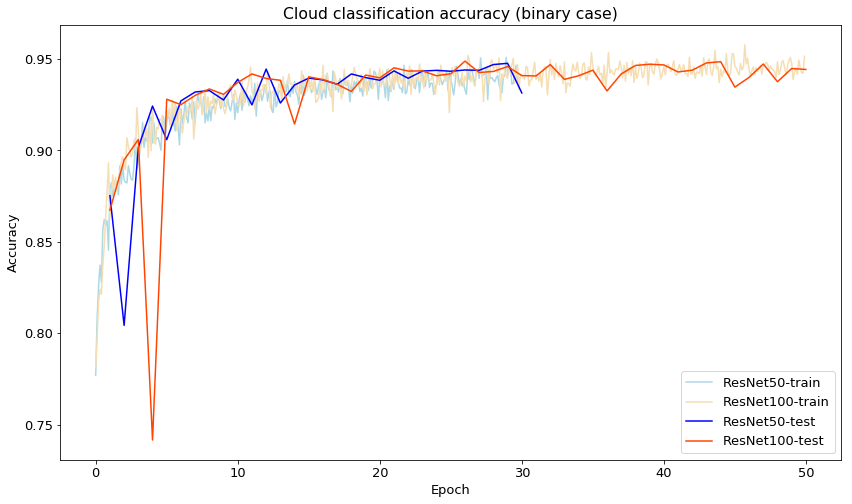

In [48]:
x = np.linspace(0, 50, 501)
plt.plot(x[:len(rn50bin_acc['train'])],          rn50bin_acc['train'], label='ResNet50-train', color='lightblue')
plt.plot(x[:len(rn100bin_acc['train'])],          rn100bin_acc['train'], label='ResNet101-train', color='wheat')
plt.plot(x[::10][1:len(rn50bin_acc['valid'])+1], rn50bin_acc['valid'], label='ResNet50-test', color='blue')
plt.plot(x[::10][1:len(rn100bin_acc['valid'])+1], rn100bin_acc['valid'], label='ResNet101-test', color='orangered')
plt.title('Cloud classification accuracy (binary case)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams.update({'font.size': 13})
plt.show()

In [46]:
rn50bin.load_params(os.path.join(checkpoints, '23-0.params'),ctx)
preds, labels = get_predictions(gluon.data.DataLoader(validIterBin, 32), rn50bin)

Normalized confusion matrix
[[0.96805654 0.03194346]
 [0.11330049 0.88669951]]


array([[6849,  226],
       [ 345, 2700]])

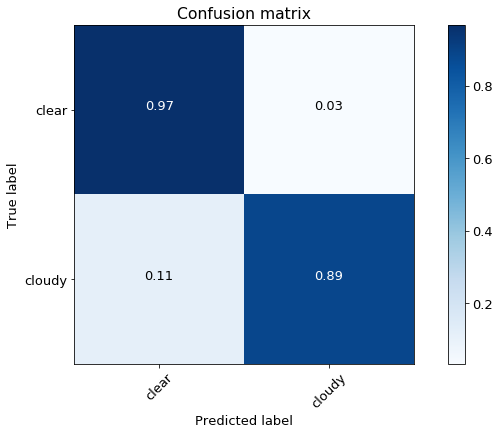

In [47]:
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, ['clear', 'cloudy'], normalize=True)
cm

In [25]:
rn101 = vision.resnet101_v2(classes=2)
rn101.load_params(os.path.join(CHECKPOINTS_DIR, 'resnet100-bin/40-0.params'),ctx)

In [26]:
preds, labels = get_predictions(gluon.data.DataLoader(validIterBin, 32), rn101)

Normalized confusion matrix
[[0.96884336 0.03115664]
 [0.09479133 0.90520867]]


array([[6810,  219],
       [ 293, 2798]])

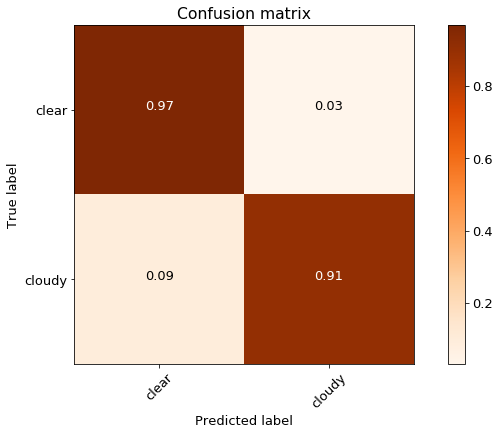

In [31]:
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, ['clear', 'cloudy'], normalize=True)
cm

### Testing with data from Sentinel-2

In [19]:
test_bin  = os.path.join(DATA_DIR, 'test/s2test-binary.rec')

testIterBin = ImageRecordDataset(
    filename=test_bin,
    transform=lambda X, y: transform(X, y, test_augs)
)

In [63]:
rn50bin.load_params(os.path.join(CHECKPOINTS_DIR, 'resnet50-bin/23-0.params'),ctx)
preds, labels = get_predictions(gluon.data.DataLoader(testIterBin, 32), rn50bin)

Normalized confusion matrix
[[0.81217617 0.18782383]
 [0.05302403 0.94697597]]


array([[ 627,  145],
       [  64, 1143]])

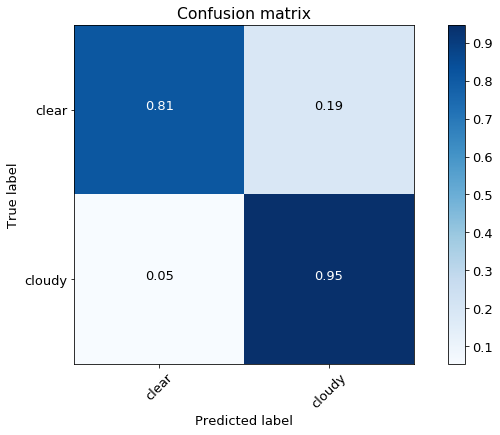

In [64]:
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, ['clear', 'cloudy'], normalize=True)
cm

Accuracy is not as high as before, but precision is still very good. Almost no cloudy images are getting missclassified as clear, which was our main goal.

In [ ]:
preds1, labels1 = get_predictions(gluon.data.DataLoader(testIterBin, 32), rn101)

Normalized confusion matrix
[[0.70984456 0.29015544]
 [0.02816901 0.97183099]]


array([[ 548,  224],
       [  34, 1173]])

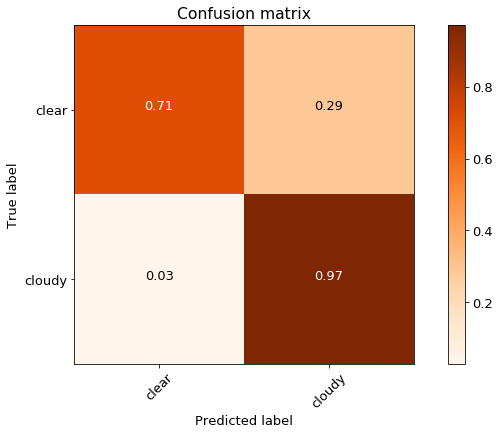

In [30]:
cm = confusion_matrix(labels1, preds1)
plot_confusion_matrix(cm, ['clear', 'cloudy'], normalize=True)
cm